# Análise com o resultado do rating


In [4]:
import os
import dotenv

import boto3
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor

import seaborn as sns
from matplotlib import pyplot as plt

import pickle
import shutil

import locale

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
rootPath = os.getcwd()
dataPath = os.path.join(rootPath, 'data')
modelsPath = os.path.join(rootPath, 'models')
env = os.path.join(rootPath, '.env')
dotenv.load_dotenv(dotenv_path=env)

True

In [7]:
import locale

locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')

def formatar_moeda(valor):
    return locale.currency(valor, grouping=True)

# 01) Importando dados

In [8]:
s3 = boto3.resource(
    service_name='s3',
    region_name='us-east-1',
    aws_access_key_id=os.getenv("AWS_ACESS_KEY"),
    aws_secret_access_key=os.getenv("AWS_SECRET_ACESS_KEY")
    )

def read_s3(bucket_name, folder_name, file_name):
    file_key_aws = folder_name + file_name
    obj = s3.Bucket(bucket_name).Object(file_key_aws).get()
    df = pd.read_csv(obj['Body'], sep=';')
    return df

# QUERY VERSÃO 1 - ANÁLISES

In [24]:
tbl_debitos_dam = r'C:\Users\Consultor\Documents\bases_pesquisa\verificacao\tbl_dam.csv'
debitos_divida = pd.read_csv(tbl_debitos_dam)
debitos_divida

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,qtd_dams_pagas,qtd_dams_abertas,qtd_dams,vlr_pago,vlr_aberto,vlr_total_dam
0,000032f6d93a0abd,2d0abb2531f5995c19002eec9f619408,71fc88ab6bbb201c344d77602867ec09,2021.0,1.0,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,1,0,1,2944.10,0.00,2944.10
1,000032f6d93a0abd,393f868ac32df28f4c1f696350fff79e,71fc88ab6bbb201c344d77602867ec09,2019.0,1.0,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,1,0,1,2627.70,0.00,2627.70
2,000032f6d93a0abd,7b9ddc3437bacdef875350beaddc7871,71fc88ab6bbb201c344d77602867ec09,2022.0,1.0,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,1,0,1,3335.10,0.00,3335.10
3,000032f6d93a0abd,b114a952d31c024190ecf5aaf6be6eb7,71fc88ab6bbb201c344d77602867ec09,2023.0,1.0,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,1,0,1,3630.40,0.00,3630.40
4,000032f6d93a0abd,b8cf2b607f401535eeaa6b163b2f9024,71fc88ab6bbb201c344d77602867ec09,2016.0,1.0,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,1,0,1,1946.50,0.00,1852.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4205364,NaN,ffffe0f065516d9ee08920064611a7cf,NaN,2017.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1,0,1,259.22,0.00,259.22
4205365,NaN,ffffe50b8579275e90ecf5aaf6be6eb7,NaN,2023.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,1,1,0.00,137.56,137.56
4205366,NaN,ffffe769552b3339a938dbf400be2d91,NaN,2008.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1,0,1,707.98,0.00,699.94
4205367,NaN,ffffe774bca33c4619002eec9f619408,NaN,2021.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,1,1,0.00,442.85,442.85


In [25]:
dd = debitos_divida[debitos_divida['ano_fato_gerador'] == 2016]
dd

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,qtd_dams_pagas,qtd_dams_abertas,qtd_dams,vlr_pago,vlr_aberto,vlr_total_dam
4,000032f6d93a0abd,b8cf2b607f401535eeaa6b163b2f9024,71fc88ab6bbb201c344d77602867ec09,2016.0,1.0,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,1,0,1,1946.50,0.00,1852.10
13,00006a4fa855b308,f02cff9218e0fb81eeaa6b163b2f9024,d87e514082d2101ed4613fe022d53698,2016.0,1.0,48.85,1,P,APARTAMENTO,CONSTRUÍDA,IPUTINGA,2008-12-11 22:40:00,1,0,1,212.80,0.00,175.04
17,0000a2cbd951c1ca,35d7656f6131adc4eeaa6b163b2f9024,c2357fdb65f5cbed8e79cf1867e8cc19,2016.0,1.0,174.01,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 21:52:00,1,0,1,2356.70,0.00,2262.30
27,0000c599ab737fa1,720bdd5593728933eeaa6b163b2f9024,4c375f5fe6f11e99cd124eb8021f7dca,2016.0,1.0,125.00,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 23:02:50,1,0,1,880.90,0.00,786.50
45,0000fe7e1c1dbbe4,620a1ce8ee04f3f5eeaa6b163b2f9024,ec4080f1474d5e63d4613fe022d53698,2016.0,1.0,81.00,1,P,APARTAMENTO,CONSTRUÍDA,BOA VISTA,2008-12-11 16:41:41,1,0,1,644.80,0.00,550.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4205229,NaN,fffa93f915d816bceeaa6b163b2f9024,NaN,2016.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,1,1,0.00,416.46,416.46
4205269,NaN,fffc83d7044e921e2b46f673bf0c6125,NaN,2016.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1,0,1,91.31,0.00,89.99
4205288,NaN,fffd2265594cf0d14c1f696350fff79e,NaN,2016.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,1,1,0.00,3045.58,3045.58
4205298,NaN,fffd432719007e13eeaa6b163b2f9024,NaN,2016.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1,0,1,344.17,0.00,339.45


---

In [26]:
formatar_moeda(debitos_divida['vlr_total_dam'].sum())

'R$ 82.329.742.813,69'

In [27]:
soma_por_ano = debitos_divida.groupby('ano_fato_gerador').agg({
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'
}).reset_index()

soma_por_ano['suposto_valor_devido'] = soma_por_ano['vlr_total_dam'] - soma_por_ano['vlr_pago']
# soma_por_ano['diferenca_devido_aberto'] = soma_por_ano['suposto_valor_devido'] - soma_por_ano['vlr_aberto']

soma_por_ano['vlr_total_dam'] = soma_por_ano['vlr_total_dam'].apply(formatar_moeda)
soma_por_ano['vlr_pago'] = soma_por_ano['vlr_pago'].apply(formatar_moeda)
soma_por_ano['vlr_aberto'] = soma_por_ano['vlr_aberto'].apply(formatar_moeda)
soma_por_ano['suposto_valor_devido'] = soma_por_ano['suposto_valor_devido'].apply(formatar_moeda)

soma_por_ano


,ano_fato_gerador,vlr_pago,vlr_total_dam,vlr_aberto,suposto_valor_devido
0,1976.0,"R$ 0,00","R$ 861,68","R$ 0,00","R$ 861,68"
1,1980.0,"R$ 578,18","R$ 1.578,18","R$ 0,00","R$ 1.000,00"
2,1981.0,"R$ 613,62","R$ 1.533,08","R$ 0,00","R$ 919,46"
3,1982.0,"R$ 608,45","R$ 1.500,52","R$ 0,00","R$ 892,07"
4,1983.0,"R$ 557,99","R$ 550,39","R$ 0,00","R$ -7,60"
5,1984.0,"R$ 532,04","R$ 3.105,17","R$ 0,00","R$ 2.573,13"
6,1985.0,"R$ 1.268,00","R$ 26.610,98","R$ 5.199,77","R$ 25.342,98"
7,1986.0,"R$ 0,00","R$ 44.353,28","R$ 4.388,06","R$ 44.353,28"
8,1987.0,"R$ 840.101,23","R$ 12.774.627,76","R$ 10.519.773,81","R$ 11.934.526,53"
9,1988.0,"R$ 25.766,99","R$ 1.888.276,47","R$ 1.801.321,30","R$ 1.862.509,48"


In [28]:
dams_pagas = debitos_divida[(debitos_divida['vlr_pago'] == debitos_divida['vlr_total_dam'])]
dams_pagas

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,qtd_dams_pagas,qtd_dams_abertas,qtd_dams,vlr_pago,vlr_aberto,vlr_total_dam
0,000032f6d93a0abd,2d0abb2531f5995c19002eec9f619408,71fc88ab6bbb201c344d77602867ec09,2021.0,1.0,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,1,0,1,2944.10,0.0,2944.10
1,000032f6d93a0abd,393f868ac32df28f4c1f696350fff79e,71fc88ab6bbb201c344d77602867ec09,2019.0,1.0,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,1,0,1,2627.70,0.0,2627.70
2,000032f6d93a0abd,7b9ddc3437bacdef875350beaddc7871,71fc88ab6bbb201c344d77602867ec09,2022.0,1.0,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,1,0,1,3335.10,0.0,3335.10
3,000032f6d93a0abd,b114a952d31c024190ecf5aaf6be6eb7,71fc88ab6bbb201c344d77602867ec09,2023.0,1.0,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,1,0,1,3630.40,0.0,3630.40
5,000032f6d93a0abd,d22fdd2de1578b53e08920064611a7cf,71fc88ab6bbb201c344d77602867ec09,2017.0,1.0,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,1,0,1,2459.37,0.0,2459.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4205358,NaN,ffffcfdcdefb134411babe4a46e18b6d,NaN,2018.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1,0,1,354.90,0.0,354.90
4205359,NaN,ffffd1829c50006711babe4a46e18b6d,NaN,2018.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1,0,1,555.53,0.0,555.53
4205361,NaN,ffffd81294e264fe0ba9f03948490762,NaN,2020.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1,0,1,435.19,0.0,435.19
4205362,NaN,ffffdf41159b669d4c1f696350fff79e,NaN,2019.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1,0,1,278.34,0.0,278.34


# ARRECADADO POR ANO

In [29]:
soma_por_ano = dams_pagas.groupby('ano_fato_gerador').agg({
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'

}).reset_index()

soma_por_ano['vlr_total_dam'] = soma_por_ano['vlr_total_dam'].apply(formatar_moeda)
soma_por_ano['vlr_pago'] = soma_por_ano['vlr_pago'].apply(formatar_moeda)
soma_por_ano['vlr_aberto'] = soma_por_ano['vlr_aberto'].apply(formatar_moeda)

soma_por_ano


,ano_fato_gerador,vlr_pago,vlr_total_dam,vlr_aberto
0,1985.0,"R$ 937,24","R$ 937,24","R$ 0,00"
1,1987.0,"R$ 61.718,31","R$ 61.718,31","R$ 0,00"
2,1988.0,"R$ 0,00","R$ 0,00","R$ 0,00"
3,1989.0,"R$ 0,00","R$ 0,00","R$ 0,00"
4,1990.0,"R$ 49.851,72","R$ 49.851,72","R$ 0,00"
5,1991.0,"R$ 3.151,84","R$ 3.151,84","R$ 0,00"
6,1992.0,"R$ 5.932,59","R$ 5.932,59","R$ 0,00"
7,1993.0,"R$ 199.570,84","R$ 199.570,84","R$ 0,00"
8,1994.0,"R$ 33.166,36","R$ 33.166,36","R$ 0,00"
9,1995.0,"R$ 3.338,16","R$ 3.338,16","R$ 0,00"


In [30]:
formatar_moeda(dams_pagas['vlr_total_dam'].sum())

'R$ 3.758.008.160,98'

In [31]:
dams_não_pagas = debitos_divida[(debitos_divida['vlr_pago'] == 0)]
dams_não_pagas

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,qtd_dams_pagas,qtd_dams_abertas,qtd_dams,vlr_pago,vlr_aberto,vlr_total_dam
15,00006a4fa855b308,fd695ecd2d8cc7762fdf6d5f8117540c,d87e514082d2101ed4613fe022d53698,2013.0,1.0,48.85,1,P,APARTAMENTO,CONSTRUÍDA,IPUTINGA,2008-12-11 22:40:00,0,1,1,0.0,198.15,198.15
26,0000c599ab737fa1,52a09679bbf7a68690ecf5aaf6be6eb7,4c375f5fe6f11e99cd124eb8021f7dca,2023.0,1.0,125.00,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 23:02:50,0,1,1,0.0,1548.54,1548.54
35,0000d8e55e83b975,4afaf6c7173e4197875350beaddc7871,62067d8c0d1754a5ec24828071529570,2022.0,1.0,144.62,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2017-01-04 16:10:45,0,1,1,0.0,4075.82,4075.82
36,0000d8e55e83b975,85ebc70094dc08ab90ecf5aaf6be6eb7,62067d8c0d1754a5ec24828071529570,2023.0,1.0,144.62,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2017-01-04 16:10:45,0,1,1,0.0,3564.72,3564.72
38,0000e13a7d8d7537,5e6259444ed23a59875350beaddc7871,NaN,2022.0,1.0,61.20,1,P,CASA,CONSTRUÍDA,SAN MARTIN,2008-12-11 19:44:26,0,1,1,0.0,601.44,601.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4205360,NaN,ffffd62be294c472875350beaddc7871,NaN,2022.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,1,1,0.0,463.85,463.85
4205363,NaN,ffffdf41159b669d875350beaddc7871,NaN,2022.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,0,1,0.0,0.00,159.72
4205365,NaN,ffffe50b8579275e90ecf5aaf6be6eb7,NaN,2023.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,1,1,0.0,137.56,137.56
4205367,NaN,ffffe774bca33c4619002eec9f619408,NaN,2021.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,1,1,0.0,442.85,442.85


In [32]:
soma_por_ano = dams_não_pagas.groupby('ano_fato_gerador').agg({
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'
}).reset_index()

soma_por_ano['suposto_valor_devido'] = soma_por_ano['vlr_total_dam'] - soma_por_ano['vlr_pago']
# soma_por_ano['diferenca_devido_aberto'] = soma_por_ano['suposto_valor_devido'] - soma_por_ano['vlr_aberto']

soma_por_ano['vlr_total_dam'] = soma_por_ano['vlr_total_dam'].apply(formatar_moeda)
soma_por_ano['vlr_pago'] = soma_por_ano['vlr_pago'].apply(formatar_moeda)
soma_por_ano['vlr_aberto'] = soma_por_ano['vlr_aberto'].apply(formatar_moeda)
soma_por_ano['suposto_valor_devido'] = soma_por_ano['suposto_valor_devido'].apply(formatar_moeda)

soma_por_ano


,ano_fato_gerador,vlr_pago,vlr_total_dam,vlr_aberto,suposto_valor_devido
0,1976.0,"R$ 0,00","R$ 861,68","R$ 0,00","R$ 861,68"
1,1980.0,"R$ 0,00","R$ 1.007,60","R$ 0,00","R$ 1.007,60"
2,1981.0,"R$ 0,00","R$ 927,06","R$ 0,00","R$ 927,06"
3,1982.0,"R$ 0,00","R$ 899,67","R$ 0,00","R$ 899,67"
4,1984.0,"R$ 0,00","R$ 2.580,73","R$ 0,00","R$ 2.580,73"
5,1985.0,"R$ 0,00","R$ 24.889,19","R$ 5.199,77","R$ 24.889,19"
6,1986.0,"R$ 0,00","R$ 44.353,28","R$ 4.388,06","R$ 44.353,28"
7,1987.0,"R$ 0,00","R$ 11.937.116,44","R$ 10.519.773,81","R$ 11.937.116,44"
8,1988.0,"R$ 0,00","R$ 1.859.367,05","R$ 1.798.016,68","R$ 1.859.367,05"
9,1989.0,"R$ 0,00","R$ 1.055.663.189,89","R$ 1.055.537.630,63","R$ 1.055.663.189,89"


In [33]:
dams_pagas_parcialmente = debitos_divida[(debitos_divida['vlr_pago'] > 0) & (debitos_divida['vlr_pago'] < debitos_divida['vlr_total_dam'])]
dams_pagas_parcialmente

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,qtd_dams_pagas,qtd_dams_abertas,qtd_dams,vlr_pago,vlr_aberto,vlr_total_dam
9,00006a4fa855b308,5e47335403663289e08920064611a7cf,d87e514082d2101ed4613fe022d53698,2017.0,1.0,48.85,1,P,APARTAMENTO,CONSTRUÍDA,IPUTINGA,2008-12-11 22:40:00,1,0,1,252.53,0.00,292.30
18,0000a2cbd951c1ca,435620f76ae803e219002eec9f619408,c2357fdb65f5cbed8e79cf1867e8cc19,2021.0,1.0,174.01,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 21:52:00,1,0,1,2636.40,0.00,2646.25
19,0000a2cbd951c1ca,621779c21ab522df875350beaddc7871,c2357fdb65f5cbed8e79cf1867e8cc19,2022.0,1.0,174.01,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 21:52:00,1,0,1,3713.31,0.00,3780.80
23,0000a2cbd951c1ca,d3616069bbb7c23b90ecf5aaf6be6eb7,c2357fdb65f5cbed8e79cf1867e8cc19,2023.0,1.0,174.01,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 21:52:00,1,1,1,3075.36,814.94,3890.30
32,0000d8e55e83b975,1c12b3fbd8a766c24c1f696350fff79e,62067d8c0d1754a5ec24828071529570,2019.0,1.0,144.62,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2017-01-04 16:10:45,1,0,1,3129.69,0.00,3720.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4201724,NaN,ff774fa587c33cc26c624eea554ca8d2,NaN,2003.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1,1,1,1297.46,1732.64,3030.10
4203117,NaN,fface1fdd0869c732ae93ff99c4000e8,NaN,1992.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1,0,1,779.08,0.00,1094.88
4203499,NaN,ffba0e56c0c9879689ee41b44b65fb05,NaN,2005.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1,1,1,26929.53,888.95,27818.48
4203652,NaN,ffbf6c5dc50645312b0ed56c63dc92b2,NaN,1997.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1,1,1,1837.18,158.23,1995.41


In [34]:
soma_por_ano = dams_pagas_parcialmente.groupby('ano_fato_gerador').agg({
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'
}).reset_index()

# Criando a nova coluna 'suposto_valor_devido'
soma_por_ano['suposto_valor_devido'] = soma_por_ano['vlr_total_dam'] - soma_por_ano['vlr_pago']
# soma_por_ano['diferenca_devido_aberto'] = soma_por_ano['suposto_valor_devido'] - soma_por_ano['vlr_aberto']

# Formatando as colunas 'vlr_total_dam', 'vlr_pago' e 'vlr_aberto' como moeda
soma_por_ano['vlr_total_dam'] = soma_por_ano['vlr_total_dam'].apply(formatar_moeda)
soma_por_ano['vlr_pago'] = soma_por_ano['vlr_pago'].apply(formatar_moeda)
soma_por_ano['vlr_aberto'] = soma_por_ano['vlr_aberto'].apply(formatar_moeda)
soma_por_ano['suposto_valor_devido'] = soma_por_ano['suposto_valor_devido'].apply(formatar_moeda)

soma_por_ano


,ano_fato_gerador,vlr_pago,vlr_total_dam,vlr_aberto,suposto_valor_devido
0,1985.0,"R$ 330,76","R$ 784,55","R$ 0,00","R$ 453,79"
1,1988.0,"R$ 1.936,84","R$ 5.233,97","R$ 3.304,62","R$ 3.297,13"
2,1989.0,"R$ 850,69","R$ 2.638,45","R$ 1.791,16","R$ 1.787,76"
3,1990.0,"R$ 33.603.622,63","R$ 41.214.779,36","R$ 0,00","R$ 7.611.156,73"
4,1991.0,"R$ 5.828.486,28","R$ 6.708.086,08","R$ 0,00","R$ 879.599,80"
5,1992.0,"R$ 76.027.065,18","R$ 84.163.019,07","R$ 927,36","R$ 8.135.953,89"
6,1993.0,"R$ 9.434.104,36","R$ 9.859.874,38","R$ 1.879,34","R$ 425.770,02"
7,1994.0,"R$ 3.791.035,23","R$ 3.997.097,64","R$ 120,39","R$ 206.062,41"
8,1995.0,"R$ 762.617,55","R$ 813.702,57","R$ 68,75","R$ 51.085,02"
9,1996.0,"R$ 81.489,51","R$ 212.210,36","R$ 4.059,02","R$ 130.720,85"


In [35]:
dams_pagas_superior_a_divida = debitos_divida[(debitos_divida['vlr_pago'] > debitos_divida['vlr_total_dam'])]
dams_pagas_superior_a_divida

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,qtd_dams_pagas,qtd_dams_abertas,qtd_dams,vlr_pago,vlr_aberto,vlr_total_dam
4,000032f6d93a0abd,b8cf2b607f401535eeaa6b163b2f9024,71fc88ab6bbb201c344d77602867ec09,2016.0,1.0,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,1,0,1,1946.50,0.0,1852.10
13,00006a4fa855b308,f02cff9218e0fb81eeaa6b163b2f9024,d87e514082d2101ed4613fe022d53698,2016.0,1.0,48.85,1,P,APARTAMENTO,CONSTRUÍDA,IPUTINGA,2008-12-11 22:40:00,1,0,1,212.80,0.0,175.04
17,0000a2cbd951c1ca,35d7656f6131adc4eeaa6b163b2f9024,c2357fdb65f5cbed8e79cf1867e8cc19,2016.0,1.0,174.01,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 21:52:00,1,0,1,2356.70,0.0,2262.30
27,0000c599ab737fa1,720bdd5593728933eeaa6b163b2f9024,4c375f5fe6f11e99cd124eb8021f7dca,2016.0,1.0,125.00,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 23:02:50,1,0,1,880.90,0.0,786.50
45,0000fe7e1c1dbbe4,620a1ce8ee04f3f5eeaa6b163b2f9024,ec4080f1474d5e63d4613fe022d53698,2016.0,1.0,81.00,1,P,APARTAMENTO,CONSTRUÍDA,BOA VISTA,2008-12-11 16:41:41,1,0,1,644.80,0.0,550.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4205327,NaN,fffe77bd77c1ab46f4df934698e31658,NaN,2006.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1,0,1,185.40,0.0,182.71
4205340,NaN,ffff29c6afbd6f7f3d648baf21387e6f,NaN,2014.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1,0,1,412.28,0.0,407.99
4205349,NaN,ffff9c9f7e78fa7be67cda4bf42b9b53,NaN,2015.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1,0,1,295.72,0.0,291.43
4205351,NaN,ffffa95ab3cedab8eeaa6b163b2f9024,NaN,2016.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1,0,1,707.84,0.0,693.68


In [36]:
soma_por_ano = dams_pagas_superior_a_divida.groupby('ano_fato_gerador').agg({
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'
}).reset_index()

# Criando a nova coluna 'suposto_valor_devido'
soma_por_ano['suposto_valor_devido'] = soma_por_ano['vlr_total_dam'] - soma_por_ano['vlr_pago']
# soma_por_ano['diferenca_devido_aberto'] = soma_por_ano['suposto_valor_devido'] - soma_por_ano['vlr_aberto']

# Formatando as colunas 'vlr_total_dam', 'vlr_pago' e 'vlr_aberto' como moeda
soma_por_ano['vlr_total_dam'] = soma_por_ano['vlr_total_dam'].apply(formatar_moeda)
soma_por_ano['vlr_pago'] = soma_por_ano['vlr_pago'].apply(formatar_moeda)
soma_por_ano['vlr_aberto'] = soma_por_ano['vlr_aberto'].apply(formatar_moeda)
soma_por_ano['suposto_valor_devido'] = soma_por_ano['suposto_valor_devido'].apply(formatar_moeda)

soma_por_ano

,ano_fato_gerador,vlr_pago,vlr_total_dam,vlr_aberto,suposto_valor_devido
0,1980.0,"R$ 578,18","R$ 570,58","R$ 0,00","R$ -7,60"
1,1981.0,"R$ 613,62","R$ 606,02","R$ 0,00","R$ -7,60"
2,1982.0,"R$ 608,45","R$ 600,85","R$ 0,00","R$ -7,60"
3,1983.0,"R$ 557,99","R$ 550,39","R$ 0,00","R$ -7,60"
4,1984.0,"R$ 532,04","R$ 524,44","R$ 0,00","R$ -7,60"
5,1987.0,"R$ 778.382,92","R$ 775.793,01","R$ 0,00","R$ -2.589,91"
6,1988.0,"R$ 23.830,15","R$ 23.675,45","R$ 0,00","R$ -154,70"
7,1989.0,"R$ 2.560.443,28","R$ 2.552.410,82","R$ 0,00","R$ -8.032,46"
8,1990.0,"R$ 56.475.335,71","R$ 55.458.019,10","R$ 0,00","R$ -1.017.316,61"
9,1991.0,"R$ 406.564,34","R$ 395.687,98","R$ 0,00","R$ -10.876,36"


In [37]:
nulos = debitos_divida[(pd.notnull(debitos_divida['dam'])) & (pd.isnull(debitos_divida['id_contribuinte']))]
nulos = nulos['dam'].count()
nulos


1846767

In [38]:
1846767/4205369


0.43914505480969684

In [39]:
contagem_nulos_por_coluna = debitos_divida.isnull().sum()
contagem_nulos_por_coluna.to_frame()


,0
id_imovel,1698842
dam,0
id_contribuinte,1846767
ano_fato_gerador,0
qtd_pavimentos,1698842
area_construida,1806907
imovel_regular,0
natureza_imovel,1698842
tipo_propriedade,1806907
situacao_edificacao,1806907


In [40]:
contagem_nulos_por_coluna = debitos_divida.isnull().sum()
total_registros = len(debitos_divida)

porcentagem_nulos_por_coluna = (contagem_nulos_por_coluna / total_registros) * 100

resultado = pd.DataFrame({
    'Sem Registro': contagem_nulos_por_coluna,
    'Total Registros': total_registros,
    'Porcentagem Nulos (%)': porcentagem_nulos_por_coluna
})

resultado


,Sem Registro,Total Registros,Porcentagem Nulos (%)
id_imovel,1698842,4205369,40.396978
dam,0,4205369,0.000000
id_contribuinte,1846767,4205369,43.914505
ano_fato_gerador,0,4205369,0.000000
qtd_pavimentos,1698842,4205369,40.396978
area_construida,1806907,4205369,42.966670
imovel_regular,0,4205369,0.000000
natureza_imovel,1698842,4205369,40.396978
tipo_propriedade,1806907,4205369,42.966670
situacao_edificacao,1806907,4205369,42.966670


In [41]:
1846767/4205369

0.43914505480969684

In [42]:
aux = debitos_divida[(debitos_divida['vlr_pago']) > (debitos_divida['vlr_total_dam'])]
aux

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,qtd_dams_pagas,qtd_dams_abertas,qtd_dams,vlr_pago,vlr_aberto,vlr_total_dam
4,000032f6d93a0abd,b8cf2b607f401535eeaa6b163b2f9024,71fc88ab6bbb201c344d77602867ec09,2016.0,1.0,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,1,0,1,1946.50,0.0,1852.10
13,00006a4fa855b308,f02cff9218e0fb81eeaa6b163b2f9024,d87e514082d2101ed4613fe022d53698,2016.0,1.0,48.85,1,P,APARTAMENTO,CONSTRUÍDA,IPUTINGA,2008-12-11 22:40:00,1,0,1,212.80,0.0,175.04
17,0000a2cbd951c1ca,35d7656f6131adc4eeaa6b163b2f9024,c2357fdb65f5cbed8e79cf1867e8cc19,2016.0,1.0,174.01,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 21:52:00,1,0,1,2356.70,0.0,2262.30
27,0000c599ab737fa1,720bdd5593728933eeaa6b163b2f9024,4c375f5fe6f11e99cd124eb8021f7dca,2016.0,1.0,125.00,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 23:02:50,1,0,1,880.90,0.0,786.50
45,0000fe7e1c1dbbe4,620a1ce8ee04f3f5eeaa6b163b2f9024,ec4080f1474d5e63d4613fe022d53698,2016.0,1.0,81.00,1,P,APARTAMENTO,CONSTRUÍDA,BOA VISTA,2008-12-11 16:41:41,1,0,1,644.80,0.0,550.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4205327,NaN,fffe77bd77c1ab46f4df934698e31658,NaN,2006.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1,0,1,185.40,0.0,182.71
4205340,NaN,ffff29c6afbd6f7f3d648baf21387e6f,NaN,2014.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1,0,1,412.28,0.0,407.99
4205349,NaN,ffff9c9f7e78fa7be67cda4bf42b9b53,NaN,2015.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1,0,1,295.72,0.0,291.43
4205351,NaN,ffffa95ab3cedab8eeaa6b163b2f9024,NaN,2016.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1,0,1,707.84,0.0,693.68


In [43]:
pago = formatar_moeda(aux['vlr_pago'].sum())
pago

'R$ 6.094.100.679,25'

In [44]:
devido = formatar_moeda(aux['vlr_total_dam'].sum())
devido

'R$ 6.022.166.056,73'

In [45]:
6094100679.25-6022166056.73

71934622.52000046

In [46]:
df = debitos_divida[debitos_divida['id_contribuinte'] == 'e07ae583135dea50be91dcec7d89e48e']
df

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,qtd_dams_pagas,qtd_dams_abertas,qtd_dams,vlr_pago,vlr_aberto,vlr_total_dam
2425789,f7d1389bd0abda28,0632ea8731b55ff5e67cda4bf42b9b53,e07ae583135dea50be91dcec7d89e48e,2015.0,1.0,45.02,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2010-07-27 11:47:22,1,1,1,224.3,269.11,458.23
2425790,f7d1389bd0abda28,20d8380967737de490ecf5aaf6be6eb7,e07ae583135dea50be91dcec7d89e48e,2023.0,1.0,45.02,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2010-07-27 11:47:22,0,1,1,0.0,677.79,677.79
2425791,f7d1389bd0abda28,4ae6de3dd567102b11babe4a46e18b6d,e07ae583135dea50be91dcec7d89e48e,2018.0,1.0,45.02,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2010-07-27 11:47:22,0,1,1,0.0,577.72,577.72
2425792,f7d1389bd0abda28,567292ce8b5f6b73e08920064611a7cf,e07ae583135dea50be91dcec7d89e48e,2017.0,1.0,45.02,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2010-07-27 11:47:22,0,1,1,0.0,519.09,519.09
2425793,f7d1389bd0abda28,6fd07ae9cfe9be844c1f696350fff79e,e07ae583135dea50be91dcec7d89e48e,2019.0,1.0,45.02,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2010-07-27 11:47:22,0,1,1,0.0,579.84,579.84
2425794,f7d1389bd0abda28,7336064b99239ba9875350beaddc7871,e07ae583135dea50be91dcec7d89e48e,2022.0,1.0,45.02,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2010-07-27 11:47:22,0,1,1,0.0,764.80,764.80
2425795,f7d1389bd0abda28,bb368d341253cf98eeaa6b163b2f9024,e07ae583135dea50be91dcec7d89e48e,2016.0,1.0,45.02,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2010-07-27 11:47:22,0,1,1,0.0,467.28,467.28


# CONTRIBUINTE

In [47]:
tbl_contribuinte = r'C:\Users\Consultor\Documents\bases_pesquisa\verificacao\tbl_contribuinte_debito.csv'
contribuinte = pd.read_csv(tbl_contribuinte)
contribuinte

,id_contribuinte,reco_debito,reco_divida_ativa,freq_parcelamento,hist_pagamento_qtd,num_imoveis,pgt_cota_unica
0,e25f07f4638b0b4f344d77602867ec09,2.0,5.0,NaN,1.0,1,NaN
1,eaf4d42d27e17f6e344d77602867ec09,1.0,NaN,NaN,5.0,1,NaN
2,468eb21a43b1bc8e26c4027692f32824,NaN,NaN,1.0,1.0,1,NaN
3,2fce5f00c6de8bb9cd124eb8021f7dca,8.0,33.0,23.0,41.0,17,2.0
4,e07ae583135dea50be91dcec7d89e48e,2.0,1.0,NaN,1.0,1,NaN
...,...,...,...,...,...,...,...
250260,184ce4bb8e1388d2d8b209292c0ce31d,3.0,1.0,7.0,13.0,5,NaN
250261,6f99d715fd3a90861603ecd7ff6be21f,NaN,NaN,NaN,NaN,1,1.0
250262,7cbdd82cba0c7f3b2da5e2e6f6bac27b,1.0,5.0,NaN,1.0,1,NaN
250263,c66f22bdb84e053a76beb59f44c20df3,2.0,8.0,NaN,1.0,1,NaN


In [48]:
cota = contribuinte[(pd.notnull(contribuinte['freq_parcelamento'])) & (pd.notnull(contribuinte['pgt_cota_unica']))]
# cota = cota['id_contribuinte'].count()
cota

,id_contribuinte,reco_debito,reco_divida_ativa,freq_parcelamento,hist_pagamento_qtd,num_imoveis,pgt_cota_unica
3,2fce5f00c6de8bb9cd124eb8021f7dca,8.0,33.0,23.0,41.0,17,2.0
19,1f20cc92d28aa9e5d8b209292c0ce31d,NaN,NaN,1.0,2.0,1,1.0
67,3b5a76409f3031400246e2b93c1bf25c,NaN,2.0,1.0,2.0,1,1.0
97,54cea081ed640235344d77602867ec09,NaN,NaN,1.0,1.0,1,1.0
115,1ffd55944ff5024d016a94d4634387ac,NaN,2.0,2.0,5.0,2,2.0
...,...,...,...,...,...,...,...
250207,3871511348d7db6f75234379af146d63,NaN,NaN,1.0,NaN,2,1.0
250212,d478d08218d89a2bacc7ff10b872fdd2,1.0,NaN,1.0,4.0,2,1.0
250226,71d5a5f8e6ab9eeb0246e2b93c1bf25c,NaN,NaN,1.0,4.0,1,1.0
250250,7fbdb48b2d7559c39daa7b7dbb545c1c,NaN,7.0,1.0,1.0,1,1.0


In [49]:
12341/250265

0.04931172956665934

In [50]:
aux2 = contribuinte[(contribuinte['reco_divida_ativa']) > (contribuinte['reco_debito'])]
aux2

,id_contribuinte,reco_debito,reco_divida_ativa,freq_parcelamento,hist_pagamento_qtd,num_imoveis,pgt_cota_unica
0,e25f07f4638b0b4f344d77602867ec09,2.0,5.0,NaN,1.0,1,NaN
3,2fce5f00c6de8bb9cd124eb8021f7dca,8.0,33.0,23.0,41.0,17,2.0
5,66b905e3134f4ca98e79cf1867e8cc19,2.0,16.0,NaN,NaN,2,NaN
6,ed595c8ee93307839daa7b7dbb545c1c,4.0,15.0,NaN,4.0,5,3.0
11,f62000e8ac6b4b1575234379af146d63,2.0,6.0,NaN,3.0,1,NaN
...,...,...,...,...,...,...,...
250252,ddbb1cbcd73cf7db9daa7b7dbb545c1c,2.0,4.0,1.0,3.0,1,NaN
250254,870832bef7f7ec6ed8b209292c0ce31d,2.0,8.0,NaN,NaN,2,NaN
250259,30e5330bdb4c664bacc7ff10b872fdd2,1.0,9.0,NaN,7.0,1,NaN
250262,7cbdd82cba0c7f3b2da5e2e6f6bac27b,1.0,5.0,NaN,1.0,1,NaN


In [51]:
67948/250265

0.27150420554212534

In [52]:
df = contribuinte[contribuinte['id_contribuinte'] == 'e07ae583135dea50be91dcec7d89e48e']
df

,id_contribuinte,reco_debito,reco_divida_ativa,freq_parcelamento,hist_pagamento_qtd,num_imoveis,pgt_cota_unica
4,e07ae583135dea50be91dcec7d89e48e,2.0,1.0,NaN,1.0,1,NaN


In [53]:
contagem_nulos_por_coluna_contribuinte = contribuinte.isnull().sum()
total_registros_contribuinte = len(contribuinte)

porcentagem_nulos = (contagem_nulos_por_coluna_contribuinte / total_registros_contribuinte) * 100

resultado = pd.DataFrame({
    'Contagem Nulos': contagem_nulos_por_coluna_contribuinte,
    'Total Registros': total_registros_contribuinte,
    'Porcentagem Nulos (%)': porcentagem_nulos
})

resultado

,Contagem Nulos,Total Registros,Porcentagem Nulos (%)
id_contribuinte,0,250265,0.000000
reco_debito,107813,250265,43.079536
reco_divida_ativa,136310,250265,54.466266
freq_parcelamento,199736,250265,79.809802
hist_pagamento_qtd,95799,250265,38.279024
num_imoveis,0,250265,0.000000
pgt_cota_unica,184845,250265,73.859709


# QUERY VERSÃO 2 - ANÁLISES 14/11

## DAM - DÍVIDAS

In [54]:
tbl_debitos_dam = r'C:\Users\Consultor\Documents\bases_pesquisa\verificacao\tbl_dam_debito_2.csv'
debitos_divida = pd.read_csv(tbl_debitos_dam)
debitos_divida

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,vlr_pago,vlr_aberto,vlr_total_dam
0,fb09bb4434b80ae9,a4ce0d983d87daf30ba9f03948490762,36508256cf126f6afbdc215f5dcc9c51,2020.0,1,58.00,1,P,SALA,CONSTRUÍDA,PAISSANDU,2008-12-11 22:26:39,1080.80,0.00,1080.80
1,cdb6fc0baec18ca9,947726ef6d657fa4875350beaddc7871,c444087f724373939daa7b7dbb545c1c,2022.0,1,110.80,1,P,APARTAMENTO,CONSTRUÍDA,MADALENA,2008-12-11 18:52:27,0.00,2508.44,2508.44
2,d9c9e39c4c4f8ce3,5f6ad6b7a75ce14211babe4a46e18b6d,b340af53f72ff1fdcd124eb8021f7dca,2018.0,1,89.00,1,P,CASA,CONSTRUÍDA,AFOGADOS,2008-12-11 19:54:22,691.70,0.00,691.70
3,870543fc34c438ae,fd6ab9d88cf75642875350beaddc7871,f9004923540036616ffd495caaf8b576,2022.0,1,47.19,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 22:45:44,223.80,0.00,223.80
4,26fe2fe2a920ee0d,d2d0842adc3281e611babe4a46e18b6d,0dedd7fba9ba526dacc7ff10b872fdd2,2018.0,1,69.00,1,P,APARTAMENTO,CONSTRUÍDA,ZUMBI,2008-12-11 22:43:17,359.15,0.00,373.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2506522,63b0f5be0c664694,cfc97b6fa2796e3ea7865723b5986f04,570c09175811827b10c0388451f624a3,2004.0,1,78.58,1,P,APARTAMENTO,CONSTRUÍDA,IMBIRIBEIRA,2008-12-11 21:28:12,38.73,0.00,41.54
2506523,98972132de4feb79,770da308146328c34c1f696350fff79e,860a8129e829ca8bd8b209292c0ce31d,2019.0,1,290.04,1,P,APARTAMENTO,CONSTRUÍDA,PARNAMIRIM,2008-12-11 22:38:43,6196.60,0.00,6196.60
2506524,9f8a1cf0054c7611,5e34f216f9dfe909875350beaddc7871,16653db9ca871c86acc7ff10b872fdd2,2022.0,1,75.00,1,P,APARTAMENTO,CONSTRUÍDA,PARNAMIRIM,2008-12-11 18:28:38,2022.90,0.00,2022.90
2506525,5e4191f95bbb9f42,2933303f8a9f9c3f4c1f696350fff79e,57f2d89cb1e4895f75234379af146d63,2019.0,1,12.65,1,P,GARAGEM COMERCIAL,CONSTRUÍDA,PARNAMIRIM,2008-12-11 22:38:20,152.52,0.00,152.52


In [55]:
arq_bairros = r'C:\Users\Consultor\Documents\bases_pesquisa\bairros.xlsx'
tbl_bairros = pd.read_excel(arq_bairros)
tbl_bairros

,bairro,regiao,rpa
0,AFLITOS,NORDESTE,3A
1,AFOGADOS,SUDESTE,5
2,AGUA FRIA,NORTE,2
3,ALTO JOSE BONIFACIO,NORDESTE,3B
4,ALTO JOSE DO PINHO,NORDESTE,3B
...,...,...,...
89,TORROES,OESTE,4
90,TOTO,SUDESTE,5
91,VARZEA,OESTE,4
92,VASCO DA GAMA,NORDESTE,3B


In [56]:
debitos_divida = pd.merge(debitos_divida, tbl_bairros, on='bairro', how='left')
debitos_divida

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,vlr_pago,vlr_aberto,vlr_total_dam,regiao,rpa
0,fb09bb4434b80ae9,a4ce0d983d87daf30ba9f03948490762,36508256cf126f6afbdc215f5dcc9c51,2020.0,1,58.00,1,P,SALA,CONSTRUÍDA,PAISSANDU,2008-12-11 22:26:39,1080.80,0.00,1080.80,CENTRO,1
1,cdb6fc0baec18ca9,947726ef6d657fa4875350beaddc7871,c444087f724373939daa7b7dbb545c1c,2022.0,1,110.80,1,P,APARTAMENTO,CONSTRUÍDA,MADALENA,2008-12-11 18:52:27,0.00,2508.44,2508.44,OESTE,4
2,d9c9e39c4c4f8ce3,5f6ad6b7a75ce14211babe4a46e18b6d,b340af53f72ff1fdcd124eb8021f7dca,2018.0,1,89.00,1,P,CASA,CONSTRUÍDA,AFOGADOS,2008-12-11 19:54:22,691.70,0.00,691.70,SUDESTE,5
3,870543fc34c438ae,fd6ab9d88cf75642875350beaddc7871,f9004923540036616ffd495caaf8b576,2022.0,1,47.19,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 22:45:44,223.80,0.00,223.80,OESTE,4
4,26fe2fe2a920ee0d,d2d0842adc3281e611babe4a46e18b6d,0dedd7fba9ba526dacc7ff10b872fdd2,2018.0,1,69.00,1,P,APARTAMENTO,CONSTRUÍDA,ZUMBI,2008-12-11 22:43:17,359.15,0.00,373.90,OESTE,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2506522,63b0f5be0c664694,cfc97b6fa2796e3ea7865723b5986f04,570c09175811827b10c0388451f624a3,2004.0,1,78.58,1,P,APARTAMENTO,CONSTRUÍDA,IMBIRIBEIRA,2008-12-11 21:28:12,38.73,0.00,41.54,SUL,6
2506523,98972132de4feb79,770da308146328c34c1f696350fff79e,860a8129e829ca8bd8b209292c0ce31d,2019.0,1,290.04,1,P,APARTAMENTO,CONSTRUÍDA,PARNAMIRIM,2008-12-11 22:38:43,6196.60,0.00,6196.60,NORDESTE,3A
2506524,9f8a1cf0054c7611,5e34f216f9dfe909875350beaddc7871,16653db9ca871c86acc7ff10b872fdd2,2022.0,1,75.00,1,P,APARTAMENTO,CONSTRUÍDA,PARNAMIRIM,2008-12-11 18:28:38,2022.90,0.00,2022.90,NORDESTE,3A
2506525,5e4191f95bbb9f42,2933303f8a9f9c3f4c1f696350fff79e,57f2d89cb1e4895f75234379af146d63,2019.0,1,12.65,1,P,GARAGEM COMERCIAL,CONSTRUÍDA,PARNAMIRIM,2008-12-11 22:38:20,152.52,0.00,152.52,NORDESTE,3A


# IMÓVEIS CADASTRADOS POR ANO

In [ ]:
contagem_distinta_por_ano = debitos_divida.groupby('ano_fato_gerador')['id_imovel'].nunique().reset_index()
contagem_distinta_por_ano

,ano_fato_gerador,id_imovel
0,1976.0,1
1,1980.0,1
2,1981.0,1
3,1982.0,1
4,1984.0,1
5,1986.0,1
6,1987.0,4
7,1988.0,4
8,1989.0,3
9,1990.0,353


# ANÁLISE DOS CONTRIBUINTES NULOS

In [58]:
check_contribuinte = debitos_divida[debitos_divida['id_contribuinte'].isnull()]
check_contribuinte

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,vlr_pago,vlr_aberto,vlr_total_dam,regiao,rpa
5,6503bfb9ebc00b58,a1bb4e4d67edf0e711babe4a46e18b6d,NaN,2018.0,1,349.37,1,P,CASA,CONSTRUÍDA,VARZEA,2008-12-11 19:32:57,4094.60,0.0,4094.60,OESTE,4
13,db05e7c703107e4a,138a65dd03fa02de11babe4a46e18b6d,NaN,2018.0,1,44.00,1,P,CASA,CONSTRUÍDA,NOVA DESCOBERTA,2008-12-11 22:33:52,180.32,0.0,180.32,NORDESTE,3B
32,3961340c13802c1e,714af9e1586a4785875350beaddc7871,NaN,2022.0,1,NaN,1,T,NaN,NaN,JIQUIA,2008-12-11 22:48:38,916.30,0.0,916.30,SUDESTE,5
37,1cdb5e4ede1d6b04,3878bd8a56cb98e511babe4a46e18b6d,NaN,2018.0,1,224.00,1,P,CASA,CONSTRUÍDA,BOMBA DO HEMETERIO,2008-12-11 17:26:17,4112.50,0.0,4112.50,NORTE,2
47,1f08b81a395b12a0,87653c3f381d6cf7875350beaddc7871,NaN,2022.0,1,130.00,1,P,HOTEL,CONSTRUÍDA,SAO JOSE,2008-12-11 17:07:33,2933.21,0.0,3052.80,CENTRO,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2506453,dd243fef4c8fca79,fe5ae23c4112892019002eec9f619408,NaN,2021.0,1,114.39,1,P,APARTAMENTO,CONSTRUÍDA,MADALENA,2008-12-11 22:44:02,1239.40,0.0,1239.40,OESTE,4
2506454,f9ac3214aa7de344,766eea9948ac44bf4c1f696350fff79e,NaN,2019.0,1,165.18,1,P,CASA,CONSTRUÍDA,MANGUEIRA,2008-12-11 22:47:42,952.44,0.0,958.14,SUDESTE,5
2506493,12c707019dcd7ddf,88ae09dc94511eb24c1f696350fff79e,NaN,2019.0,1,118.48,1,P,APARTAMENTO,CONSTRUÍDA,CASA AMARELA,2008-12-11 22:36:32,1236.10,0.0,1452.82,NORDESTE,3A
2506518,b1ff1d4ccf6bb048,0a8dad8d3a0ac7446c624eea554ca8d2,NaN,2003.0,1,NaN,1,T,NaN,NaN,BARRO,2008-12-11 20:29:48,0.00,0.0,17162.31,SUDESTE,5


In [59]:
total_dams_iguais = (check_contribuinte['vlr_pago'] == check_contribuinte['vlr_total_dam']).sum()
total_dams = len(check_contribuinte)
percentual_dams_iguais = (total_dams_iguais / total_dams) * 100

print(f"Quantidade de DAMs em que vlr_pago é igual a vlr_total_dam: {total_dams_iguais}")
print(f"Percentual: {percentual_dams_iguais:.2f}%")

Quantidade de DAMs em que vlr_pago é igual a vlr_total_dam: 50624
Percentual: 34.22%


In [60]:
total_dams_iguais = (check_contribuinte['vlr_pago'] == 0).sum()
total_dams = len(check_contribuinte)
percentual_dams_iguais = (total_dams_iguais / total_dams) * 100

print(f"Quantidade de DAMs em que vlr_pago é igual a zero: {total_dams_iguais}")
print(f"Percentual: {percentual_dams_iguais:.2f}%")

Quantidade de DAMs em que vlr_pago é igual a zero: 76590
Percentual: 51.78%


In [61]:
total_dams_iguais = ((check_contribuinte['vlr_pago'] != 0) & (check_contribuinte['vlr_pago'] < check_contribuinte['vlr_total_dam'])).sum()
total_dams = len(check_contribuinte)
percentual_dams_iguais = (total_dams_iguais / total_dams) * 100

print(f"Quantidade de DAMs em que vlr_pago é maior que zero e menor que o lançado: {total_dams_iguais}")
print(f"Percentual: {percentual_dams_iguais:.2f}%")

Quantidade de DAMs em que vlr_pago é maior que zero e menor que o lançado: 20711
Percentual: 14.00%


---

In [62]:
formatar_moeda(debitos_divida['vlr_aberto'].sum())

'R$ 1.169.042.137,47'

In [63]:
soma_por_ano = debitos_divida.groupby('ano_fato_gerador').agg({
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'
}).reset_index()

# Criando a nova coluna 'suposto_valor_devido'
soma_por_ano['suposto_valor_devido'] = soma_por_ano['vlr_total_dam'] - soma_por_ano['vlr_pago']
# soma_por_ano['diferenca_devido_aberto'] = soma_por_ano['suposto_valor_devido'] - soma_por_ano['vlr_aberto']

# Formatando as colunas 'vlr_total_dam', 'vlr_pago' e 'vlr_aberto' como moeda
soma_por_ano['vlr_total_dam'] = soma_por_ano['vlr_total_dam'].apply(formatar_moeda)
soma_por_ano['vlr_pago'] = soma_por_ano['vlr_pago'].apply(formatar_moeda)
soma_por_ano['vlr_aberto'] = soma_por_ano['vlr_aberto'].apply(formatar_moeda)
soma_por_ano['suposto_valor_devido'] = soma_por_ano['suposto_valor_devido'].apply(formatar_moeda)

soma_por_ano

,ano_fato_gerador,vlr_pago,vlr_total_dam,vlr_aberto,suposto_valor_devido
0,1976.0,"R$ 0,00","R$ 861,68","R$ 0,00","R$ 861,68"
1,1980.0,"R$ 0,00","R$ 1.007,60","R$ 0,00","R$ 1.007,60"
2,1981.0,"R$ 0,00","R$ 927,06","R$ 0,00","R$ 927,06"
3,1982.0,"R$ 0,00","R$ 899,67","R$ 0,00","R$ 899,67"
4,1984.0,"R$ 0,00","R$ 962,31","R$ 0,00","R$ 962,31"
5,1986.0,"R$ 0,00","R$ 2.794,37","R$ 0,00","R$ 2.794,37"
6,1987.0,"R$ 0,00","R$ 4.625,46","R$ 0,00","R$ 4.625,46"
7,1988.0,"R$ 0,00","R$ 4.831,22","R$ 0,00","R$ 4.831,22"
8,1989.0,"R$ 0,00","R$ 9.871,41","R$ 0,00","R$ 9.871,41"
9,1990.0,"R$ 33.615.648,94","R$ 45.594.923,03","R$ 1.731.597,26","R$ 11.979.274,09"


In [64]:
formatar_moeda(debitos_divida['vlr_aberto'].sum())

'R$ 1.169.042.137,47'

In [65]:
formatar_moeda(debitos_divida['vlr_total_dam'].sum())

'R$ 6.990.079.245,86'

In [66]:
formatar_moeda(debitos_divida['vlr_pago'].sum())

'R$ 5.417.009.716,40'

In [67]:
dams_pagas = debitos_divida[(debitos_divida['vlr_pago'] == debitos_divida['vlr_total_dam'])]
dams_pagas

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,vlr_pago,vlr_aberto,vlr_total_dam,regiao,rpa
0,fb09bb4434b80ae9,a4ce0d983d87daf30ba9f03948490762,36508256cf126f6afbdc215f5dcc9c51,2020.0,1,58.00,1,P,SALA,CONSTRUÍDA,PAISSANDU,2008-12-11 22:26:39,1080.80,0.0,1080.80,CENTRO,1
2,d9c9e39c4c4f8ce3,5f6ad6b7a75ce14211babe4a46e18b6d,b340af53f72ff1fdcd124eb8021f7dca,2018.0,1,89.00,1,P,CASA,CONSTRUÍDA,AFOGADOS,2008-12-11 19:54:22,691.70,0.0,691.70,SUDESTE,5
3,870543fc34c438ae,fd6ab9d88cf75642875350beaddc7871,f9004923540036616ffd495caaf8b576,2022.0,1,47.19,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 22:45:44,223.80,0.0,223.80,OESTE,4
5,6503bfb9ebc00b58,a1bb4e4d67edf0e711babe4a46e18b6d,NaN,2018.0,1,349.37,1,P,CASA,CONSTRUÍDA,VARZEA,2008-12-11 19:32:57,4094.60,0.0,4094.60,OESTE,4
6,fec6840961b3c1e0,9e2eb89f67725751875350beaddc7871,ba891109554f1511d8b209292c0ce31d,2022.0,1,77.98,1,P,APARTAMENTO,CONSTRUÍDA,BOA VISTA,2008-12-11 16:55:50,908.90,0.0,908.90,CENTRO,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2506519,dd87508955744909,c797ed66da2a0fe74c1f696350fff79e,c36498f9a01be2b552d814da2fe43281,2019.0,1,195.83,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2016-04-11 14:27:12,3838.70,0.0,3838.70,SUL,6
2506520,0a5a66e028d8bde0,80345260ff7a6073d32be49b2265ff26,NaN,2012.0,1,121.47,1,P,APARTAMENTO,CONSTRUÍDA,CAMPO GRANDE,2008-12-11 17:50:42,179.52,0.0,179.52,NORTE,2
2506523,98972132de4feb79,770da308146328c34c1f696350fff79e,860a8129e829ca8bd8b209292c0ce31d,2019.0,1,290.04,1,P,APARTAMENTO,CONSTRUÍDA,PARNAMIRIM,2008-12-11 22:38:43,6196.60,0.0,6196.60,NORDESTE,3A
2506524,9f8a1cf0054c7611,5e34f216f9dfe909875350beaddc7871,16653db9ca871c86acc7ff10b872fdd2,2022.0,1,75.00,1,P,APARTAMENTO,CONSTRUÍDA,PARNAMIRIM,2008-12-11 18:28:38,2022.90,0.0,2022.90,NORDESTE,3A


In [68]:
soma_por_ano = dams_pagas.groupby('ano_fato_gerador').agg({
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'

}).reset_index()

soma_por_ano['vlr_total_dam'] = soma_por_ano['vlr_total_dam'].apply(formatar_moeda)
soma_por_ano['vlr_pago'] = soma_por_ano['vlr_pago'].apply(formatar_moeda)
soma_por_ano['vlr_aberto'] = soma_por_ano['vlr_aberto'].apply(formatar_moeda)

soma_por_ano

,ano_fato_gerador,vlr_pago,vlr_total_dam,vlr_aberto
0,1990.0,"R$ 12.026,31","R$ 12.026,31","R$ 0,00"
1,1994.0,"R$ 494.662,53","R$ 494.662,53","R$ 0,00"
2,1995.0,"R$ 267,26","R$ 267,26","R$ 0,00"
3,1996.0,"R$ 4.049,49","R$ 4.049,49","R$ 0,00"
4,1997.0,"R$ 6.586,08","R$ 6.586,08","R$ 0,00"
5,1998.0,"R$ 9.699,59","R$ 9.699,59","R$ 0,00"
6,1999.0,"R$ 4.607,03","R$ 4.607,03","R$ 0,00"
7,2000.0,"R$ 25.373,99","R$ 25.373,99","R$ 0,00"
8,2001.0,"R$ 141.533,93","R$ 141.533,93","R$ 0,00"
9,2002.0,"R$ 16.161,09","R$ 16.161,09","R$ 0,00"


In [69]:
dams_não_pagas = debitos_divida[(debitos_divida['vlr_pago'] == 0)]
dams_não_pagas

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,vlr_pago,vlr_aberto,vlr_total_dam,regiao,rpa
1,cdb6fc0baec18ca9,947726ef6d657fa4875350beaddc7871,c444087f724373939daa7b7dbb545c1c,2022.0,1,110.80,1,P,APARTAMENTO,CONSTRUÍDA,MADALENA,2008-12-11 18:52:27,0.0,2508.44,2508.44,OESTE,4
8,1104680ccd4612da,a493ca5ae4cc1c23875350beaddc7871,c0a70d3ce84f401d1603ecd7ff6be21f,2022.0,1,58.20,0,P,CASA,CONSTRUÍDA,VARZEA,2013-04-08 10:18:52,0.0,437.22,437.22,OESTE,4
31,1b2de7413021f1cd,03f6b01c2a93e82382743b63d3411fc4,286ce242c77d136bcd124eb8021f7dca,2000.0,1,NaN,1,T,NaN,NaN,IBURA,2008-12-11 20:35:27,0.0,4443.30,4443.30,SUL,6B
53,addbf64d7d35e3a4,61847900c5fd707d875350beaddc7871,def8d26e0443ceb991e796325bc06316,2022.0,1,73.37,1,P,CASA,CONSTRUÍDA,CORDEIRO,2008-12-11 19:04:40,0.0,2370.80,2370.80,OESTE,4
55,492bb9abb8085a22,9034344ee13da727875350beaddc7871,34dbeba05a7085b8112e904585afe88d,2022.0,1,365.87,1,P,CASA,CONSTRUÍDA,IPSEP,2008-12-11 21:05:53,0.0,5934.27,5934.27,SUL,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2506499,ced41a4e6e5f31a0,7c9c19a7fd7def2490ecf5aaf6be6eb7,d6be9a7f5b6f0077824df1060a8582ba,2023.0,1,86.21,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2011-12-29 12:36:55,0.0,1932.94,1932.94,SUL,6
2506510,0187778f73ce9f3b,39101f8aa2fbeeac11babe4a46e18b6d,b50f7e5cb17d1e67344d77602867ec09,2018.0,1,396.67,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 23:04:22,0.0,11296.30,11296.30,SUL,6
2506516,b40e990872010408,ff01016eafdb55c00ba9f03948490762,cdb224c18e0998d89daa7b7dbb545c1c,2020.0,3,276.67,1,P,CASA,CONSTRUÍDA,ALTO JOSE DO PINHO,2008-12-11 22:31:29,0.0,1887.95,1887.95,NORDESTE,3B
2506518,b1ff1d4ccf6bb048,0a8dad8d3a0ac7446c624eea554ca8d2,NaN,2003.0,1,NaN,1,T,NaN,NaN,BARRO,2008-12-11 20:29:48,0.0,0.00,17162.31,SUDESTE,5


In [70]:
soma_por_propriedade_nao_pagas = dams_não_pagas.groupby('tipo_propriedade').agg({
    'dam': 'count',
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'
}).reset_index()

soma_por_propriedade_nao_pagas['suposto_valor_devido'] = soma_por_propriedade_nao_pagas['vlr_total_dam'] - soma_por_propriedade_nao_pagas['vlr_pago']
soma_por_propriedade_nao_pagas['percentual_pago_%'] = (soma_por_propriedade_nao_pagas['vlr_pago'] / soma_por_propriedade_nao_pagas['vlr_total_dam']) * 100
# soma_por_ano['diferenca_devido_aberto'] = soma_por_ano['suposto_valor_devido'] - soma_por_ano['vlr_aberto']

soma_por_propriedade_nao_pagas['percentual_dams_%'] = (soma_por_propriedade_nao_pagas['dam'] / 2506527) *100
soma_por_propriedade_nao_pagas['vlr_total_dam'] = soma_por_propriedade_nao_pagas['vlr_total_dam'].apply(formatar_moeda)
soma_por_propriedade_nao_pagas['vlr_pago'] = soma_por_propriedade_nao_pagas['vlr_pago'].apply(formatar_moeda)
soma_por_propriedade_nao_pagas['vlr_aberto'] = soma_por_propriedade_nao_pagas['vlr_aberto'].apply(formatar_moeda)
soma_por_propriedade_nao_pagas['suposto_valor_devido'] = soma_por_propriedade_nao_pagas['suposto_valor_devido'].apply(formatar_moeda)

soma_por_propriedade_nao_pagas = soma_por_propriedade_nao_pagas.sort_values(by='dam', ascending=False)
soma_por_propriedade_nao_pagas

,tipo_propriedade,dam,vlr_pago,vlr_total_dam,vlr_aberto,suposto_valor_devido,percentual_pago_%,percentual_dams_%
1,CASA,130156,"R$ 0,00","R$ 250.381.191,07","R$ 229.207.966,92","R$ 250.381.191,07",0.0,5.192683
0,APARTAMENTO,113268,"R$ 0,00","R$ 232.415.891,68","R$ 229.676.521,99","R$ 232.415.891,68",0.0,4.518922
13,LOJA,17096,"R$ 0,00","R$ 80.524.102,00","R$ 79.274.114,27","R$ 80.524.102,00",0.0,0.682059
17,SALA,13840,"R$ 0,00","R$ 27.517.178,79","R$ 27.346.335,81","R$ 27.517.178,79",0.0,0.552158
4,GALPÃO,4610,"R$ 0,00","R$ 46.285.980,19","R$ 43.562.773,24","R$ 46.285.980,19",0.0,0.183920
3,EDIFICAÇÃO ESPECIAL,3847,"R$ 0,00","R$ 80.550.451,15","R$ 71.321.057,36","R$ 80.550.451,15",0.0,0.153479
6,GARAGEM COMERCIAL,1299,"R$ 0,00","R$ 3.531.881,06","R$ 3.496.825,98","R$ 3.531.881,06",0.0,0.051825
15,MOCAMBO,996,"R$ 0,00","R$ 396.848,48","R$ 341.251,05","R$ 396.848,48",0.0,0.039736
10,INDUSTRIA,575,"R$ 0,00","R$ 19.099.884,52","R$ 18.592.867,01","R$ 19.099.884,52",0.0,0.022940
9,HOTEL,506,"R$ 0,00","R$ 7.604.802,74","R$ 7.303.952,21","R$ 7.604.802,74",0.0,0.020187


In [71]:
# victor_check = dams_não_pagas[(pd.notnull(dams_não_pagas['vlr_total_dam'])) & (dams_não_pagas['vlr_aberto'] == 0)]
# victor_check

victor_check = dams_não_pagas[(dams_não_pagas['vlr_total_dam'] > 0) & (dams_não_pagas['vlr_aberto'] == 0)]
victor_check

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,vlr_pago,vlr_aberto,vlr_total_dam,regiao,rpa
67,d3af023bb9c7ce69,7df131ce5949364f1c7ba0ec9b15d579,NaN,1998.0,1,198.0,1,P,CASA,CONSTRUÍDA,LINHA DO TIRO,2008-12-11 17:21:58,0.0,0.0,6772.50,NORTE,2
295,eab545fc889111b1,9fe269c599c79b042fdf6d5f8117540c,NaN,2013.0,1,NaN,1,T,NaN,NaN,TEJIPIO,2008-12-11 20:21:15,0.0,0.0,2462.33,SUDESTE,5
454,f6c34b1b230918e1,d1dfaff1c8eb6b044c1f696350fff79e,8f8d2f352efdb55516e1974c2936d3e5,2019.0,1,NaN,1,T,NaN,NaN,VARZEA,2008-12-11 19:28:30,0.0,0.0,4758.49,OESTE,4
564,3b51a3a951f98908,621835a16a6dd810a7865723b5986f04,NaN,2004.0,1,NaN,1,T,NaN,NaN,VASCO DA GAMA,2008-12-11 18:07:23,0.0,0.0,1192.24,NORDESTE,3B
688,b3ed0eecbbdb168b,650843c5829f82bcf4df934698e31658,NaN,2006.0,1,NaN,1,T,NaN,NaN,COQUEIRAL,2008-12-11 20:14:32,0.0,0.0,1848.14,SUDESTE,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2506285,9fdc91cd70ae0de3,38e7a028292a87480ba9f03948490762,8f8d2f352efdb55516e1974c2936d3e5,2020.0,1,NaN,1,T,NaN,NaN,PINA,2019-01-29 11:23:24,0.0,0.0,1682.78,SUL,6
2506333,aa652f66e2dc3604,871695bfa5c834ae774ee00e7e174286,b92060a50f4a9e2675234379af146d63,1991.0,1,NaN,1,T,NaN,NaN,VARZEA,2003-06-17 01:01:01,0.0,0.0,6161.76,OESTE,4
2506334,ac9096f78351d4c2,0abc8041d59987962fdf6d5f8117540c,NaN,2013.0,1,NaN,1,T,NaN,NaN,FUNDAO,2008-12-11 17:24:57,0.0,0.0,18173.42,NORTE,2
2506354,1cac489355b43b33,249fdc359c77b737b16f45bf0c933afd,8e4effd24b86a288d0b31b2c677cf560,1996.0,1,63.0,1,P,CASA,CONSTRUÍDA,SANTO AMARO,2008-12-11 16:24:37,0.0,0.0,1087.04,CENTRO,1


In [72]:
formatar_moeda(dams_não_pagas['vlr_aberto'].sum())

'R$ 895.365.724,63'

In [73]:
formatar_moeda(dams_não_pagas['vlr_total_dam'].sum())

'R$ 1.229.502.089,72'

In [74]:
1229502089.72/895365724.63

1.3731842261753746

In [75]:
soma_por_ano = dams_não_pagas.groupby('ano_fato_gerador').agg({
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'
}).reset_index()

soma_por_ano['suposto_valor_devido'] = soma_por_ano['vlr_total_dam'] - soma_por_ano['vlr_pago']
# soma_por_ano['diferenca_devido_aberto'] = soma_por_ano['suposto_valor_devido'] - soma_por_ano['vlr_aberto']

soma_por_ano['vlr_total_dam'] = soma_por_ano['vlr_total_dam'].apply(formatar_moeda)
soma_por_ano['vlr_pago'] = soma_por_ano['vlr_pago'].apply(formatar_moeda)
soma_por_ano['vlr_aberto'] = soma_por_ano['vlr_aberto'].apply(formatar_moeda)
soma_por_ano['suposto_valor_devido'] = soma_por_ano['suposto_valor_devido'].apply(formatar_moeda)

soma_por_ano

,ano_fato_gerador,vlr_pago,vlr_total_dam,vlr_aberto,suposto_valor_devido
0,1976.0,"R$ 0,00","R$ 861,68","R$ 0,00","R$ 861,68"
1,1980.0,"R$ 0,00","R$ 1.007,60","R$ 0,00","R$ 1.007,60"
2,1981.0,"R$ 0,00","R$ 927,06","R$ 0,00","R$ 927,06"
3,1982.0,"R$ 0,00","R$ 899,67","R$ 0,00","R$ 899,67"
4,1984.0,"R$ 0,00","R$ 962,31","R$ 0,00","R$ 962,31"
5,1986.0,"R$ 0,00","R$ 2.794,37","R$ 0,00","R$ 2.794,37"
6,1987.0,"R$ 0,00","R$ 4.625,46","R$ 0,00","R$ 4.625,46"
7,1988.0,"R$ 0,00","R$ 4.831,22","R$ 0,00","R$ 4.831,22"
8,1989.0,"R$ 0,00","R$ 9.871,41","R$ 0,00","R$ 9.871,41"
9,1990.0,"R$ 0,00","R$ 4.251.855,95","R$ 1.731.597,26","R$ 4.251.855,95"


In [76]:
dams_pagas_parcialmente = debitos_divida[(debitos_divida['vlr_pago'] > 0) & (debitos_divida['vlr_pago'] < debitos_divida['vlr_total_dam'])]
dams_pagas_parcialmente

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,vlr_pago,vlr_aberto,vlr_total_dam,regiao,rpa
4,26fe2fe2a920ee0d,d2d0842adc3281e611babe4a46e18b6d,0dedd7fba9ba526dacc7ff10b872fdd2,2018.0,1,69.00,1,P,APARTAMENTO,CONSTRUÍDA,ZUMBI,2008-12-11 22:43:17,359.15,0.00,373.90,OESTE,4
7,80d6391b01890bd1,78546ddc95d5a970875350beaddc7871,17c8b0a9f3f213150246e2b93c1bf25c,2022.0,2,445.24,1,P,CASA,CONSTRUÍDA,PRADO,2008-12-11 22:44:12,618.02,3566.12,4184.14,OESTE,4
11,7972ee883cc96c40,af59680ab5d0bb8c875350beaddc7871,a833c41c11ede4711603ecd7ff6be21f,2022.0,2,280.90,1,P,GALPÃO,CONSTRUÍDA,IMBIRIBEIRA,2008-12-11 20:40:33,7273.06,0.00,7316.42,SUL,6
17,7758393f3f7b85c2,3e9f571fdec8e63c875350beaddc7871,01783f9c7dcfd63f3f9cf15e6b456837,2022.0,1,97.29,1,P,APARTAMENTO,CONSTRUÍDA,TORRE,2013-10-03 12:42:12,1698.94,0.00,1781.42,OESTE,4
19,54bdab00d64205e0,f15045dabb69376611babe4a46e18b6d,79507b99adeffb9c8e79cf1867e8cc19,2018.0,1,101.55,1,P,APARTAMENTO,CONSTRUÍDA,CAMPO GRANDE,2008-12-11 22:32:00,1372.28,0.00,1477.44,NORTE,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2506493,12c707019dcd7ddf,88ae09dc94511eb24c1f696350fff79e,NaN,2019.0,1,118.48,1,P,APARTAMENTO,CONSTRUÍDA,CASA AMARELA,2008-12-11 22:36:32,1236.10,0.00,1452.82,NORDESTE,3A
2506514,d1771e749aa7be64,e347b37e1ca2f537eeaa6b163b2f9024,fc27c17ed3b411e91603ecd7ff6be21f,2016.0,1,47.42,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 18:38:07,223.59,0.00,244.60,OESTE,4
2506517,62c83c0a3ae62748,dc3e9d0e009d9ec10ba9f03948490762,766c351d6ed8954a8e79cf1867e8cc19,2020.0,1,93.87,1,P,APARTAMENTO,CONSTRUÍDA,TORRE,2008-12-11 18:45:27,1092.75,0.00,1096.02,OESTE,4
2506522,63b0f5be0c664694,cfc97b6fa2796e3ea7865723b5986f04,570c09175811827b10c0388451f624a3,2004.0,1,78.58,1,P,APARTAMENTO,CONSTRUÍDA,IMBIRIBEIRA,2008-12-11 21:28:12,38.73,0.00,41.54,SUL,6


In [77]:
victor_check_1 = dams_pagas_parcialmente[(dams_pagas_parcialmente['vlr_total_dam'] > 0) & (dams_pagas_parcialmente['vlr_aberto'] == 0)]
victor_check_1

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,vlr_pago,vlr_aberto,vlr_total_dam,regiao,rpa
4,26fe2fe2a920ee0d,d2d0842adc3281e611babe4a46e18b6d,0dedd7fba9ba526dacc7ff10b872fdd2,2018.0,1,69.00,1,P,APARTAMENTO,CONSTRUÍDA,ZUMBI,2008-12-11 22:43:17,359.15,0.0,373.90,OESTE,4
11,7972ee883cc96c40,af59680ab5d0bb8c875350beaddc7871,a833c41c11ede4711603ecd7ff6be21f,2022.0,2,280.90,1,P,GALPÃO,CONSTRUÍDA,IMBIRIBEIRA,2008-12-11 20:40:33,7273.06,0.0,7316.42,SUL,6
17,7758393f3f7b85c2,3e9f571fdec8e63c875350beaddc7871,01783f9c7dcfd63f3f9cf15e6b456837,2022.0,1,97.29,1,P,APARTAMENTO,CONSTRUÍDA,TORRE,2013-10-03 12:42:12,1698.94,0.0,1781.42,OESTE,4
19,54bdab00d64205e0,f15045dabb69376611babe4a46e18b6d,79507b99adeffb9c8e79cf1867e8cc19,2018.0,1,101.55,1,P,APARTAMENTO,CONSTRUÍDA,CAMPO GRANDE,2008-12-11 22:32:00,1372.28,0.0,1477.44,NORTE,2
21,d0a2a55fad5ade09,be6b543d8ca2df6d11babe4a46e18b6d,9d282c558e6f26b5be91dcec7d89e48e,2018.0,1,111.36,1,P,APARTAMENTO,CONSTRUÍDA,GRACAS,2008-12-11 22:20:50,1113.68,0.0,1130.17,NORDESTE,3A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2506478,e78b92f13b726b09,090894441196f675875350beaddc7871,9864155a1944610c9daa7b7dbb545c1c,2022.0,1,99.32,1,P,APARTAMENTO,CONSTRUÍDA,PINA,2008-12-11 20:55:53,1592.22,0.0,1639.38,SUL,6
2506493,12c707019dcd7ddf,88ae09dc94511eb24c1f696350fff79e,NaN,2019.0,1,118.48,1,P,APARTAMENTO,CONSTRUÍDA,CASA AMARELA,2008-12-11 22:36:32,1236.10,0.0,1452.82,NORDESTE,3A
2506514,d1771e749aa7be64,e347b37e1ca2f537eeaa6b163b2f9024,fc27c17ed3b411e91603ecd7ff6be21f,2016.0,1,47.42,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 18:38:07,223.59,0.0,244.60,OESTE,4
2506517,62c83c0a3ae62748,dc3e9d0e009d9ec10ba9f03948490762,766c351d6ed8954a8e79cf1867e8cc19,2020.0,1,93.87,1,P,APARTAMENTO,CONSTRUÍDA,TORRE,2008-12-11 18:45:27,1092.75,0.0,1096.02,OESTE,4


In [78]:
victor_check_2 = dams_não_pagas[dams_não_pagas['vlr_total_dam'] != dams_não_pagas['vlr_aberto']]
victor_check_2

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,vlr_pago,vlr_aberto,vlr_total_dam,regiao,rpa
67,d3af023bb9c7ce69,7df131ce5949364f1c7ba0ec9b15d579,NaN,1998.0,1,198.0,1,P,CASA,CONSTRUÍDA,LINHA DO TIRO,2008-12-11 17:21:58,0.0,0.0,6772.50,NORTE,2
295,eab545fc889111b1,9fe269c599c79b042fdf6d5f8117540c,NaN,2013.0,1,NaN,1,T,NaN,NaN,TEJIPIO,2008-12-11 20:21:15,0.0,0.0,2462.33,SUDESTE,5
454,f6c34b1b230918e1,d1dfaff1c8eb6b044c1f696350fff79e,8f8d2f352efdb55516e1974c2936d3e5,2019.0,1,NaN,1,T,NaN,NaN,VARZEA,2008-12-11 19:28:30,0.0,0.0,4758.49,OESTE,4
564,3b51a3a951f98908,621835a16a6dd810a7865723b5986f04,NaN,2004.0,1,NaN,1,T,NaN,NaN,VASCO DA GAMA,2008-12-11 18:07:23,0.0,0.0,1192.24,NORDESTE,3B
688,b3ed0eecbbdb168b,650843c5829f82bcf4df934698e31658,NaN,2006.0,1,NaN,1,T,NaN,NaN,COQUEIRAL,2008-12-11 20:14:32,0.0,0.0,1848.14,SUDESTE,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2506285,9fdc91cd70ae0de3,38e7a028292a87480ba9f03948490762,8f8d2f352efdb55516e1974c2936d3e5,2020.0,1,NaN,1,T,NaN,NaN,PINA,2019-01-29 11:23:24,0.0,0.0,1682.78,SUL,6
2506333,aa652f66e2dc3604,871695bfa5c834ae774ee00e7e174286,b92060a50f4a9e2675234379af146d63,1991.0,1,NaN,1,T,NaN,NaN,VARZEA,2003-06-17 01:01:01,0.0,0.0,6161.76,OESTE,4
2506334,ac9096f78351d4c2,0abc8041d59987962fdf6d5f8117540c,NaN,2013.0,1,NaN,1,T,NaN,NaN,FUNDAO,2008-12-11 17:24:57,0.0,0.0,18173.42,NORTE,2
2506354,1cac489355b43b33,249fdc359c77b737b16f45bf0c933afd,8e4effd24b86a288d0b31b2c677cf560,1996.0,1,63.0,1,P,CASA,CONSTRUÍDA,SANTO AMARO,2008-12-11 16:24:37,0.0,0.0,1087.04,CENTRO,1


In [79]:
formatar_moeda(dams_pagas_parcialmente['vlr_aberto'].sum())

'R$ 273.676.412,84'

In [80]:
soma_por_ano = dams_pagas_parcialmente.groupby('ano_fato_gerador').agg({
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'
}).reset_index()

# Criando a nova coluna 'suposto_valor_devido'
soma_por_ano['suposto_valor_devido'] = soma_por_ano['vlr_total_dam'] - soma_por_ano['vlr_pago']
# soma_por_ano['diferenca_devido_aberto'] = soma_por_ano['suposto_valor_devido'] - soma_por_ano['vlr_aberto']

# Formatando as colunas 'vlr_total_dam', 'vlr_pago' e 'vlr_aberto' como moeda
soma_por_ano['vlr_total_dam'] = soma_por_ano['vlr_total_dam'].apply(formatar_moeda)
soma_por_ano['vlr_pago'] = soma_por_ano['vlr_pago'].apply(formatar_moeda)
soma_por_ano['vlr_aberto'] = soma_por_ano['vlr_aberto'].apply(formatar_moeda)
soma_por_ano['suposto_valor_devido'] = soma_por_ano['suposto_valor_devido'].apply(formatar_moeda)

soma_por_ano

,ano_fato_gerador,vlr_pago,vlr_total_dam,vlr_aberto,suposto_valor_devido
0,1990.0,"R$ 33.603.622,63","R$ 41.331.040,77","R$ 0,00","R$ 7.727.418,14"
1,1991.0,"R$ 5.988.740,31","R$ 6.906.027,05","R$ 0,00","R$ 917.286,74"
2,1992.0,"R$ 76.141.590,26","R$ 85.357.544,02","R$ 927,36","R$ 9.215.953,76"
3,1993.0,"R$ 17.330.697,79","R$ 17.878.404,50","R$ 1.879,34","R$ 547.706,71"
4,1994.0,"R$ 3.916.657,58","R$ 4.133.105,42","R$ 120,39","R$ 216.447,84"
5,1995.0,"R$ 18.837,32","R$ 36.072,60","R$ 68,75","R$ 17.235,28"
6,1996.0,"R$ 17.474,91","R$ 48.308,83","R$ 4.059,02","R$ 30.833,92"
7,1997.0,"R$ 12.262,54","R$ 56.875,79","R$ 55,45","R$ 44.613,25"
8,1998.0,"R$ 56.125,14","R$ 61.531,01","R$ 164,52","R$ 5.405,87"
9,1999.0,"R$ 6.807,97","R$ 10.302,17","R$ 36,35","R$ 3.494,20"


In [81]:
dams_pagas_superior_a_divida = debitos_divida[(debitos_divida['vlr_pago'] > debitos_divida['vlr_total_dam'])]
dams_pagas_superior_a_divida

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,vlr_pago,vlr_aberto,vlr_total_dam,regiao,rpa


In [82]:
soma_por_ano = dams_pagas_superior_a_divida.groupby('ano_fato_gerador').agg({
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'
}).reset_index()

# Criando a nova coluna 'suposto_valor_devido'
soma_por_ano['suposto_valor_devido'] = soma_por_ano['vlr_total_dam'] - soma_por_ano['vlr_pago']
# soma_por_ano['diferenca_devido_aberto'] = soma_por_ano['suposto_valor_devido'] - soma_por_ano['vlr_aberto']

# Formatando as colunas 'vlr_total_dam', 'vlr_pago' e 'vlr_aberto' como moeda
soma_por_ano['vlr_total_dam'] = soma_por_ano['vlr_total_dam'].apply(formatar_moeda)
soma_por_ano['vlr_pago'] = soma_por_ano['vlr_pago'].apply(formatar_moeda)
soma_por_ano['vlr_aberto'] = soma_por_ano['vlr_aberto'].apply(formatar_moeda)
soma_por_ano['suposto_valor_devido'] = soma_por_ano['suposto_valor_devido'].apply(formatar_moeda)

soma_por_ano

,ano_fato_gerador,vlr_pago,vlr_total_dam,vlr_aberto,suposto_valor_devido


# Análise da qualidade da variável atualizacao_cadastro

In [83]:
atu_cadastro_nulo = debitos_divida[pd.isnull(debitos_divida['atualizacao_cadastro'])]
atu_cadastro_nulo

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,vlr_pago,vlr_aberto,vlr_total_dam,regiao,rpa
190,80fec89d06f89d0f,41c6bcc87f1c4444875350beaddc7871,ef74bdebd7a10f93e6901afaaadfa50b,2022.0,1,86.22,1,P,SALA,CONSTRUÍDA,PINA,NaN,1228.27,0.00,1265.35,SUL,6
316,a189550bbaa9c0b4,ec0ce32e6d638b77875350beaddc7871,ef74bdebd7a10f93e6901afaaadfa50b,2022.0,1,69.61,1,P,SALA,CONSTRUÍDA,PINA,NaN,850.78,0.00,850.78,SUL,6
443,200bda6af7ba091d,6afe2d39ccfef31e875350beaddc7871,0b54808906dedc67e764fc8f691a847c,2022.0,1,134.10,1,P,APARTAMENTO,CONSTRUÍDA,CORDEIRO,NaN,1722.62,0.00,1722.62,OESTE,4
615,c17c3bb5722f701b,f0f76c6e65610fdf875350beaddc7871,23bb70035d8a420da826929202e23808,2022.0,3,324.33,1,P,CASA,CONSTRUÍDA,POCO,NaN,6115.83,0.00,6878.66,NORDESTE,3A
794,ac4f28cef268e13f,4d858829c31136e3875350beaddc7871,724098548ebb4303acc7ff10b872fdd2,2022.0,1,75.44,1,P,SALA,CONSTRUÍDA,PINA,NaN,1054.44,0.00,1054.44,SUL,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2504924,48f4c2690f8c2bfe,647cf65e03f53bad875350beaddc7871,c67912f59241fa164f1c854478afd848,2022.0,1,37.18,1,P,APARTAMENTO,CONSTRUÍDA,BOA VISTA,NaN,11.12,0.00,12.43,CENTRO,1
2505181,614179448396176b,de9cb9d45380678390ecf5aaf6be6eb7,8eba04acafb12c17fe20c27af4dcca71,2023.0,1,163.87,1,P,APARTAMENTO,CONSTRUÍDA,PARNAMIRIM,NaN,3420.98,886.60,4382.85,NORDESTE,3A
2505214,a4cd5a2c04cb751f,ec310fddf33f833a90ecf5aaf6be6eb7,e3dd621e933a56594779a005c099ad6e,2023.0,1,51.49,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,NaN,777.10,0.00,777.10,OESTE,4
2505488,bb1e23c01af2585c,d652908850221b5e90ecf5aaf6be6eb7,0487af66afb46cf257908472c43cfa9b,2023.0,1,67.36,1,P,APARTAMENTO,CONSTRUÍDA,AFOGADOS,NaN,0.00,285.59,285.59,SUDESTE,5


In [84]:
total_imoveis_distintos = atu_cadastro_nulo['id_imovel'].nunique()
total_imoveis_distintos

3895

In [85]:
total_imoveis_distintos = atu_cadastro_nulo['id_imovel'].nunique()
contagem_por_tipo = atu_cadastro_nulo.groupby('tipo_propriedade')['id_imovel'].nunique()

percentual_por_tipo = (contagem_por_tipo / total_imoveis_distintos) * 100

df_contagem_percentual = pd.DataFrame({
    'Tipo de Propriedade': contagem_por_tipo.index,
    'Quantidade de Imóveis Únicos': contagem_por_tipo.values,
    'Percentual em Relação ao Total': percentual_por_tipo.values
})
df_contagem_percentual = df_contagem_percentual.sort_values(by='Quantidade de Imóveis Únicos', ascending=False)
df_contagem_percentual

,Tipo de Propriedade,Quantidade de Imóveis Únicos,Percentual em Relação ao Total
0,APARTAMENTO,2456,63.055199
12,SALA,1081,27.753530
1,CASA,103,2.644416
4,GARAGEM COMERCIAL,66,1.694480
10,LOJA,35,0.898588
3,GALPÃO,25,0.641849
2,EDIFICAÇÃO ESPECIAL,17,0.436457
5,GARAGEM RESIDENCIAL,3,0.077022
9,INSTITUIÇÃO EDUCACIONAL,3,0.077022
7,HOTEL,2,0.051348


In [86]:
total_imoveis_distintos = atu_cadastro_nulo['id_imovel'].nunique()
contagem_por_tipo = atu_cadastro_nulo.groupby('ano_fato_gerador')['id_imovel'].nunique()

percentual_por_tipo = (contagem_por_tipo / total_imoveis_distintos) * 100

df_contagem_percentual = pd.DataFrame({
    'Tipo de Propriedade': contagem_por_tipo.index,
    'Quantidade de Imóveis Únicos': contagem_por_tipo.values,
    'Percentual em Relação ao Total': percentual_por_tipo.values
})
df_contagem_percentual = df_contagem_percentual.sort_values(by='Quantidade de Imóveis Únicos', ascending=False)
df_contagem_percentual

,Tipo de Propriedade,Quantidade de Imóveis Únicos,Percentual em Relação ao Total
6,2023.0,3887,99.794608
5,2022.0,3264,83.799743
4,2021.0,676,17.355584
3,2020.0,107,2.747112
2,2019.0,22,0.564827
1,2018.0,13,0.333761
0,2017.0,9,0.231065


In [87]:
contagem_por_tipo

ano_fato_gerador
2017.0       9
2018.0      13
2019.0      22
2020.0     107
2021.0     676
2022.0    3264
2023.0    3887
Name: id_imovel, dtype: int64

In [88]:
causa = atu_cadastro_nulo['bairro'].unique()
causa

array(['PINA ', 'CORDEIRO ', 'POCO ', 'ENCRUZILHADA ', 'AFOGADOS ',
       'MADALENA ', 'VARZEA ', 'TORRE ', 'BOA VIAGEM ', 'HIPODROMO ',
       'GRACAS ', 'JIQUIA ', 'SITIO DOS PINTOS ', 'PARNAMIRIM ',
       'SOLEDADE ', 'AREIAS ', 'ESTANCIA ', 'BOA VISTA ', 'ROSARINHO ',
       'PASSARINHO ', 'IPUTINGA ', 'MONTEIRO ', 'SAN MARTIN ',
       'JARDIM SAO PAULO ', 'GUABIRABA ', 'CAXANGA ', 'SANTO ANTONIO ',
       'CAMPO GRANDE ', 'IMBIRIBEIRA ', 'CURADO ', 'TAMARINEIRA ',
       'JORDAO ', 'ILHA DO LEITE ', 'CASA AMARELA ', 'PORTO DA MADEIRA ',
       'SAO JOSE ', 'ESPINHEIRO ', 'SANCHO ', 'IBURA ', 'ILHA DO RETIRO ',
       'BEBERIBE ', 'BONGI ', 'MACAXEIRA ', 'TORROES ', 'AGUA FRIA ',
       'PAISSANDU ', 'APIPUCOS ', nan, 'ALTO JOSE BONIFACIO ', 'CABANGA ',
       'CASA FORTE ', 'COHAB ', 'CAJUEIRO ', 'BRASILIA TEIMOSA ',
       'FUNDAO ', 'BARRO ', 'PONTO DE PARADA ', 'PRADO ', 'AFLITOS ',
       'TEJIPIO ', 'SANTO AMARO ', 'DERBY ', 'SANTANA ',
       'CAMPINA DO BARRETO ', 'DOIS 

# Análise da qualidade da variável tipo_propriedade

In [89]:
ff = debitos_divida[debitos_divida['id_imovel'] == 'f6c34b1b230918e1']
ff = ff.sort_values(by='ano_fato_gerador', ascending=False)
ff

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,vlr_pago,vlr_aberto,vlr_total_dam,regiao,rpa
511889,f6c34b1b230918e1,5d947637e890477190ecf5aaf6be6eb7,8f8d2f352efdb55516e1974c2936d3e5,2023.0,1,NaN,1,T,NaN,NaN,VARZEA,2008-12-11 19:28:30,0.0,3456.95,3456.95,OESTE,4
1998240,f6c34b1b230918e1,2986b85a182ff90419002eec9f619408,8f8d2f352efdb55516e1974c2936d3e5,2021.0,1,NaN,1,T,NaN,NaN,VARZEA,2008-12-11 19:28:30,0.0,0.00,4064.23,OESTE,4
2050631,f6c34b1b230918e1,d087a867fc18ea200ba9f03948490762,8f8d2f352efdb55516e1974c2936d3e5,2020.0,1,NaN,1,T,NaN,NaN,VARZEA,2008-12-11 19:28:30,0.0,0.00,4411.23,OESTE,4
454,f6c34b1b230918e1,d1dfaff1c8eb6b044c1f696350fff79e,8f8d2f352efdb55516e1974c2936d3e5,2019.0,1,NaN,1,T,NaN,NaN,VARZEA,2008-12-11 19:28:30,0.0,0.00,4758.49,OESTE,4
1369562,f6c34b1b230918e1,3c8ad0add78c4eb011babe4a46e18b6d,8f8d2f352efdb55516e1974c2936d3e5,2018.0,1,NaN,1,T,NaN,NaN,VARZEA,2008-12-11 19:28:30,0.0,0.00,5105.63,OESTE,4
1067796,f6c34b1b230918e1,b63ebbbbcba16629e08920064611a7cf,8f8d2f352efdb55516e1974c2936d3e5,2017.0,1,NaN,1,T,NaN,NaN,VARZEA,2008-12-11 19:28:30,0.0,0.00,5441.81,OESTE,4
1847565,f6c34b1b230918e1,6c736e816c42548eeeaa6b163b2f9024,8f8d2f352efdb55516e1974c2936d3e5,2016.0,1,NaN,1,T,NaN,NaN,VARZEA,2008-12-11 19:28:30,0.0,0.00,4401.59,OESTE,4
1487184,f6c34b1b230918e1,f79d8329d8bfee1ce67cda4bf42b9b53,8f8d2f352efdb55516e1974c2936d3e5,2015.0,1,NaN,1,T,NaN,NaN,VARZEA,2008-12-11 19:28:30,0.0,0.00,4665.08,OESTE,4
418804,f6c34b1b230918e1,bf212f5082736a5d3d648baf21387e6f,8f8d2f352efdb55516e1974c2936d3e5,2014.0,1,NaN,1,T,NaN,NaN,VARZEA,2008-12-11 19:28:30,0.0,0.00,4928.67,OESTE,4
1324209,f6c34b1b230918e1,721e6bac31e6fc3a2fdf6d5f8117540c,8f8d2f352efdb55516e1974c2936d3e5,2013.0,1,NaN,1,T,NaN,NaN,VARZEA,2008-12-11 19:28:30,0.0,0.00,5191.93,OESTE,4


In [90]:
propriedade_nulos = debitos_divida[pd.isnull(debitos_divida['tipo_propriedade'])]
# propriedade_nulos = propriedade_nulos['dam'].count()
propriedade_nulos


,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,vlr_pago,vlr_aberto,vlr_total_dam,regiao,rpa
31,1b2de7413021f1cd,03f6b01c2a93e82382743b63d3411fc4,286ce242c77d136bcd124eb8021f7dca,2000.0,1,NaN,1,T,NaN,NaN,IBURA,2008-12-11 20:35:27,0.00,4443.30,4443.30,SUL,6B
32,3961340c13802c1e,714af9e1586a4785875350beaddc7871,NaN,2022.0,1,NaN,1,T,NaN,NaN,JIQUIA,2008-12-11 22:48:38,916.30,0.00,916.30,SUDESTE,5
120,2c2fc55514ee0736,e364b45a0fe4c6a782743b63d3411fc4,862176b7488b60861603ecd7ff6be21f,2000.0,1,NaN,1,T,NaN,NaN,CAXANGA,2008-12-11 19:16:38,0.00,5580.39,5580.39,OESTE,4
126,53095de9fd559989,61de3d8b40f0cff882743b63d3411fc4,9583ee4a9b9a4fb8acc7ff10b872fdd2,2000.0,1,NaN,1,T,NaN,NaN,VARZEA,2008-12-11 19:20:18,0.00,5056.81,5056.81,OESTE,4
144,e7456877c2821064,3a044471bc8c722a11babe4a46e18b6d,633c175d99bcfaa6fe20c27af4dcca71,2018.0,1,NaN,1,T,NaN,NaN,MADALENA,2008-12-11 22:44:22,3654.70,0.00,3654.70,OESTE,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2506396,9edb34e783d2744a,72939f13c95d5a35875350beaddc7871,0aebd28af31108e4b52d42c6eb89d24d,2022.0,1,NaN,1,T,NaN,NaN,JARDIM SAO PAULO,2008-12-11 20:21:45,0.00,2207.34,2207.34,SUDESTE,5
2506424,0b3e2438144dd246,f4ddf2f40a64b35feeaa6b163b2f9024,NaN,2016.0,1,NaN,1,T,NaN,NaN,IBURA,2008-12-11 21:19:04,0.00,1189.20,1189.20,SUL,6B
2506462,03c2e3b0233ae9cf,4adeffc49c5b67800ba9f03948490762,3d1b58128a3bea83806461e9358831b2,2020.0,1,NaN,1,T,NaN,NaN,DOIS IRMAOS,2011-09-26 11:13:02,541.31,0.00,612.00,NORDESTE,3A
2506469,89fb235fb40a4551,163ce7f40f2e59ea90ecf5aaf6be6eb7,c3546a92fc5ee47ad4613fe022d53698,2023.0,1,NaN,1,T,NaN,NaN,CAXANGA,2008-12-11 19:17:29,0.00,528.84,528.84,OESTE,4


In [91]:
aux = propriedade_nulos[propriedade_nulos['natureza_imovel'] == 'P']
aux

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,vlr_pago,vlr_aberto,vlr_total_dam,regiao,rpa
1552,ee007fe6b5b4daad,4be8f913b13d070f875350beaddc7871,4ffadc1f9fe1b1b164baa3c49d28f0be,2022.0,1,NaN,1,P,NaN,NaN,NaN,2011-05-30 13:19:33,3435.91,0.00,3496.65,NaN,NaN
103257,85abb62f62b6ed0a,c04219cda1b6de70875350beaddc7871,4ffadc1f9fe1b1b164baa3c49d28f0be,2022.0,1,NaN,1,P,NaN,NaN,NaN,2014-06-12 11:40:57,1044.60,0.00,1044.60,NaN,NaN
200178,137befe2d3b239ef,4b65dd3735737b29e08920064611a7cf,4ffadc1f9fe1b1b164baa3c49d28f0be,2017.0,1,NaN,1,P,NaN,NaN,NaN,2016-11-23 14:38:07,0.00,1713.41,1713.41,NaN,NaN
235162,ecedb7b6ba6c295f,9ba188bf6dc9fecb19002eec9f619408,4ffadc1f9fe1b1b164baa3c49d28f0be,2021.0,1,NaN,1,P,NaN,NaN,NaN,2011-05-30 13:20:41,1641.10,0.00,1641.10,NaN,NaN
270154,b3440def88bd22fb,a1fc2a0c787291780ba9f03948490762,4ffadc1f9fe1b1b164baa3c49d28f0be,2020.0,1,NaN,1,P,NaN,NaN,NaN,2016-11-23 14:38:24,2506.20,0.00,2506.20,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2421926,ee007fe6b5b4daad,9b5c216f5542d51911babe4a46e18b6d,4ffadc1f9fe1b1b164baa3c49d28f0be,2018.0,1,NaN,1,P,NaN,NaN,NaN,2011-05-30 13:19:33,1435.60,0.00,1435.60,NaN,NaN
2435639,85abb62f62b6ed0a,4c5d529bfd67e9a0eeaa6b163b2f9024,4ffadc1f9fe1b1b164baa3c49d28f0be,2016.0,1,NaN,1,P,NaN,NaN,NaN,2014-06-12 11:40:57,814.60,0.00,814.60,NaN,NaN
2482737,396af1380c630fe1,7670c2660c56a4b090ecf5aaf6be6eb7,4ffadc1f9fe1b1b164baa3c49d28f0be,2023.0,1,NaN,1,P,NaN,NaN,NaN,2014-06-12 11:40:57,888.32,235.39,1123.71,NaN,NaN
2498697,ecedb7b6ba6c295f,d90259a42309dd5790ecf5aaf6be6eb7,4ffadc1f9fe1b1b164baa3c49d28f0be,2023.0,1,NaN,1,P,NaN,NaN,NaN,2011-05-30 13:20:41,1926.50,0.00,1926.50,NaN,NaN


In [92]:
formatar_moeda(aux['vlr_pago'].sum())

'R$ 101.765,20'

In [93]:
formatar_moeda(debitos_divida['vlr_aberto'].sum())

'R$ 1.169.042.137,47'

In [94]:
formatar_moeda(dams_não_pagas['vlr_aberto'].sum())

'R$ 895.365.724,63'

In [95]:
formatar_moeda(dams_pagas['vlr_aberto'].sum())

'R$ 0,00'

In [96]:
formatar_moeda(dams_pagas_parcialmente['vlr_aberto'].sum())

'R$ 273.676.412,84'

In [97]:
aux = propriedade_nulos[propriedade_nulos['natureza_imovel'] == 'T']
aux

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,vlr_pago,vlr_aberto,vlr_total_dam,regiao,rpa
31,1b2de7413021f1cd,03f6b01c2a93e82382743b63d3411fc4,286ce242c77d136bcd124eb8021f7dca,2000.0,1,NaN,1,T,NaN,NaN,IBURA,2008-12-11 20:35:27,0.00,4443.30,4443.30,SUL,6B
32,3961340c13802c1e,714af9e1586a4785875350beaddc7871,NaN,2022.0,1,NaN,1,T,NaN,NaN,JIQUIA,2008-12-11 22:48:38,916.30,0.00,916.30,SUDESTE,5
120,2c2fc55514ee0736,e364b45a0fe4c6a782743b63d3411fc4,862176b7488b60861603ecd7ff6be21f,2000.0,1,NaN,1,T,NaN,NaN,CAXANGA,2008-12-11 19:16:38,0.00,5580.39,5580.39,OESTE,4
126,53095de9fd559989,61de3d8b40f0cff882743b63d3411fc4,9583ee4a9b9a4fb8acc7ff10b872fdd2,2000.0,1,NaN,1,T,NaN,NaN,VARZEA,2008-12-11 19:20:18,0.00,5056.81,5056.81,OESTE,4
144,e7456877c2821064,3a044471bc8c722a11babe4a46e18b6d,633c175d99bcfaa6fe20c27af4dcca71,2018.0,1,NaN,1,T,NaN,NaN,MADALENA,2008-12-11 22:44:22,3654.70,0.00,3654.70,OESTE,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2506396,9edb34e783d2744a,72939f13c95d5a35875350beaddc7871,0aebd28af31108e4b52d42c6eb89d24d,2022.0,1,NaN,1,T,NaN,NaN,JARDIM SAO PAULO,2008-12-11 20:21:45,0.00,2207.34,2207.34,SUDESTE,5
2506424,0b3e2438144dd246,f4ddf2f40a64b35feeaa6b163b2f9024,NaN,2016.0,1,NaN,1,T,NaN,NaN,IBURA,2008-12-11 21:19:04,0.00,1189.20,1189.20,SUL,6B
2506462,03c2e3b0233ae9cf,4adeffc49c5b67800ba9f03948490762,3d1b58128a3bea83806461e9358831b2,2020.0,1,NaN,1,T,NaN,NaN,DOIS IRMAOS,2011-09-26 11:13:02,541.31,0.00,612.00,NORDESTE,3A
2506469,89fb235fb40a4551,163ce7f40f2e59ea90ecf5aaf6be6eb7,c3546a92fc5ee47ad4613fe022d53698,2023.0,1,NaN,1,T,NaN,NaN,CAXANGA,2008-12-11 19:17:29,0.00,528.84,528.84,OESTE,4


In [98]:
aux = propriedade_nulos['natureza_imovel'].unique()
aux

array(['T', 'P'], dtype=object)

---

In [99]:
total_registros_duplicados = debitos_divida.duplicated(subset=['id_imovel']).sum()

total_registros_duplicados


2120295

# ANÁLISE DE REGISTRO NULOS POR VARIÁVEL

In [100]:
contagem_nulos_por_coluna = debitos_divida.isnull().sum()
total_registros = len(debitos_divida)

porcentagem_nulos_por_coluna = (contagem_nulos_por_coluna / total_registros) * 100

resultado = pd.DataFrame({
    'Sem Registro': contagem_nulos_por_coluna,
    'Total Registros': total_registros,
    'Porcentagem Nulos (%)': porcentagem_nulos_por_coluna
})

resultado

,Sem Registro,Total Registros,Porcentagem Nulos (%)
id_imovel,0,2506527,0.000000
dam,0,2506527,0.000000
id_contribuinte,147925,2506527,5.901592
ano_fato_gerador,0,2506527,0.000000
qtd_pavimentos,0,2506527,0.000000
area_construida,108065,2506527,4.311344
imovel_regular,0,2506527,0.000000
natureza_imovel,0,2506527,0.000000
tipo_propriedade,108065,2506527,4.311344
situacao_edificacao,108065,2506527,4.311344


# ANÁLISE DE REGISTRO NULOS POR CONTRIBUINTE

In [101]:
nulos = debitos_divida[(pd.notnull(debitos_divida['dam'])) & (pd.isnull(debitos_divida['id_contribuinte']))]
# nulos = nulos['dam'].count()
nulos

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,vlr_pago,vlr_aberto,vlr_total_dam,regiao,rpa
5,6503bfb9ebc00b58,a1bb4e4d67edf0e711babe4a46e18b6d,NaN,2018.0,1,349.37,1,P,CASA,CONSTRUÍDA,VARZEA,2008-12-11 19:32:57,4094.60,0.0,4094.60,OESTE,4
13,db05e7c703107e4a,138a65dd03fa02de11babe4a46e18b6d,NaN,2018.0,1,44.00,1,P,CASA,CONSTRUÍDA,NOVA DESCOBERTA,2008-12-11 22:33:52,180.32,0.0,180.32,NORDESTE,3B
32,3961340c13802c1e,714af9e1586a4785875350beaddc7871,NaN,2022.0,1,NaN,1,T,NaN,NaN,JIQUIA,2008-12-11 22:48:38,916.30,0.0,916.30,SUDESTE,5
37,1cdb5e4ede1d6b04,3878bd8a56cb98e511babe4a46e18b6d,NaN,2018.0,1,224.00,1,P,CASA,CONSTRUÍDA,BOMBA DO HEMETERIO,2008-12-11 17:26:17,4112.50,0.0,4112.50,NORTE,2
47,1f08b81a395b12a0,87653c3f381d6cf7875350beaddc7871,NaN,2022.0,1,130.00,1,P,HOTEL,CONSTRUÍDA,SAO JOSE,2008-12-11 17:07:33,2933.21,0.0,3052.80,CENTRO,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2506453,dd243fef4c8fca79,fe5ae23c4112892019002eec9f619408,NaN,2021.0,1,114.39,1,P,APARTAMENTO,CONSTRUÍDA,MADALENA,2008-12-11 22:44:02,1239.40,0.0,1239.40,OESTE,4
2506454,f9ac3214aa7de344,766eea9948ac44bf4c1f696350fff79e,NaN,2019.0,1,165.18,1,P,CASA,CONSTRUÍDA,MANGUEIRA,2008-12-11 22:47:42,952.44,0.0,958.14,SUDESTE,5
2506493,12c707019dcd7ddf,88ae09dc94511eb24c1f696350fff79e,NaN,2019.0,1,118.48,1,P,APARTAMENTO,CONSTRUÍDA,CASA AMARELA,2008-12-11 22:36:32,1236.10,0.0,1452.82,NORDESTE,3A
2506518,b1ff1d4ccf6bb048,0a8dad8d3a0ac7446c624eea554ca8d2,NaN,2003.0,1,NaN,1,T,NaN,NaN,BARRO,2008-12-11 20:29:48,0.00,0.0,17162.31,SUDESTE,5


# Análise por RPA

In [102]:
soma_por_rpa = debitos_divida.groupby('rpa').agg({
    'dam': 'count',
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'
}).reset_index()

soma_por_rpa['suposto_valor_devido'] = soma_por_rpa['vlr_total_dam'] - soma_por_rpa['vlr_pago']
soma_por_rpa['percentual_pago_%'] = (soma_por_rpa['vlr_pago'] / soma_por_rpa['vlr_total_dam']) * 100
# soma_por_ano['diferenca_devido_aberto'] = soma_por_ano['suposto_valor_devido'] - soma_por_ano['vlr_aberto']

soma_por_rpa['vlr_total_dam'] = soma_por_rpa['vlr_total_dam'].apply(formatar_moeda)
soma_por_rpa['vlr_pago'] = soma_por_rpa['vlr_pago'].apply(formatar_moeda)
soma_por_rpa['vlr_aberto'] = soma_por_rpa['vlr_aberto'].apply(formatar_moeda)
soma_por_rpa['suposto_valor_devido'] = soma_por_rpa['suposto_valor_devido'].apply(formatar_moeda)

soma_por_rpa = soma_por_rpa.sort_values(by='percentual_pago_%', ascending=False)
soma_por_rpa

,rpa,dam,vlr_pago,vlr_total_dam,vlr_aberto,suposto_valor_devido,percentual_pago_%
4,6,716820,"R$ 1.994.135.928,49","R$ 2.350.180.793,54","R$ 324.797.578,49","R$ 356.044.865,05",84.850320
5,3A,400498,"R$ 1.131.466.025,63","R$ 1.342.773.451,05","R$ 179.654.509,03","R$ 211.307.425,42",84.263360
0,1,266904,"R$ 755.920.303,23","R$ 933.814.821,32","R$ 153.619.283,41","R$ 177.894.518,09",80.949701
2,4,457138,"R$ 766.994.643,13","R$ 1.088.220.931,65","R$ 196.596.176,49","R$ 321.226.288,52",70.481519
1,2,244523,"R$ 316.783.995,52","R$ 466.636.098,02","R$ 100.792.122,09","R$ 149.852.102,50",67.886732
3,5,285045,"R$ 337.197.761,54","R$ 549.163.871,35","R$ 126.835.024,50","R$ 211.966.109,81",61.402029
6,3B,66195,"R$ 62.947.039,86","R$ 142.366.168,21","R$ 45.852.688,91","R$ 79.419.128,35",44.214887
7,6B,69339,"R$ 51.462.253,80","R$ 116.814.379,59","R$ 40.888.157,68","R$ 65.352.125,79",44.054725


In [103]:
soma_por_rpa.to_excel(r'C:\Users\Consultor\Documents\bases_pesquisa\bairro\rpa.xlsx')

# Análise por região

In [104]:
soma_por_regiao = debitos_divida.groupby('regiao').agg({
    'dam': 'count',
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'
}).reset_index()

soma_por_regiao['suposto_valor_devido'] = soma_por_regiao['vlr_total_dam'] - soma_por_regiao['vlr_pago']
soma_por_regiao['percentual_pago_%'] = (soma_por_regiao['vlr_pago'] / soma_por_regiao['vlr_total_dam']) * 100
# soma_por_ano['diferenca_devido_aberto'] = soma_por_ano['suposto_valor_devido'] - soma_por_ano['vlr_aberto']

soma_por_regiao['vlr_total_dam'] = soma_por_regiao['vlr_total_dam'].apply(formatar_moeda)
soma_por_regiao['vlr_pago'] = soma_por_regiao['vlr_pago'].apply(formatar_moeda)
soma_por_regiao['vlr_aberto'] = soma_por_regiao['vlr_aberto'].apply(formatar_moeda)
soma_por_regiao['suposto_valor_devido'] = soma_por_regiao['suposto_valor_devido'].apply(formatar_moeda)

soma_por_regiao = soma_por_regiao.sort_values(by='percentual_pago_%', ascending=False)
soma_por_regiao

,regiao,dam,vlr_pago,vlr_total_dam,vlr_aberto,suposto_valor_devido,percentual_pago_%
5,SUL,786159,"R$ 2.045.598.182,29","R$ 2.466.995.173,13","R$ 365.685.736,17","R$ 421.396.990,84",82.918613
0,CENTRO,266904,"R$ 755.920.303,23","R$ 933.814.821,32","R$ 153.619.283,41","R$ 177.894.518,09",80.949701
1,NORDESTE,466693,"R$ 1.194.413.065,49","R$ 1.485.139.619,26","R$ 225.507.197,94","R$ 290.726.553,77",80.424295
3,OESTE,457138,"R$ 766.994.643,13","R$ 1.088.220.931,65","R$ 196.596.176,49","R$ 321.226.288,52",70.481519
2,NORTE,244523,"R$ 316.783.995,52","R$ 466.636.098,02","R$ 100.792.122,09","R$ 149.852.102,50",67.886732
4,SUDESTE,285045,"R$ 337.197.761,54","R$ 549.163.871,35","R$ 126.835.024,50","R$ 211.966.109,81",61.402029


In [105]:
soma_por_regiao.to_excel(r'C:\Users\Consultor\Documents\bases_pesquisa\bairro\regiao.xlsx')

# Análise por tipo de propriedade ou imóvel

In [106]:
total_imoveis_distintos = debitos_divida['id_imovel'].nunique()
total_imoveis_distintos

386232

In [107]:
total_dams = len(debitos_divida)

contagem_por_tipo = debitos_divida['tipo_propriedade'].value_counts()
percentual_por_tipo = (contagem_por_tipo / total_dams) * 100

df_contagem_percentual = pd.DataFrame({
    'Tipo de Propriedade': contagem_por_tipo.index,
    'Quantidade de DAMs': contagem_por_tipo.values,
    'Percentual em Relação ao Total': percentual_por_tipo.values
})

df_contagem_percentual

,Tipo de Propriedade,Quantidade de DAMs,Percentual em Relação ao Total
0,APARTAMENTO,1394642,55.640414
1,CASA,648184,25.859845
2,SALA,161753,6.453272
3,LOJA,115635,4.613355
4,GALPÃO,22568,0.900369
5,EDIFICAÇÃO ESPECIAL,22493,0.897377
6,GARAGEM COMERCIAL,11989,0.478311
7,CENTRO COMERCIAL/SERVIÇOS,5263,0.209972
8,HOTEL,3959,0.157948
9,INSTITUIÇÃO FINANCEIRA,3385,0.135047


In [108]:
total_imoveis_distintos = debitos_divida['id_imovel'].nunique()
contagem_por_tipo = debitos_divida.groupby('tipo_propriedade')['id_imovel'].nunique()

percentual_por_tipo = (contagem_por_tipo / total_imoveis_distintos) * 100

df_contagem_percentual = pd.DataFrame({
    'Tipo de Propriedade': contagem_por_tipo.index,
    'Quantidade de Imóveis Únicos': contagem_por_tipo.values,
    'Percentual em Relação ao Total': percentual_por_tipo.values
})
df_contagem_percentual = df_contagem_percentual.sort_values(by='Quantidade de Imóveis Únicos', ascending=False)
df_contagem_percentual

,Tipo de Propriedade,Quantidade de Imóveis Únicos,Percentual em Relação ao Total
0,APARTAMENTO,198740,51.456120
1,CASA,106454,27.562191
17,SALA,24082,6.235113
13,LOJA,17536,4.540276
4,GALPÃO,3564,0.922761
3,EDIFICAÇÃO ESPECIAL,3413,0.883666
6,GARAGEM COMERCIAL,2119,0.548634
2,CENTRO COMERCIAL/SERVIÇOS,751,0.194443
15,MOCAMBO,693,0.179426
9,HOTEL,588,0.152240


In [109]:
soma_tipo_propriedade = debitos_divida.groupby('tipo_propriedade').agg({
    'dam': 'count',
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'
}).reset_index()

soma_tipo_propriedade['suposto_valor_devido'] = soma_tipo_propriedade['vlr_total_dam'] - soma_tipo_propriedade['vlr_pago']
soma_tipo_propriedade['percentual_pago_%'] = (soma_tipo_propriedade['vlr_pago'] / soma_tipo_propriedade['vlr_total_dam']) * 100
# soma_por_ano['diferenca_devido_aberto'] = soma_por_ano['suposto_valor_devido'] - soma_por_ano['vlr_aberto']

soma_tipo_propriedade['percentual_dams_%'] = (soma_tipo_propriedade['dam'] / 2506527) *100
soma_tipo_propriedade['vlr_total_dam'] = soma_tipo_propriedade['vlr_total_dam'].apply(formatar_moeda)
soma_tipo_propriedade['vlr_pago'] = soma_tipo_propriedade['vlr_pago'].apply(formatar_moeda)
soma_tipo_propriedade['vlr_aberto'] = soma_tipo_propriedade['vlr_aberto'].apply(formatar_moeda)
soma_tipo_propriedade['suposto_valor_devido'] = soma_tipo_propriedade['suposto_valor_devido'].apply(formatar_moeda)

soma_tipo_propriedade = soma_tipo_propriedade.sort_values(by='percentual_pago_%', ascending=False)
soma_tipo_propriedade

,tipo_propriedade,dam,vlr_pago,vlr_total_dam,vlr_aberto,suposto_valor_devido,percentual_pago_%,percentual_dams_%
7,GARAGEM RESIDENCIAL,68,"R$ 93.410,36","R$ 94.840,07","R$ 1.130,84","R$ 1.429,71",98.492504,0.002713
12,INSTITUIÇÃO FINANCEIRA,3385,"R$ 86.957.453,07","R$ 91.808.910,67","R$ 4.605.866,95","R$ 4.851.457,60",94.715701,0.135047
6,GARAGEM COMERCIAL,11989,"R$ 74.023.561,37","R$ 80.179.812,86","R$ 5.947.202,59","R$ 6.156.251,49",92.321943,0.478311
2,CENTRO COMERCIAL/SERVIÇOS,5263,"R$ 32.021.059,91","R$ 35.408.406,43","R$ 3.222.477,27","R$ 3.387.346,52",90.433496,0.209972
16,POSTO DE ABASTECIMENTO,490,"R$ 9.848.672,19","R$ 11.169.245,55","R$ 990.601,75","R$ 1.320.573,36",88.176700,0.019549
17,SALA,161753,"R$ 330.734.222,64","R$ 376.765.806,50","R$ 41.589.924,21","R$ 46.031.583,86",87.782441,6.453272
0,APARTAMENTO,1394642,"R$ 2.530.895.862,75","R$ 2.905.859.249,11","R$ 346.369.961,89","R$ 374.963.386,36",87.096299,55.640414
5,GALPÃO FECHADO,492,"R$ 6.533.954,03","R$ 7.707.191,25","R$ 1.123.157,50","R$ 1.173.237,22",84.777370,0.019629
13,LOJA,115635,"R$ 627.414.710,84","R$ 747.666.911,79","R$ 113.029.901,82","R$ 120.252.200,95",83.916340,4.613355
8,HOSPITAL,1292,"R$ 62.284.560,16","R$ 74.395.409,14","R$ 11.630.411,90","R$ 12.110.848,98",83.720973,0.051545


In [110]:
soma_tipo_propriedade = debitos_divida.groupby('tipo_propriedade').agg({
    'dam': 'count',
    'qtd_pavimentos': 'max',
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'
}).reset_index()

soma_tipo_propriedade['suposto_valor_devido'] = soma_tipo_propriedade['vlr_total_dam'] - soma_tipo_propriedade['vlr_pago']
soma_tipo_propriedade['percentual_pago_%'] = (soma_tipo_propriedade['vlr_pago'] / soma_tipo_propriedade['vlr_total_dam']) * 100
# soma_por_ano['diferenca_devido_aberto'] = soma_por_ano['suposto_valor_devido'] - soma_por_ano['vlr_aberto']

soma_tipo_propriedade['percentual_dams_%'] = (soma_tipo_propriedade['dam'] / 2506527) *100
soma_tipo_propriedade['vlr_total_dam'] = soma_tipo_propriedade['vlr_total_dam'].apply(formatar_moeda)
soma_tipo_propriedade['vlr_pago'] = soma_tipo_propriedade['vlr_pago'].apply(formatar_moeda)
soma_tipo_propriedade['vlr_aberto'] = soma_tipo_propriedade['vlr_aberto'].apply(formatar_moeda)
soma_tipo_propriedade['suposto_valor_devido'] = soma_tipo_propriedade['suposto_valor_devido'].apply(formatar_moeda)

soma_tipo_propriedade = soma_tipo_propriedade.sort_values(by='qtd_pavimentos', ascending=False)
soma_tipo_propriedade

,tipo_propriedade,dam,qtd_pavimentos,vlr_pago,vlr_total_dam,vlr_aberto,suposto_valor_devido,percentual_pago_%,percentual_dams_%
3,EDIFICAÇÃO ESPECIAL,22493,99,"R$ 363.024.399,05","R$ 468.996.562,76","R$ 91.996.781,77","R$ 105.972.163,71",77.404490,0.897377
1,CASA,648184,75,"R$ 822.376.804,31","R$ 1.144.032.245,73","R$ 280.526.998,90","R$ 321.655.441,42",71.884058,25.859845
13,LOJA,115635,38,"R$ 627.414.710,84","R$ 747.666.911,79","R$ 113.029.901,82","R$ 120.252.200,95",83.916340,4.613355
6,GARAGEM COMERCIAL,11989,36,"R$ 74.023.561,37","R$ 80.179.812,86","R$ 5.947.202,59","R$ 6.156.251,49",92.321943,0.478311
0,APARTAMENTO,1394642,34,"R$ 2.530.895.862,75","R$ 2.905.859.249,11","R$ 346.369.961,89","R$ 374.963.386,36",87.096299,55.640414
17,SALA,161753,26,"R$ 330.734.222,64","R$ 376.765.806,50","R$ 41.589.924,21","R$ 46.031.583,86",87.782441,6.453272
7,GARAGEM RESIDENCIAL,68,25,"R$ 93.410,36","R$ 94.840,07","R$ 1.130,84","R$ 1.429,71",98.492504,0.002713
11,INSTITUIÇÃO EDUCACIONAL,829,24,"R$ 26.333.647,40","R$ 32.829.969,23","R$ 6.079.193,92","R$ 6.496.321,83",80.212221,0.033074
9,HOTEL,3959,24,"R$ 54.400.614,80","R$ 67.964.621,41","R$ 12.071.676,65","R$ 13.564.006,61",80.042548,0.157948
8,HOSPITAL,1292,16,"R$ 62.284.560,16","R$ 74.395.409,14","R$ 11.630.411,90","R$ 12.110.848,98",83.720973,0.051545


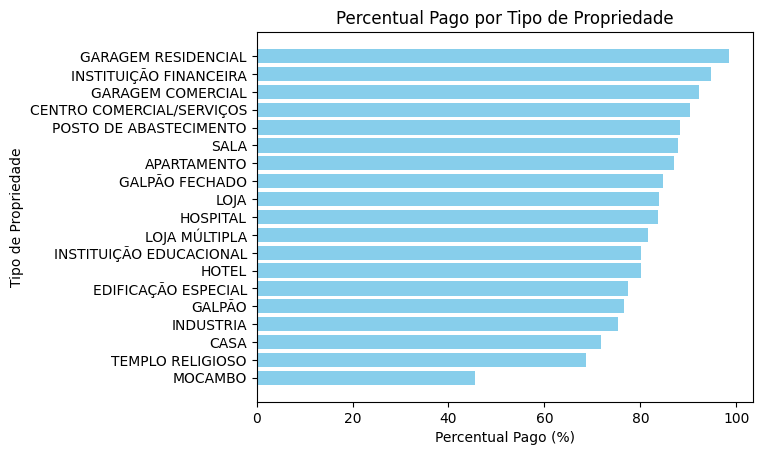

In [111]:
fig, ax = plt.subplots()
soma_tipo_propriedade = soma_tipo_propriedade.sort_values(by='percentual_pago_%', ascending=True)

ax.barh(soma_tipo_propriedade['tipo_propriedade'], soma_tipo_propriedade['percentual_pago_%'], color='skyblue')

ax.set_xlabel('Percentual Pago (%)')
ax.set_ylabel('Tipo de Propriedade')
ax.set_title('Percentual Pago por Tipo de Propriedade')

plt.show()


In [112]:
soma_tipo_propriedade.to_excel(r'C:\Users\Consultor\Documents\bases_pesquisa\bairro\tipo_propri.xlsx')

# Análise de pagamento por Bairro

In [113]:
import pandas as pd

# Supondo que 'debitos_divida' seja o nome do seu DataFrame
# e que as colunas são 'vlr_pago', 'vlr_total_dam', 'tipo_propriedade' e 'bairro'

# Calculando a porcentagem paga em relação ao total da dívida
debitos_divida['percentual_pago'] = (debitos_divida['vlr_pago'] / debitos_divida['vlr_total_dam']) * 100

# Encontrando a propriedade que mais paga para cada bairro
propriedade_mais_paga = debitos_divida.loc[debitos_divida.groupby('bairro')['percentual_pago'].idxmax()][['bairro', 'tipo_propriedade']]
propriedade_mais_paga
# # Encontrando a propriedade que menos paga para cada bairro
# propriedade_menos_paga = debitos_divida.loc[debitos_divida.groupby('bairro')['percentual_pago'].idxmin()][['bairro', 'tipo_propriedade']]

# # Renomeando as colunas para facilitar a compreensão
# propriedade_mais_paga.columns = ['bairro', 'propriedade_mais_paga']
# propriedade_menos_paga.columns = ['bairro', 'propriedade_menos_paga']

# # Exibindo o DataFrame resultante
# propriedade_mais_paga
# # propriedade_menos_paga



,bairro,tipo_propriedade
122,AFLITOS,APARTAMENTO
2,AFOGADOS,CASA
51,AGUA FRIA,CASA
298,ALTO DO MANDU,CASA
4430,ALTO JOSE BONIFACIO,CASA
...,...,...
363,TORROES,CASA
1366,TOTO,CASA
3,VARZEA,APARTAMENTO
107,VASCO DA GAMA,CASA


In [114]:
df_bai = debitos_divida[debitos_divida['bairro'] == 'BOA VIAGEM']
df_bai

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,vlr_pago,vlr_aberto,vlr_total_dam,regiao,rpa,percentual_pago


In [115]:
df_bai = debitos_divida[debitos_divida['bairro'].str.strip() == 'BRASILIA TEIMOSA']
soma_por_bairro = df_bai.groupby('tipo_propriedade').agg({
    'dam': 'count',
    'regiao': 'max',
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'
}).reset_index()
soma_por_bairro = soma_por_bairro.sort_values(by='vlr_aberto', ascending=False)
soma_por_bairro['suposto_valor_devido'] = soma_por_bairro['vlr_total_dam'] - soma_por_bairro['vlr_pago']
soma_por_bairro['percentual_pago_%'] = (soma_por_bairro['vlr_pago'] / soma_por_bairro['vlr_total_dam']) * 100
# soma_por_ano['diferenca_devido_aberto'] = soma_por_ano['suposto_valor_devido'] - soma_por_ano['vlr_aberto']

soma_por_bairro['vlr_total_dam'] = soma_por_bairro['vlr_total_dam'].apply(formatar_moeda)
soma_por_bairro['vlr_pago'] = soma_por_bairro['vlr_pago'].apply(formatar_moeda)
soma_por_bairro['vlr_aberto'] = soma_por_bairro['vlr_aberto'].apply(formatar_moeda)
soma_por_bairro['suposto_valor_devido'] = soma_por_bairro['suposto_valor_devido'].apply(formatar_moeda)


soma_por_bairro

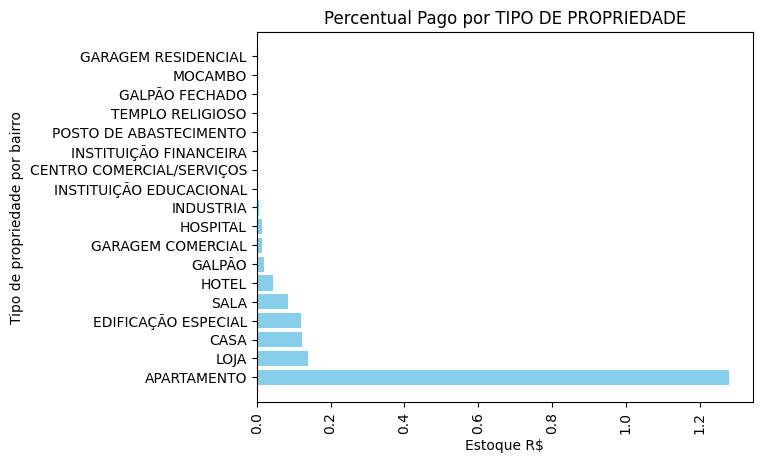

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
soma_por_bairro = soma_por_bairro.sort_values(by='vlr_aberto', ascending=False)

ax.barh(soma_por_bairro['tipo_propriedade'], soma_por_bairro['vlr_aberto'], color='skyblue')

ax.set_xlabel('Estoque R$')
ax.set_ylabel('Tipo de propriedade por bairro')
ax.set_title('Percentual Pago por TIPO DE PROPRIEDADE')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.show()


In [ ]:
df = soma_por_bairro[soma_por_bairro['bairro'].str.strip() == 'BRASILIA TEIMOSA'] # strip tira os espaços em branco
df

,bairro,dam,vlr_pago,vlr_total_dam,vlr_aberto,suposto_valor_devido,percentual_pago_%
16,BRASILIA TEIMOSA,8507,"R$ 4.319.569,56","R$ 7.373.771,81","R$ 2.623.094,44","R$ 3.054.202,25",58.58019


In [ ]:
ghu = debitos_divida[debitos_divida['ano_fato_gerador'] == 2023]
formatar_moeda(ghu['vlr_aberto'].sum())

'R$ 386.787.495,22'

In [ ]:
soma_por_bairro = debitos_divida.groupby('ano_fato_gerador').agg({
    'dam': 'count',
    # 'regiao': 'max',
    # 'rpa': 'max',
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'
}).reset_index()

soma_por_bairro['suposto_valor_devido'] = soma_por_bairro['vlr_total_dam'] - soma_por_bairro['vlr_pago']
soma_por_bairro['percentual_pago_%'] = (soma_por_bairro['vlr_pago'] / soma_por_bairro['vlr_total_dam']) * 100
soma_por_bairro['percentual_dams_%'] = (soma_por_bairro['dam'] / 2506527) *100
# soma_por_ano['diferenca_devido_aberto'] = soma_por_ano['suposto_valor_devido'] - soma_por_ano['vlr_aberto']

soma_por_bairro['vlr_total_dam'] = soma_por_bairro['vlr_total_dam'].apply(formatar_moeda)
soma_por_bairro['vlr_pago'] = soma_por_bairro['vlr_pago'].apply(formatar_moeda)
soma_por_bairro['vlr_aberto'] = soma_por_bairro['vlr_aberto'].apply(formatar_moeda)
soma_por_bairro['suposto_valor_devido'] = soma_por_bairro['suposto_valor_devido'].apply(formatar_moeda)

soma_por_bairro = soma_por_bairro.sort_values(by='ano_fato_gerador', ascending=False)
soma_por_bairro

,ano_fato_gerador,dam,vlr_pago,vlr_total_dam,vlr_aberto,suposto_valor_devido,percentual_pago_%,percentual_dams_%
42,2023.0,365695,"R$ 758.446.995,73","R$ 1.147.791.741,75","R$ 386.787.495,22","R$ 389.344.746,02",66.078799,14.589709
41,2022.0,363779,"R$ 808.151.374,94","R$ 1.117.243.859,47","R$ 303.257.450,44","R$ 309.092.484,53",72.334376,14.513269
40,2021.0,258828,"R$ 701.858.768,18","R$ 741.094.432,22","R$ 33.065.715,30","R$ 39.235.664,04",94.705713,10.326160
39,2020.0,262577,"R$ 669.055.470,48","R$ 735.771.512,69","R$ 57.672.126,60","R$ 66.716.042,21",90.932505,10.475730
38,2019.0,266244,"R$ 660.826.332,66","R$ 710.335.254,23","R$ 42.238.717,89","R$ 49.508.921,57",93.030204,10.622028
37,2018.0,240956,"R$ 539.684.801,47","R$ 599.508.310,76","R$ 52.011.933,95","R$ 59.823.509,29",90.021238,9.613142
36,2017.0,256037,"R$ 560.135.398,87","R$ 608.184.539,97","R$ 42.247.572,77","R$ 48.049.141,10",92.099579,10.214811
35,2016.0,260115,"R$ 479.910.897,50","R$ 536.545.665,66","R$ 53.586.354,55","R$ 56.634.768,16",89.444558,10.377506
34,2015.0,43600,"R$ 43.366.476,16","R$ 93.293.393,11","R$ 47.577.748,25","R$ 49.926.916,95",46.483974,1.739459
33,2014.0,29187,"R$ 20.242.574,74","R$ 38.635.426,70","R$ 16.003.655,54","R$ 18.392.851,96",52.393817,1.164440


In [ ]:
soma_por_bairro.to_excel(r'C:\Users\Consultor\Documents\bases_pesquisa\bairro.xlsx')

In [ ]:
soma_por_bairro = dams_não_pagas.groupby('bairro').agg({
    'dam': 'count',
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'
}).reset_index()
soma_por_bairro = soma_por_bairro.sort_values(by='vlr_aberto', ascending=False)
soma_por_bairro['suposto_valor_devido'] = soma_por_bairro['vlr_total_dam'] - soma_por_bairro['vlr_pago']
soma_por_bairro['percentual_pago_%'] = (soma_por_bairro['vlr_pago'] / soma_por_bairro['vlr_total_dam']) * 100
# soma_por_ano['diferenca_devido_aberto'] = soma_por_ano['suposto_valor_devido'] - soma_por_ano['vlr_aberto']

soma_por_bairro['vlr_total_dam'] = soma_por_bairro['vlr_total_dam'].apply(formatar_moeda)
soma_por_bairro['vlr_pago'] = soma_por_bairro['vlr_pago'].apply(formatar_moeda)
soma_por_bairro['vlr_aberto'] = soma_por_bairro['vlr_aberto'].apply(formatar_moeda)
soma_por_bairro['suposto_valor_devido'] = soma_por_bairro['suposto_valor_devido'].apply(formatar_moeda)


soma_por_bairro.head(10)

,bairro,dam,vlr_pago,vlr_total_dam,vlr_aberto,suposto_valor_devido,percentual_pago_%
12,BOA VIAGEM,35034,"R$ 0,00","R$ 143.712.693,80","R$ 138.230.961,91","R$ 143.712.693,80",0.0
49,IMBIRIBEIRA,15239,"R$ 0,00","R$ 48.075.993,92","R$ 47.676.440,65","R$ 48.075.993,92",0.0
91,VARZEA,21822,"R$ 0,00","R$ 71.999.841,60","R$ 40.000.996,81","R$ 71.999.841,60",0.0
13,BOA VISTA,10732,"R$ 0,00","R$ 30.373.046,77","R$ 29.596.984,75","R$ 30.373.046,77",0.0
45,IBURA,15088,"R$ 0,00","R$ 28.757.925,23","R$ 26.432.231,76","R$ 28.757.925,23",0.0
80,SANTO AMARO,7033,"R$ 0,00","R$ 27.264.610,98","R$ 26.337.866,83","R$ 27.264.610,98",0.0
70,PINA,7055,"R$ 0,00","R$ 31.836.070,82","R$ 24.952.486,68","R$ 31.836.070,82",0.0
1,AFOGADOS,11236,"R$ 0,00","R$ 38.497.016,56","R$ 24.235.818,49","R$ 38.497.016,56",0.0
31,CORDEIRO,11294,"R$ 0,00","R$ 35.885.131,11","R$ 23.118.233,30","R$ 35.885.131,11",0.0
51,IPUTINGA,10650,"R$ 0,00","R$ 47.968.800,56","R$ 22.467.832,51","R$ 47.968.800,56",0.0


In [ ]:
soma_por_bairro = debitos_divida.groupby('bairro').agg({
    'dam': 'count',
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'
}).reset_index()
soma_por_bairro = soma_por_bairro.sort_values(by='vlr_aberto', ascending=False)
soma_por_bairro['suposto_valor_devido'] = soma_por_bairro['vlr_total_dam'] - soma_por_bairro['vlr_pago']
soma_por_bairro['percentual_pago_%'] = (soma_por_bairro['vlr_pago'] / soma_por_bairro['vlr_total_dam']) * 100
# soma_por_ano['diferenca_devido_aberto'] = soma_por_ano['suposto_valor_devido'] - soma_por_ano['vlr_aberto']

soma_por_bairro['vlr_total_dam'] = soma_por_bairro['vlr_total_dam'].apply(formatar_moeda)
soma_por_bairro['vlr_pago'] = soma_por_bairro['vlr_pago'].apply(formatar_moeda)
soma_por_bairro['vlr_aberto'] = soma_por_bairro['vlr_aberto'].apply(formatar_moeda)
soma_por_bairro['suposto_valor_devido'] = soma_por_bairro['suposto_valor_devido'].apply(formatar_moeda)


soma_por_bairro.head(10)

,bairro,dam,vlr_pago,vlr_total_dam,vlr_aberto,suposto_valor_devido,percentual_pago_%
12,BOA VIAGEM,497142,"R$ 1.375.638.547,62","R$ 1.596.834.707,14","R$ 204.128.339,87","R$ 221.196.159,52",86.147836
49,IMBIRIBEIRA,97520,"R$ 278.190.007,18","R$ 344.233.835,42","R$ 62.979.193,78","R$ 66.043.828,24",80.814254
91,VARZEA,96426,"R$ 117.554.350,47","R$ 196.885.434,70","R$ 46.280.313,65","R$ 79.331.084,23",59.706982
13,BOA VISTA,96724,"R$ 212.843.269,87","R$ 257.095.205,06","R$ 39.595.970,47","R$ 44.251.935,19",82.787724
70,PINA,69474,"R$ 290.741.005,30","R$ 338.691.825,65","R$ 38.805.691,29","R$ 47.950.820,35",85.842345
80,SANTO AMARO,52918,"R$ 186.002.123,88","R$ 224.807.982,30","R$ 35.977.540,10","R$ 38.805.858,42",82.738220
42,GRACAS,84115,"R$ 249.020.925,65","R$ 285.588.753,86","R$ 31.944.014,66","R$ 36.567.828,21",87.195634
58,MADALENA,79559,"R$ 194.548.231,90","R$ 231.829.269,82","R$ 30.938.543,21","R$ 37.281.037,92",83.918753
24,CASA AMARELA,90324,"R$ 156.241.369,40","R$ 191.507.518,44","R$ 29.592.545,14","R$ 35.266.149,04",81.584979
1,AFOGADOS,48371,"R$ 80.896.112,17","R$ 125.435.995,45","R$ 29.415.236,22","R$ 44.539.883,28",64.491944


In [ ]:
df = soma_por_bairro[soma_por_bairro['bairro'].str.strip() == 'BRASILIA TEIMOSA'] # strip tira os espaços em branco
df

,bairro,dam,vlr_pago,vlr_total_dam,vlr_aberto,suposto_valor_devido,percentual_pago_%
16,BRASILIA TEIMOSA,2343,"R$ 0,00","R$ 2.753.310,75","R$ 2.372.386,52","R$ 2.753.310,75",0.0


In [ ]:
soma_por_bairro = dams_não_pagas.groupby('bairro').agg({
    'dam': 'count',
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'
}).reset_index()

soma_por_bairro['suposto_valor_devido'] = soma_por_bairro['vlr_total_dam'] - soma_por_bairro['vlr_pago']
soma_por_bairro['percentual_pago_%'] = (soma_por_bairro['vlr_pago'] / soma_por_bairro['vlr_total_dam']) * 100
# soma_por_ano['diferenca_devido_aberto'] = soma_por_ano['suposto_valor_devido'] - soma_por_ano['vlr_aberto']

soma_por_bairro = soma_por_bairro.sort_values(by='vlr_total_dam', ascending=False)
soma_por_bairro['vlr_total_dam'] = soma_por_bairro['vlr_total_dam'].apply(formatar_moeda)
soma_por_bairro['vlr_pago'] = soma_por_bairro['vlr_pago'].apply(formatar_moeda)
soma_por_bairro['vlr_aberto'] = soma_por_bairro['vlr_aberto'].apply(formatar_moeda)
soma_por_bairro['suposto_valor_devido'] = soma_por_bairro['suposto_valor_devido'].apply(formatar_moeda)


soma_por_bairro.head(10)

,bairro,dam,vlr_pago,vlr_total_dam,vlr_aberto,suposto_valor_devido,percentual_pago_%
12,BOA VIAGEM,35034,"R$ 0,00","R$ 143.712.693,80","R$ 138.230.961,91","R$ 143.712.693,80",0.0
91,VARZEA,21822,"R$ 0,00","R$ 71.999.841,60","R$ 40.000.996,81","R$ 71.999.841,60",0.0
49,IMBIRIBEIRA,15239,"R$ 0,00","R$ 48.075.993,92","R$ 47.676.440,65","R$ 48.075.993,92",0.0
51,IPUTINGA,10650,"R$ 0,00","R$ 47.968.800,56","R$ 22.467.832,51","R$ 47.968.800,56",0.0
1,AFOGADOS,11236,"R$ 0,00","R$ 38.497.016,56","R$ 24.235.818,49","R$ 38.497.016,56",0.0
31,CORDEIRO,11294,"R$ 0,00","R$ 35.885.131,11","R$ 23.118.233,30","R$ 35.885.131,11",0.0
70,PINA,7055,"R$ 0,00","R$ 31.836.070,82","R$ 24.952.486,68","R$ 31.836.070,82",0.0
13,BOA VISTA,10732,"R$ 0,00","R$ 30.373.046,77","R$ 29.596.984,75","R$ 30.373.046,77",0.0
45,IBURA,15088,"R$ 0,00","R$ 28.757.925,23","R$ 26.432.231,76","R$ 28.757.925,23",0.0
80,SANTO AMARO,7033,"R$ 0,00","R$ 27.264.610,98","R$ 26.337.866,83","R$ 27.264.610,98",0.0


---

# Análise de pagamento por edificação

In [ ]:
soma_tipo_edificacao = debitos_divida.groupby('natureza_imovel').agg({
    'dam': 'count',
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'
}).reset_index()

soma_tipo_edificacao['suposto_valor_devido'] = soma_tipo_edificacao['vlr_total_dam'] - soma_tipo_edificacao['vlr_pago']
soma_tipo_edificacao['percentual_pago_%'] = (soma_tipo_edificacao['vlr_pago'] / soma_tipo_edificacao['vlr_total_dam']) * 100
# soma_por_ano['diferenca_devido_aberto'] = soma_por_ano['suposto_valor_devido'] - soma_por_ano['vlr_aberto']

soma_tipo_edificacao['vlr_total_dam'] = soma_tipo_edificacao['vlr_total_dam'].apply(formatar_moeda)
soma_tipo_edificacao['vlr_pago'] = soma_tipo_edificacao['vlr_pago'].apply(formatar_moeda)
soma_tipo_edificacao['vlr_aberto'] = soma_tipo_edificacao['vlr_aberto'].apply(formatar_moeda)
soma_tipo_edificacao['suposto_valor_devido'] = soma_tipo_edificacao['suposto_valor_devido'].apply(formatar_moeda)

soma_tipo_edificacao = soma_tipo_edificacao.sort_values(by='percentual_pago_%', ascending=False)
soma_tipo_edificacao

,natureza_imovel,dam,vlr_pago,vlr_total_dam,vlr_aberto,suposto_valor_devido,percentual_pago_%
0,P,2398527,"R$ 5.314.436.357,69","R$ 6.422.162.474,92","R$ 1.001.145.670,64","R$ 1.107.726.117,23",82.751509
1,T,108000,"R$ 102.573.358,71","R$ 567.916.770,94","R$ 167.896.466,83","R$ 465.343.412,23",18.061336


In [ ]:
soma_tipo_edificacao.to_excel(r'C:\Users\Consultor\Documents\bases_pesquisa\bairro\edificacao.xlsx')

# análise por quantidade de pavimentos

In [ ]:
df_apto = debitos_divida[debitos_divida['tipo_propriedade'].str.strip() == 'CASA']
# df_apto = debitos_divida[debitos_divida['qtd_pavimentos'] == 38]
df_apto


,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,vlr_pago,vlr_aberto,vlr_total_dam,regiao,rpa
2,d9c9e39c4c4f8ce3,5f6ad6b7a75ce14211babe4a46e18b6d,b340af53f72ff1fdcd124eb8021f7dca,2018.0,1,89.00,1,P,CASA,CONSTRUÍDA,AFOGADOS,2008-12-11 19:54:22,691.70,0.00,691.70,SUDESTE,5
5,6503bfb9ebc00b58,a1bb4e4d67edf0e711babe4a46e18b6d,NaN,2018.0,1,349.37,1,P,CASA,CONSTRUÍDA,VARZEA,2008-12-11 19:32:57,4094.60,0.00,4094.60,OESTE,4
7,80d6391b01890bd1,78546ddc95d5a970875350beaddc7871,17c8b0a9f3f213150246e2b93c1bf25c,2022.0,2,445.24,1,P,CASA,CONSTRUÍDA,PRADO,2008-12-11 22:44:12,618.02,3566.12,4184.14,OESTE,4
8,1104680ccd4612da,a493ca5ae4cc1c23875350beaddc7871,c0a70d3ce84f401d1603ecd7ff6be21f,2022.0,1,58.20,0,P,CASA,CONSTRUÍDA,VARZEA,2013-04-08 10:18:52,0.00,437.22,437.22,OESTE,4
9,410e56039192f2a8,4324dce432ff10d6875350beaddc7871,80cc460b492e1374be91dcec7d89e48e,2022.0,1,102.69,1,P,CASA,CONSTRUÍDA,SAN MARTIN,2008-12-11 22:47:04,1119.30,0.00,1119.30,SUDESTE,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2506479,265155c7fe946608,e52aaf5972feb5b8875350beaddc7871,b54e0f860ca9aa31344d77602867ec09,2022.0,1,324.99,1,P,CASA,CONSTRUÍDA,AREIAS,2008-12-11 22:51:37,0.00,9773.08,9773.08,SUDESTE,5
2506490,3e20336a2e1b37ef,5789e043e562f61d4c1f696350fff79e,86695f7fe3b3c0a7d8b209292c0ce31d,2019.0,1,78.50,1,P,CASA,CONSTRUÍDA,SAN MARTIN,2008-12-11 22:46:39,564.40,0.00,564.40,SUDESTE,5
2506498,2c860726b83b303e,a859726e8dc4faaa90ecf5aaf6be6eb7,b6de86f22cb164381603ecd7ff6be21f,2023.0,1,125.00,1,P,CASA,CONSTRUÍDA,TEJIPIO,2008-12-11 20:28:07,0.00,1486.09,1486.09,SUDESTE,5
2506513,8b9584f0d83bf214,f3e37572c06add56e08920064611a7cf,95c52ae9e9dbd1bf344d77602867ec09,2017.0,1,54.00,1,P,CASA,CONSTRUÍDA,TORROES,2008-12-11 18:58:53,790.67,0.00,790.67,OESTE,4


In [ ]:
soma_qtd_pavimentos = df_apto.groupby('qtd_pavimentos').agg({
    'dam': 'count',
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'
}).reset_index()

soma_qtd_pavimentos['suposto_valor_devido'] = soma_qtd_pavimentos['vlr_total_dam'] - soma_qtd_pavimentos['vlr_pago']
soma_qtd_pavimentos['percentual_pago_%'] = (soma_qtd_pavimentos['vlr_pago'] / soma_qtd_pavimentos['vlr_total_dam']) * 100
# soma_por_ano['diferenca_devido_aberto'] = soma_por_ano['suposto_valor_devido'] - soma_por_ano['vlr_aberto']

soma_qtd_pavimentos['vlr_total_dam'] = soma_qtd_pavimentos['vlr_total_dam'].apply(formatar_moeda)
soma_qtd_pavimentos['vlr_pago'] = soma_qtd_pavimentos['vlr_pago'].apply(formatar_moeda)
soma_qtd_pavimentos['vlr_aberto'] = soma_qtd_pavimentos['vlr_aberto'].apply(formatar_moeda)
soma_qtd_pavimentos['suposto_valor_devido'] = soma_qtd_pavimentos['suposto_valor_devido'].apply(formatar_moeda)

soma_qtd_pavimentos = soma_qtd_pavimentos.sort_values(by='qtd_pavimentos', ascending=True)
soma_qtd_pavimentos

,qtd_pavimentos,dam,vlr_pago,vlr_total_dam,vlr_aberto,suposto_valor_devido,percentual_pago_%
0,0,16,"R$ 4.521,56","R$ 6.437,14","R$ 1.915,58","R$ 1.915,58",70.241753
1,1,517832,"R$ 527.039.205,68","R$ 750.150.133,81","R$ 187.438.531,38","R$ 223.110.928,13",70.257830
2,2,121752,"R$ 275.698.211,96","R$ 365.961.632,01","R$ 85.093.001,99","R$ 90.263.420,05",75.335278
3,3,6546,"R$ 16.387.833,08","R$ 23.586.194,72","R$ 6.957.476,56","R$ 7.198.361,64",69.480615
4,4,647,"R$ 1.703.221,23","R$ 2.421.724,68","R$ 695.634,11","R$ 718.503,45",70.330919
5,5,259,"R$ 484.403,78","R$ 614.900,62","R$ 118.550,42","R$ 130.496,84",78.777572
6,6,84,"R$ 375.171,73","R$ 402.416,60","R$ 26.230,06","R$ 27.244,87",93.229685
7,7,88,"R$ 54.394,77","R$ 78.426,56","R$ 22.940,31","R$ 24.031,79",69.357588
8,8,50,"R$ 80.012,63","R$ 95.659,44","R$ 15.518,25","R$ 15.646,81",83.643214
9,9,43,"R$ 20.214,46","R$ 27.252,67","R$ 6.924,57","R$ 7.038,21",74.174237


In [ ]:
soma_qtd_pavimentos['qtd_pavimentos'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 23, 27, 31, 34, 41, 60, 75], dtype=int64)

<Axes: >

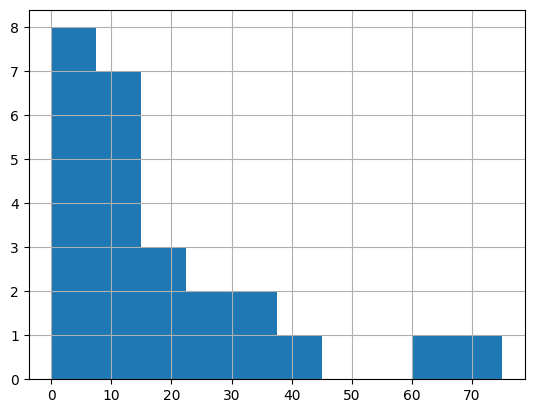

In [ ]:
soma_qtd_pavimentos['qtd_pavimentos'].hist()

# CONTRIBUINTE

In [ ]:
tbl_contribuinte = r'C:\Users\Consultor\Documents\bases_pesquisa\verificacao\tbl_contribuinte_db_2.csv'
contribuinte = pd.read_csv(tbl_contribuinte)
contribuinte

,id_contribuinte,reco_debito,reco_divida_ativa,freq_parcelamento,hist_pagamento_qtd,num_imoveis,pgt_cota_unica,hist_aberto_qtd,hist_dams_totais
0,00001a3e5b2177499daa7b7dbb545c1c,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
1,00003a695da4777aec557718ffae83ea,NaN,NaN,NaN,NaN,1,NaN,NaN,8.0
2,000046c85d18a6f7968646cfc1e328f2,NaN,NaN,NaN,NaN,1,1.0,NaN,8.0
3,0000b23be5378f1b8e79cf1867e8cc19,NaN,NaN,1.0,1.0,4,4.0,NaN,32.0
4,00014b72ca2a255bd4613fe022d53698,1.0,NaN,NaN,5.0,2,1.0,1.0,17.0
...,...,...,...,...,...,...,...,...,...
250260,ffff0e3e56845cdf1603ecd7ff6be21f,1.0,1.0,2.0,1.0,1,NaN,2.0,7.0
250261,ffff3836dbf935321bc34267b5521a39,NaN,NaN,NaN,2.0,1,NaN,NaN,8.0
250262,ffff63826b501d84d8b209292c0ce31d,1.0,NaN,NaN,NaN,2,NaN,1.0,8.0
250263,ffffc6563e67d8b38e79cf1867e8cc19,NaN,NaN,NaN,3.0,3,2.0,NaN,14.0


In [ ]:
contagem_nulos_por_coluna_contribuinte = contribuinte.isnull().sum()
total_registros_contribuinte = len(contribuinte)

porcentagem_nulos = (contagem_nulos_por_coluna_contribuinte / total_registros_contribuinte) * 100

resultado = pd.DataFrame({
    'Contagem Nulos': contagem_nulos_por_coluna_contribuinte,
    'Total Registros': total_registros_contribuinte,
    'Porcentagem Nulos (%)': porcentagem_nulos
})

resultado

,Contagem Nulos,Total Registros,Porcentagem Nulos (%)
id_contribuinte,0,250265,0.000000
reco_debito,107813,250265,43.079536
reco_divida_ativa,136310,250265,54.466266
freq_parcelamento,199736,250265,79.809802
hist_pagamento_qtd,95799,250265,38.279024
num_imoveis,0,250265,0.000000
pgt_cota_unica,184845,250265,73.859709
hist_aberto_qtd,97724,250265,39.048209
hist_dams_totais,29777,250265,11.898188


In [ ]:
analise = contribuinte[pd.isnull(contribuinte['reco_debito'])]
analise

,id_contribuinte,reco_debito,reco_divida_ativa,freq_parcelamento,hist_pagamento_qtd,num_imoveis,pgt_cota_unica,hist_aberto_qtd,hist_dams_totais
0,00001a3e5b2177499daa7b7dbb545c1c,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
1,00003a695da4777aec557718ffae83ea,NaN,NaN,NaN,NaN,1,NaN,NaN,8.0
2,000046c85d18a6f7968646cfc1e328f2,NaN,NaN,NaN,NaN,1,1.0,NaN,8.0
3,0000b23be5378f1b8e79cf1867e8cc19,NaN,NaN,1.0,1.0,4,4.0,NaN,32.0
8,00040be7a77b87e0344d77602867ec09,NaN,NaN,NaN,5.0,1,NaN,NaN,8.0
...,...,...,...,...,...,...,...,...,...
250255,fffe0ba55d8aacf4d4613fe022d53698,NaN,1.0,NaN,NaN,2,2.0,NaN,14.0
250257,fffea8c8c9cd46b4344d77602867ec09,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
250261,ffff3836dbf935321bc34267b5521a39,NaN,NaN,NaN,2.0,1,NaN,NaN,8.0
250263,ffffc6563e67d8b38e79cf1867e8cc19,NaN,NaN,NaN,3.0,3,2.0,NaN,14.0


In [ ]:
analise_deb = contribuinte[pd.isnull(contribuinte['hist_dams_totais'])]
# analise_deb = contribuinte[contribuinte['hist_dams_totais'] == 0]
analise_deb

,id_contribuinte,reco_debito,reco_divida_ativa,freq_parcelamento,hist_pagamento_qtd,num_imoveis,pgt_cota_unica,hist_aberto_qtd,hist_dams_totais
0,00001a3e5b2177499daa7b7dbb545c1c,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
11,0004c2e0021ee5ba1603ecd7ff6be21f,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
13,0005474023323741344d77602867ec09,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
21,0006bb8b85702b5f8e79cf1867e8cc19,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
28,00085f65ed4547d3be91dcec7d89e48e,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
250204,ffeee9cfe1cea735acc7ff10b872fdd2,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
250229,fff55c36236f20ba0246e2b93c1bf25c,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
250230,fff5bac58123499f344d77602867ec09,NaN,NaN,NaN,NaN,6,NaN,NaN,NaN
250243,fff9c819f917df62be248ac365d24d46,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN


---

# QUERY 3° VERSAO COM RECORTE DE 2017 - EXCLUI SITUAÇÕES CANCELADAS, PRESCRITAS, ANISTIADAS, etc...

### 24/11

In [9]:
tbl_debitos_dam_3 = r'C:\Users\Consultor\Documents\bases_pesquisa\verificacao\tbl_dam_debito_3.csv'
debitos_divida = pd.read_csv(tbl_debitos_dam_3)
debitos_divida

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,data_ultimo_pagamento,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_total_dam
0,000032f6d93a0abd,2d0abb2531f5995c19002eec9f619408,71fc88ab6bbb201c344d77602867ec09,2021.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2021-01-26,1.0,38.0,2944.10,0.0,2944.10
1,000032f6d93a0abd,393f868ac32df28f4c1f696350fff79e,71fc88ab6bbb201c344d77602867ec09,2019.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2019-01-08,1.0,38.0,2627.70,0.0,2627.70
2,000032f6d93a0abd,7b9ddc3437bacdef875350beaddc7871,71fc88ab6bbb201c344d77602867ec09,2022.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2022-01-21,1.0,38.0,3335.10,0.0,3335.10
3,000032f6d93a0abd,b114a952d31c024190ecf5aaf6be6eb7,71fc88ab6bbb201c344d77602867ec09,2023.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2023-01-23,1.0,38.0,3630.40,0.0,3630.40
4,000032f6d93a0abd,d22fdd2de1578b53e08920064611a7cf,71fc88ab6bbb201c344d77602867ec09,2017.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2017-01-26,1.0,38.0,2459.37,0.0,2459.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016992,fffee3cacb174a68,aaaca04ff960a1a5875350beaddc7871,76ab1d625a4a69d0d8b209292c0ce31d,2022.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2022-11-09,0.0,41.0,626.75,0.0,628.62
2016993,fffee3cacb174a68,c0ff37bd120cc0d619002eec9f619408,76ab1d625a4a69d0d8b209292c0ce31d,2021.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2021-11-08,0.0,41.0,568.39,0.0,570.09
2016994,fffee3cacb174a68,c8d60514c5f4b18ee08920064611a7cf,76ab1d625a4a69d0d8b209292c0ce31d,2017.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2017-11-10,0.0,41.0,503.20,0.0,503.20
2016995,fffee3cacb174a68,e46ab0c52787357611babe4a46e18b6d,76ab1d625a4a69d0d8b209292c0ce31d,2018.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2018-11-09,0.0,41.0,515.10,0.0,515.10


In [9]:
import pandas as pd

tbl_bairros = pd.read_excel(r'C:\Users\Consultor\Documents\bases_pesquisa\bairro\bairros.xlsx')
# tbl_bairros = pd.read_excel(arq_bairros)
tbl_bairros


,bairro,regiao,rpa
0,AFLITOS,NORDESTE,3A
1,AFOGADOS,SUDESTE,5
2,AGUA FRIA,NORTE,2
3,ALTO JOSE BONIFACIO,NORDESTE,3B
4,ALTO JOSE DO PINHO,NORDESTE,3B
...,...,...,...
89,TORROES,OESTE,4
90,TOTO,SUDESTE,5
91,VARZEA,OESTE,4
92,VASCO DA GAMA,NORDESTE,3B


In [12]:
debitos_divida = pd.merge(debitos_divida, tbl_bairros, on='bairro', how='left')
debitos_divida

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,data_ultimo_pagamento,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_total_dam,regiao,rpa
0,000032f6d93a0abd,2d0abb2531f5995c19002eec9f619408,71fc88ab6bbb201c344d77602867ec09,2021.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2021-01-26,1.0,38.0,2944.10,0.0,2944.10,NORDESTE,3A
1,000032f6d93a0abd,393f868ac32df28f4c1f696350fff79e,71fc88ab6bbb201c344d77602867ec09,2019.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2019-01-08,1.0,38.0,2627.70,0.0,2627.70,NORDESTE,3A
2,000032f6d93a0abd,7b9ddc3437bacdef875350beaddc7871,71fc88ab6bbb201c344d77602867ec09,2022.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2022-01-21,1.0,38.0,3335.10,0.0,3335.10,NORDESTE,3A
3,000032f6d93a0abd,b114a952d31c024190ecf5aaf6be6eb7,71fc88ab6bbb201c344d77602867ec09,2023.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2023-01-23,1.0,38.0,3630.40,0.0,3630.40,NORDESTE,3A
4,000032f6d93a0abd,d22fdd2de1578b53e08920064611a7cf,71fc88ab6bbb201c344d77602867ec09,2017.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2017-01-26,1.0,38.0,2459.37,0.0,2459.37,NORDESTE,3A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016992,fffee3cacb174a68,aaaca04ff960a1a5875350beaddc7871,76ab1d625a4a69d0d8b209292c0ce31d,2022.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2022-11-09,0.0,41.0,626.75,0.0,628.62,OESTE,4
2016993,fffee3cacb174a68,c0ff37bd120cc0d619002eec9f619408,76ab1d625a4a69d0d8b209292c0ce31d,2021.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2021-11-08,0.0,41.0,568.39,0.0,570.09,OESTE,4
2016994,fffee3cacb174a68,c8d60514c5f4b18ee08920064611a7cf,76ab1d625a4a69d0d8b209292c0ce31d,2017.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2017-11-10,0.0,41.0,503.20,0.0,503.20,OESTE,4
2016995,fffee3cacb174a68,e46ab0c52787357611babe4a46e18b6d,76ab1d625a4a69d0d8b209292c0ce31d,2018.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2018-11-09,0.0,41.0,515.10,0.0,515.10,OESTE,4


In [13]:
teste = debitos_divida.copy()
teste['data_ultimo_pagamento'] = pd.to_datetime(teste['data_ultimo_pagamento'], format='%Y-%m-%d')

teste['cota_unica'] = teste.apply(lambda row: 1 if row['data_ultimo_pagamento'].month == 1 
                                                    and row['vlr_pago'] == row['vlr_total_dam']
                                                    and row['ano_fato_gerador'] == row['data_ultimo_pagamento'].year
                                                    else 0, axis=1)
teste

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,data_ultimo_pagamento,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_total_dam,regiao,rpa
0,000032f6d93a0abd,2d0abb2531f5995c19002eec9f619408,71fc88ab6bbb201c344d77602867ec09,2021.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2021-01-26,1,38.0,2944.10,0.0,2944.10,NORDESTE,3A
1,000032f6d93a0abd,393f868ac32df28f4c1f696350fff79e,71fc88ab6bbb201c344d77602867ec09,2019.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2019-01-08,1,38.0,2627.70,0.0,2627.70,NORDESTE,3A
2,000032f6d93a0abd,7b9ddc3437bacdef875350beaddc7871,71fc88ab6bbb201c344d77602867ec09,2022.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2022-01-21,1,38.0,3335.10,0.0,3335.10,NORDESTE,3A
3,000032f6d93a0abd,b114a952d31c024190ecf5aaf6be6eb7,71fc88ab6bbb201c344d77602867ec09,2023.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2023-01-23,1,38.0,3630.40,0.0,3630.40,NORDESTE,3A
4,000032f6d93a0abd,d22fdd2de1578b53e08920064611a7cf,71fc88ab6bbb201c344d77602867ec09,2017.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2017-01-26,1,38.0,2459.37,0.0,2459.37,NORDESTE,3A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016992,fffee3cacb174a68,aaaca04ff960a1a5875350beaddc7871,76ab1d625a4a69d0d8b209292c0ce31d,2022.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2022-11-09,0,41.0,626.75,0.0,628.62,OESTE,4
2016993,fffee3cacb174a68,c0ff37bd120cc0d619002eec9f619408,76ab1d625a4a69d0d8b209292c0ce31d,2021.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2021-11-08,0,41.0,568.39,0.0,570.09,OESTE,4
2016994,fffee3cacb174a68,c8d60514c5f4b18ee08920064611a7cf,76ab1d625a4a69d0d8b209292c0ce31d,2017.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2017-11-10,0,41.0,503.20,0.0,503.20,OESTE,4
2016995,fffee3cacb174a68,e46ab0c52787357611babe4a46e18b6d,76ab1d625a4a69d0d8b209292c0ce31d,2018.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2018-11-09,0,41.0,515.10,0.0,515.10,OESTE,4


In [ ]:
ff = teste[teste['cota_unica'] == 1]
ff

In [ ]:
ff = teste.query("id_contribuinte == '71fc88ab6bbb201c344d77602867ec09'")
ff

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,data_ultimo_pagamento,vlr_pago,vlr_aberto,vlr_total_dam,regiao,rpa,cota_unica
0,000032f6d93a0abd,2d0abb2531f5995c19002eec9f619408,71fc88ab6bbb201c344d77602867ec09,2021.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2021-01-26,2944.10,0.0,2944.10,NORDESTE,3A,1
1,000032f6d93a0abd,393f868ac32df28f4c1f696350fff79e,71fc88ab6bbb201c344d77602867ec09,2019.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2019-01-08,2627.70,0.0,2627.70,NORDESTE,3A,1
2,000032f6d93a0abd,7b9ddc3437bacdef875350beaddc7871,71fc88ab6bbb201c344d77602867ec09,2022.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2022-01-21,3335.10,0.0,3335.10,NORDESTE,3A,1
3,000032f6d93a0abd,b114a952d31c024190ecf5aaf6be6eb7,71fc88ab6bbb201c344d77602867ec09,2023.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2023-01-23,3630.40,0.0,3630.40,NORDESTE,3A,1
4,000032f6d93a0abd,d22fdd2de1578b53e08920064611a7cf,71fc88ab6bbb201c344d77602867ec09,2017.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2017-01-26,2459.37,0.0,2459.37,NORDESTE,3A,1
5,000032f6d93a0abd,e6aebd3d9bee80d811babe4a46e18b6d,71fc88ab6bbb201c344d77602867ec09,2018.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2018-01-22,2519.60,0.0,2519.60,NORDESTE,3A,1
6,000032f6d93a0abd,fedb8d299d9842480ba9f03948490762,71fc88ab6bbb201c344d77602867ec09,2020.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2020-01-21,2764.50,0.0,2764.50,NORDESTE,3A,1


## Valores para se acompanhar de maneira geral

In [22]:
formatar_moeda(debitos_divida['vlr_total_dam'].sum())

'R$ 5.648.197.120,07'

In [23]:
formatar_moeda(debitos_divida['vlr_pago'].sum())

'R$ 4.772.231.272,50'

In [24]:
formatar_moeda(debitos_divida['vlr_aberto'].sum())

'R$ 834.888.260,11'

## Recorte desde 2017 e quantidade de imóveis cadastrados em cada ano

In [25]:
contagem_imoveis_por_ano = debitos_divida.groupby('ano_fato_gerador')['id_imovel'].nunique().reset_index()
contagem_imoveis_por_ano

,ano_fato_gerador,id_imovel
0,2017.0,254437
1,2018.0,240158
2,2019.0,265399
3,2020.0,260867
4,2021.0,256654
5,2022.0,361955
6,2023.0,366000


## Recorte desde 2017 e quantidade de imóveis por tipo de propriedade

In [26]:
contagem_imoveis_por_propriedade = debitos_divida.groupby('tipo_propriedade')['id_imovel'].nunique().reset_index()
contagem_imoveis_por_propriedade

,tipo_propriedade,id_imovel
0,APARTAMENTO,198577
1,CASA,104995
2,CENTRO COMERCIAL/SERVIÇOS,751
3,EDIFICAÇÃO ESPECIAL,3324
4,GALPÃO,3483
5,GALPÃO FECHADO,74
6,GARAGEM COMERCIAL,2111
7,GARAGEM RESIDENCIAL,17
8,HOSPITAL,183
9,HOTEL,580


## Recorte desde 2017 e quantidade de imóveis por bairro 

In [27]:
contagem_imoveis_por_bairro = debitos_divida.groupby('bairro')['id_imovel'].nunique().reset_index()
contagem_imoveis_por_bairro

,bairro,id_imovel
0,AFLITOS,2672
1,AFOGADOS,7926
2,AGUA FRIA,3988
3,ALTO DO MANDU,909
4,ALTO JOSE BONIFACIO,458
...,...,...
89,TORROES,1772
90,TOTO,331
91,VARZEA,15129
92,VASCO DA GAMA,2828


In [28]:
contagem_imoveis_por_bairro = contagem_imoveis_por_bairro.sort_values(by='id_imovel', ascending=False)
contagem_imoveis_por_bairro.head(15)

,bairro,id_imovel
12,BOA VIAGEM,68321
91,VARZEA,15129
13,BOA VISTA,13933
49,IMBIRIBEIRA,13784
24,CASA AMARELA,12845
31,CORDEIRO,11567
58,MADALENA,11301
42,GRACAS,11197
70,PINA,10604
51,IPUTINGA,10087


## Recorte desde 2017 e quantidade de imóveis por RPA

In [29]:
contagem_imoveis_por_rpa = debitos_divida.groupby('rpa')['id_imovel'].nunique().reset_index()
contagem_imoveis_por_rpa

,rpa,id_imovel
0,1,40581
1,2,37216
2,4,69190
3,5,44821
4,6,100806
5,3A,55397
6,3B,10649
7,6B,11204


In [30]:
total_dams = len(debitos_divida)

contagem_por_tipo = debitos_divida['tipo_propriedade'].value_counts()
percentual_por_tipo = (contagem_por_tipo / total_dams) * 100

df_contagem_percentual = pd.DataFrame({
    'Tipo de Propriedade': contagem_por_tipo.index,
    'Quantidade de DAMs': contagem_por_tipo.values,
    'Percentual em Relação ao Total': percentual_por_tipo.values
})

df_contagem_percentual

,Tipo de Propriedade,Quantidade de DAMs,Percentual em Relação ao Total
0,APARTAMENTO,1164569,57.737766
1,CASA,515825,25.573910
2,SALA,135285,6.707248
3,LOJA,93144,4.617954
4,GALPÃO,17792,0.882103
5,EDIFICAÇÃO ESPECIAL,17647,0.874915
6,GARAGEM COMERCIAL,10380,0.514626
7,CENTRO COMERCIAL/SERVIÇOS,4522,0.224195
8,HOTEL,3224,0.159842
9,INSTITUIÇÃO FINANCEIRA,2797,0.138672


In [ ]:
df_bai = debitos_divida[debitos_divida['bairro'].str.strip() == 'CAXANGA']
total_imoveis_distintos = debitos_divida['id_imovel'].nunique()
contagem_por_tipo = debitos_divida.groupby('tipo_propriedade')['id_imovel'].nunique()

percentual_por_tipo = (contagem_por_tipo / total_imoveis_distintos) * 100

df_contagem_percentual = pd.DataFrame({
    'Tipo de Propriedade': contagem_por_tipo.index,
    'Quantidade de Imóveis Únicos': contagem_por_tipo.values,
    'Percentual em Relação ao Total': percentual_por_tipo.values
})
df_contagem_percentual = df_contagem_percentual.sort_values(by='Quantidade de Imóveis Únicos', ascending=False)
df_contagem_percentual.head(10)

,Tipo de Propriedade,Quantidade de Imóveis Únicos,Percentual em Relação ao Total
0,APARTAMENTO,198171,53.637286
1,CASA,104997,28.418659
17,SALA,23977,6.489654
13,LOJA,17334,4.691649
4,GALPÃO,3484,0.942985
3,EDIFICAÇÃO ESPECIAL,3324,0.899679
6,GARAGEM COMERCIAL,2111,0.571367
2,CENTRO COMERCIAL/SERVIÇOS,751,0.203267
15,MOCAMBO,637,0.172411
9,HOTEL,579,0.156713


In [ ]:
# df_bai = debitos_divida[debitos_divida['id_contribuinte'].str.strip() == '782bfa2d6fbf04f3705035cf9aa33bac']
soma_por_bairro = debitos_divida.groupby('tipo_propriedade').agg({
    'dam': 'count',
    'id_imovel': 'nunique',
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'
}).reset_index()
soma_por_bairro = soma_por_bairro.sort_values(by='vlr_aberto', ascending=False)
soma_por_bairro['suposto_valor_devido'] = soma_por_bairro['vlr_total_dam'] - soma_por_bairro['vlr_pago']
soma_por_bairro['percentual_pago_%'] = (soma_por_bairro['vlr_pago'] / soma_por_bairro['vlr_total_dam']) * 100
soma_por_bairro['ticket_medio'] = (soma_por_bairro['vlr_total_dam'] / soma_por_bairro['id_imovel'])


soma_por_bairro['ticket_medio'] = soma_por_bairro['ticket_medio'].apply(formatar_moeda)
soma_por_bairro['vlr_total_dam'] = soma_por_bairro['vlr_total_dam'].apply(formatar_moeda)
soma_por_bairro['vlr_pago'] = soma_por_bairro['vlr_pago'].apply(formatar_moeda)
soma_por_bairro['vlr_aberto'] = soma_por_bairro['vlr_aberto'].apply(formatar_moeda)
soma_por_bairro['suposto_valor_devido'] = soma_por_bairro['suposto_valor_devido'].apply(formatar_moeda)

soma_por_bairro

,tipo_propriedade,dam,id_imovel,vlr_pago,vlr_total_dam,vlr_aberto,suposto_valor_devido,percentual_pago_%,ticket_medio
0,APARTAMENTO,1163063,198171,"R$ 2.225.888.118,63","R$ 2.542.812.556,54","R$ 296.703.653,65","R$ 316.924.437,91",87.536461,"R$ 12.831,41"
1,CASA,514556,104997,"R$ 668.439.918,14","R$ 912.977.048,43","R$ 237.891.629,86","R$ 244.537.130,29",73.215413,"R$ 8.695,27"
13,LOJA,92777,17334,"R$ 543.659.501,68","R$ 640.951.089,58","R$ 93.928.918,35","R$ 97.291.587,90",84.820747,"R$ 36.976,53"
3,EDIFICAÇÃO ESPECIAL,17494,3324,"R$ 319.680.935,53","R$ 402.410.503,93","R$ 79.984.095,75","R$ 82.729.568,40",79.441499,"R$ 121.062,13"
4,GALPÃO,17668,3484,"R$ 173.147.404,44","R$ 222.008.592,62","R$ 47.328.508,42","R$ 48.861.188,18",77.991308,"R$ 63.722,33"
17,SALA,135129,23977,"R$ 290.784.380,63","R$ 330.017.114,56","R$ 36.945.577,09","R$ 39.232.733,93",88.111909,"R$ 13.763,90"
10,INDUSTRIA,1857,360,"R$ 73.519.364,73","R$ 93.662.027,57","R$ 19.395.557,17","R$ 20.142.662,84",78.494313,"R$ 260.172,30"
9,HOTEL,3277,579,"R$ 48.477.950,15","R$ 60.313.094,60","R$ 11.157.942,14","R$ 11.835.144,45",80.377156,"R$ 104.167,69"
8,HOSPITAL,994,182,"R$ 57.395.275,38","R$ 67.365.630,54","R$ 9.504.046,25","R$ 9.970.355,16",85.199641,"R$ 370.140,83"
6,GARAGEM COMERCIAL,10382,2111,"R$ 66.727.156,29","R$ 72.454.382,00","R$ 5.557.759,46","R$ 5.727.225,71",92.095405,"R$ 34.322,30"


In [31]:
import pandas as pd

# Supondo que 'debitos_divida' seja o nome do seu DataFrame
df_temp = debitos_divida.copy()

# Substituindo caracteres não numéricos em 'vlr_aberto' e convertendo para float
df_temp['vlr_aberto'] = df_temp['vlr_aberto'].replace('[\D]', '', regex=True)

# Filtrando o DataFrame para vlr_aberto maior que 0
df_temp = df_temp[df_temp['vlr_aberto'] > 0]

# Agrupando por bairro e tipo_propriedade, somando os valores de vlr_aberto
soma_por_tipo_bairro = df_temp.groupby(['bairro', 'tipo_propriedade'])['vlr_aberto'].sum().reset_index()

idx_max = soma_por_tipo_bairro.groupby('bairro')['vlr_aberto'].idxmax()

max_devidos = soma_por_tipo_bairro.loc[idx_max, ['bairro', 'tipo_propriedade', 'vlr_aberto']]
max_devidos.columns = ['Bairro', 'Tipo de Propriedade', 'Valor Devido']
max_devidos['Valor Devido'] = max_devidos['Valor Devido'].apply(formatar_moeda)

max_devidos


,Bairro,Tipo de Propriedade,Valor Devido
0,AFLITOS,APARTAMENTO,"R$ 3.879.332,80"
6,AFOGADOS,CASA,"R$ 11.245.874,22"
19,AGUA FRIA,CASA,"R$ 3.199.031,08"
28,ALTO DO MANDU,CASA,"R$ 1.428.819,22"
36,ALTO JOSE BONIFACIO,CASA,"R$ 351.020,53"
...,...,...,...
795,TORROES,CASA,"R$ 3.081.349,93"
807,TOTO,CASA,"R$ 189.333,63"
811,VARZEA,CASA,"R$ 7.917.077,39"
825,VASCO DA GAMA,CASA,"R$ 2.145.479,88"


In [ ]:
aux = max_devidos[max_devidos['Bairro'].str.strip() == 'CAXANGA' ]
aux

,Bairro,Tipo de Propriedade,Valor Devido
247,CAXANGA,CASA,"R$ 3.150.411,12"


In [ ]:
df_temp = debitos_divida.copy()

df_temp = df_temp.dropna(subset=['id_imovel'])
contagem_por_tipo_bairro = df_temp.groupby(['bairro', 'tipo_propriedade'])['id_imovel'].nunique().reset_index()
idx_max = contagem_por_tipo_bairro.groupby('bairro')['id_imovel'].idxmax()

tipo_propriedade_mais_imoveis = contagem_por_tipo_bairro.loc[idx_max, ['bairro', 'tipo_propriedade', 'id_imovel']]
tipo_propriedade_mais_imoveis.columns = ['Bairro', 'Tipo de Propriedade', 'Quantidade de Imóveis']

tipo_propriedade_mais_imoveis


,Bairro,Tipo de Propriedade,Quantidade de Imóveis
0,AFLITOS,APARTAMENTO,2159
10,AFOGADOS,CASA,5112
24,AGUA FRIA,CASA,2770
34,ALTO DO MANDU,CASA,836
42,ALTO JOSE BONIFACIO,CASA,394
...,...,...,...
919,TORROES,CASA,1369
932,TOTO,CASA,274
936,VARZEA,APARTAMENTO,8456
953,VASCO DA GAMA,CASA,1957


In [ ]:
aux = tipo_propriedade_mais_imoveis[tipo_propriedade_mais_imoveis['Bairro'].str.strip() == 'CAXANGA' ]
aux

,Bairro,Tipo de Propriedade,Quantidade de Imóveis
268,CAXANGA,APARTAMENTO,1232


In [ ]:
tipo_propriedade_mais_imoveis.to_excel(r'C:\Users\Consultor\Documents\bases_pesquisa\bairro\mais_imovel_bairro.xlsx')

In [ ]:
aux = max_devidos[max_devidos['Bairro'].str.strip() == 'BRASILIA TEIMOSA']
aux

,Bairro,Tipo de Propriedade,Valor Devido
160,BRASILIA TEIMOSA,CASA,"R$ 1.580.743,67"


In [ ]:
soma_por_ano = debitos_divida.groupby('ano_fato_gerador').agg({
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'
}).reset_index()

soma_por_ano['suposto_valor_devido'] = soma_por_ano['vlr_total_dam'] - soma_por_ano['vlr_pago']

soma_por_ano['vlr_total_dam'] = soma_por_ano['vlr_total_dam'].apply(formatar_moeda)
soma_por_ano['vlr_pago'] = soma_por_ano['vlr_pago'].apply(formatar_moeda)
soma_por_ano['vlr_aberto'] = soma_por_ano['vlr_aberto'].apply(formatar_moeda)
soma_por_ano['suposto_valor_devido'] = soma_por_ano['suposto_valor_devido'].apply(formatar_moeda)

soma_por_ano

,ano_fato_gerador,vlr_pago,vlr_total_dam,vlr_aberto,suposto_valor_devido
0,2017.0,"R$ 560.135.398,87","R$ 606.564.614,03","R$ 42.247.572,77","R$ 46.429.215,16"
1,2018.0,"R$ 539.684.801,47","R$ 598.564.499,08","R$ 52.011.933,95","R$ 58.879.697,61"
2,2019.0,"R$ 660.826.332,66","R$ 709.976.597,67","R$ 42.238.717,89","R$ 49.150.265,01"
3,2020.0,"R$ 669.055.470,48","R$ 735.333.087,38","R$ 57.672.126,60","R$ 66.277.616,90"
4,2021.0,"R$ 701.858.768,18","R$ 740.674.355,13","R$ 33.065.715,30","R$ 38.815.586,95"
5,2022.0,"R$ 808.151.374,94","R$ 1.117.144.637,21","R$ 303.257.450,44","R$ 308.993.262,27"
6,2023.0,"R$ 758.446.995,73","R$ 1.147.730.973,04","R$ 386.794.003,89","R$ 389.283.977,31"


In [40]:
dams_pagas = debitos_divida[(debitos_divida['vlr_pago'] == debitos_divida['vlr_total_dam'])]
dams_pagas

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,...,atualizacao_cadastro,data_ultimo_pagamento,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_total_dam,regiao,rpa,tamanho_imovel
0,000032f6d93a0abd,2d0abb2531f5995c19002eec9f619408,71fc88ab6bbb201c344d77602867ec09,2021.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 22:19:53,2021-01-26,1.0,38.0,2944.10,0.0,2944.10,NORDESTE,3A,GRANDE
1,000032f6d93a0abd,393f868ac32df28f4c1f696350fff79e,71fc88ab6bbb201c344d77602867ec09,2019.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 22:19:53,2019-01-08,1.0,38.0,2627.70,0.0,2627.70,NORDESTE,3A,GRANDE
2,000032f6d93a0abd,7b9ddc3437bacdef875350beaddc7871,71fc88ab6bbb201c344d77602867ec09,2022.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 22:19:53,2022-01-21,1.0,38.0,3335.10,0.0,3335.10,NORDESTE,3A,GRANDE
3,000032f6d93a0abd,b114a952d31c024190ecf5aaf6be6eb7,71fc88ab6bbb201c344d77602867ec09,2023.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 22:19:53,2023-01-23,1.0,38.0,3630.40,0.0,3630.40,NORDESTE,3A,GRANDE
4,000032f6d93a0abd,d22fdd2de1578b53e08920064611a7cf,71fc88ab6bbb201c344d77602867ec09,2017.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 22:19:53,2017-01-26,1.0,38.0,2459.37,0.0,2459.37,NORDESTE,3A,GRANDE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016989,fffedcc05be9beaa,d8404a4c094e08270ba9f03948490762,f995d12c76cce604d65600efcabb160f,2020.0,1,100.48,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 19:14:38,2020-01-27,1.0,22.0,1455.10,0.0,1455.10,OESTE,4,GRANDE
2016990,fffee3cacb174a68,2827aeded01bfeae0ba9f03948490762,76ab1d625a4a69d0d8b209292c0ce31d,2020.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 19:34:01,2020-11-09,0.0,41.0,547.30,0.0,547.30,OESTE,4,MEDIO
2016991,fffee3cacb174a68,a8033c6d8d84fa6c4c1f696350fff79e,76ab1d625a4a69d0d8b209292c0ce31d,2019.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 19:34:01,2019-11-11,0.0,41.0,535.60,0.0,535.60,OESTE,4,MEDIO
2016994,fffee3cacb174a68,c8d60514c5f4b18ee08920064611a7cf,76ab1d625a4a69d0d8b209292c0ce31d,2017.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 19:34:01,2017-11-10,0.0,41.0,503.20,0.0,503.20,OESTE,4,MEDIO


In [35]:
dams_não_pagas = debitos_divida[(debitos_divida['vlr_pago'] == 0)]
dams_não_pagas

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,...,atualizacao_cadastro,data_ultimo_pagamento,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_total_dam,regiao,rpa,tamanho_imovel
21,0000c599ab737fa1,52a09679bbf7a68690ecf5aaf6be6eb7,4c375f5fe6f11e99cd124eb8021f7dca,2023.0,1,125.00,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 23:02:50,2023-03-15,0.0,51.0,0.0,1587.40,1587.40,SUL,6,GRANDE
29,0000d8e55e83b975,85ebc70094dc08ab90ecf5aaf6be6eb7,62067d8c0d1754a5ec24828071529570,2023.0,1,144.62,1,P,APARTAMENTO,CONSTRUÍDA,...,2017-01-04 16:10:45,2023-03-15,0.0,6.0,0.0,3654.19,3654.19,SUL,6,GRANDE
31,0000e13a7d8d7537,5e6259444ed23a59875350beaddc7871,NaN,2022.0,1,61.20,1,P,CASA,CONSTRUÍDA,...,2008-12-11 19:44:26,2022-09-18,0.0,23.0,0.0,605.79,605.79,SUDESTE,5,PEQUENO
32,0000e13a7d8d7537,e8bdb0fb9c920c1990ecf5aaf6be6eb7,NaN,2023.0,1,61.20,1,P,CASA,CONSTRUÍDA,...,2008-12-11 19:44:26,2023-08-20,0.0,23.0,0.0,468.95,468.95,SUDESTE,5,PEQUENO
40,0001114d1e8d6c46,1f0e5e6ad9dc827c90ecf5aaf6be6eb7,a4f9a6068e4b0327cd124eb8021f7dca,2023.0,1,226.50,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 22:44:34,2023-03-15,0.0,41.0,0.0,2746.92,2746.92,OESTE,4,GRANDE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016910,fffc9bf7c06bb455,20b7997d26912e3290ecf5aaf6be6eb7,9568f174fef9aa1991e796325bc06316,2023.0,1,NaN,0,T,NaN,NaN,...,2008-12-11 21:35:01,2023-03-15,0.0,74.0,0.0,2096.94,2096.94,SUL,6,INDEFINIDO
2016911,fffc9bf7c06bb455,7dc1a48a6740055d875350beaddc7871,9568f174fef9aa1991e796325bc06316,2022.0,1,NaN,0,T,NaN,NaN,...,2008-12-11 21:35:01,2022-12-16,0.0,74.0,0.0,2353.49,2353.49,SUL,6,INDEFINIDO
2016978,fffeb78fd42d2624,41a5e64155e3823119002eec9f619408,a2fc71bfb0f9783b0cac38934feb21df,2021.0,1,105.30,1,P,CASA,CONSTRUÍDA,...,2008-12-11 20:17:31,2021-12-16,0.0,70.0,0.0,3014.23,3014.23,SUDESTE,5,MEDIO
2016980,fffeb78fd42d2624,7ac97fd89a7907c490ecf5aaf6be6eb7,a2fc71bfb0f9783b0cac38934feb21df,2023.0,1,105.30,1,P,CASA,CONSTRUÍDA,...,2008-12-11 20:17:31,2023-03-15,0.0,70.0,0.0,3036.08,3036.08,SUDESTE,5,MEDIO


---

In [53]:
idade_imo_npg = dams_não_pagas.query('idade_imovel > 50')
idade_imo_npg

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,...,atualizacao_cadastro,data_ultimo_pagamento,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_total_dam,regiao,rpa,tamanho_imovel
21,0000c599ab737fa1,52a09679bbf7a68690ecf5aaf6be6eb7,4c375f5fe6f11e99cd124eb8021f7dca,2023.0,1,125.0,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 23:02:50,2023-03-15,0.0,51.0,0.0,1587.40,1587.40,SUL,6,GRANDE
250,0008247eb9e0bfe2,c0f4455cc41f19854c1f696350fff79e,4500978cc5128e71344d77602867ec09,2019.0,1,46.0,1,P,CASA,CONSTRUÍDA,...,2008-12-11 22:49:45,2021-02-08,0.0,61.0,0.0,284.20,284.20,SUDESTE,5,PEQUENO
260,0008b3d6b68a6855,754b5a3875adb2110ba9f03948490762,3a6c77ffe2658574344d77602867ec09,2020.0,2,71.5,1,P,CASA,CONSTRUÍDA,...,2008-12-11 17:06:11,2022-06-29,0.0,84.0,0.0,2030.70,2030.70,CENTRO,1,PEQUENO
261,0008b3d6b68a6855,9b4e99d924ab374111babe4a46e18b6d,3a6c77ffe2658574344d77602867ec09,2018.0,2,71.5,1,P,CASA,CONSTRUÍDA,...,2008-12-11 17:06:11,2021-06-28,0.0,84.0,0.0,2146.16,2146.16,CENTRO,1,PEQUENO
264,0008b3d6b68a6855,e7a86e73da99d2ad4c1f696350fff79e,3a6c77ffe2658574344d77602867ec09,2019.0,2,71.5,1,P,CASA,CONSTRUÍDA,...,2008-12-11 17:06:11,2021-06-28,0.0,84.0,0.0,1969.04,1969.04,CENTRO,1,PEQUENO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016910,fffc9bf7c06bb455,20b7997d26912e3290ecf5aaf6be6eb7,9568f174fef9aa1991e796325bc06316,2023.0,1,NaN,0,T,NaN,NaN,...,2008-12-11 21:35:01,2023-03-15,0.0,74.0,0.0,2096.94,2096.94,SUL,6,INDEFINIDO
2016911,fffc9bf7c06bb455,7dc1a48a6740055d875350beaddc7871,9568f174fef9aa1991e796325bc06316,2022.0,1,NaN,0,T,NaN,NaN,...,2008-12-11 21:35:01,2022-12-16,0.0,74.0,0.0,2353.49,2353.49,SUL,6,INDEFINIDO
2016978,fffeb78fd42d2624,41a5e64155e3823119002eec9f619408,a2fc71bfb0f9783b0cac38934feb21df,2021.0,1,105.3,1,P,CASA,CONSTRUÍDA,...,2008-12-11 20:17:31,2021-12-16,0.0,70.0,0.0,3014.23,3014.23,SUDESTE,5,MEDIO
2016980,fffeb78fd42d2624,7ac97fd89a7907c490ecf5aaf6be6eb7,a2fc71bfb0f9783b0cac38934feb21df,2023.0,1,105.3,1,P,CASA,CONSTRUÍDA,...,2008-12-11 20:17:31,2023-03-15,0.0,70.0,0.0,3036.08,3036.08,SUDESTE,5,MEDIO


In [54]:
idade_imo_npg_2 = dams_não_pagas.query('idade_imovel > 20 & idade_imovel < 50')
idade_imo_npg_2

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,...,atualizacao_cadastro,data_ultimo_pagamento,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_total_dam,regiao,rpa,tamanho_imovel
31,0000e13a7d8d7537,5e6259444ed23a59875350beaddc7871,NaN,2022.0,1,61.2,1,P,CASA,CONSTRUÍDA,...,2008-12-11 19:44:26,2022-09-18,0.0,23.0,0.0,605.79,605.79,SUDESTE,5,PEQUENO
32,0000e13a7d8d7537,e8bdb0fb9c920c1990ecf5aaf6be6eb7,NaN,2023.0,1,61.2,1,P,CASA,CONSTRUÍDA,...,2008-12-11 19:44:26,2023-08-20,0.0,23.0,0.0,468.95,468.95,SUDESTE,5,PEQUENO
40,0001114d1e8d6c46,1f0e5e6ad9dc827c90ecf5aaf6be6eb7,a4f9a6068e4b0327cd124eb8021f7dca,2023.0,1,226.5,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 22:44:34,2023-03-15,0.0,41.0,0.0,2746.92,2746.92,OESTE,4,GRANDE
54,0001cc5c538504ce,12ecdf9fd9d4a4ad875350beaddc7871,fc7913336ff7c55a0246e2b93c1bf25c,2022.0,1,48.0,0,P,CASA,CONSTRUÍDA,...,2008-12-11 20:35:13,2022-06-16,0.0,35.0,0.0,333.27,333.27,SUL,6B,PEQUENO
55,0001cc5c538504ce,9d9ddb756f35d29290ecf5aaf6be6eb7,fc7913336ff7c55a0246e2b93c1bf25c,2023.0,1,48.0,0,P,CASA,CONSTRUÍDA,...,2008-12-11 20:35:13,2023-06-16,0.0,35.0,0.0,303.62,303.62,SUL,6B,PEQUENO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016863,fffbf81ab1d18c5a,edef0baa5e8fb250875350beaddc7871,a1458e36bd8b42e90246e2b93c1bf25c,2022.0,1,NaN,1,T,NaN,NaN,...,2008-12-11 19:02:48,2022-12-16,0.0,40.0,0.0,1683.61,1683.61,OESTE,4,INDEFINIDO
2016887,fffc4bd7fd3b6bf8,a0e3c19fe06ee6ea875350beaddc7871,b4898c74b1c97c23ec24828071529570,2022.0,1,111.2,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 22:42:36,2022-12-16,0.0,31.0,0.0,1583.45,1583.45,OESTE,4,GRANDE
2016888,fffc4bd7fd3b6bf8,a3ae66a6ecba37cf90ecf5aaf6be6eb7,b4898c74b1c97c23ec24828071529570,2023.0,1,111.2,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 22:42:36,2023-03-15,0.0,31.0,0.0,1406.76,1406.76,OESTE,4,GRANDE
2016891,fffc76dc487eee31,149af1d16e56d2d2875350beaddc7871,878ed023fa473bede000edc2a2086273,2022.0,1,45.0,1,P,CASA,CONSTRUÍDA,...,2008-12-11 20:38:40,2022-06-16,0.0,41.0,0.0,331.06,331.06,SUL,6B,PEQUENO


In [144]:
idade_imo_npg_3 = dams_não_pagas.query('idade_imovel > 0 & idade_imovel <= 20')
idade_imo_npg_3

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,...,atualizacao_cadastro,data_ultimo_pagamento,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_total_dam,regiao,rpa,tamanho_imovel
29,0000d8e55e83b975,85ebc70094dc08ab90ecf5aaf6be6eb7,62067d8c0d1754a5ec24828071529570,2023.0,1,144.62,1,P,APARTAMENTO,CONSTRUÍDA,...,2017-01-04 16:10:45,2023-03-15,0.0,6.0,0.0,3654.19,3654.19,SUL,6,GRANDE
69,0002644d836d4141,16f48327d3df0bafe08920064611a7cf,86dc90f9838b01b075234379af146d63,2017.0,2,75.66,1,P,CASA,CONSTRUÍDA,...,2013-04-23 08:53:53,2018-02-22,0.0,10.0,0.0,914.21,914.21,OESTE,4,PEQUENO
70,0002644d836d4141,de98a76672d6017990ecf5aaf6be6eb7,86dc90f9838b01b075234379af146d63,2023.0,2,75.66,1,P,CASA,CONSTRUÍDA,...,2013-04-23 08:53:53,2023-03-15,0.0,10.0,0.0,1098.52,1098.52,OESTE,4,PEQUENO
71,0002644d836d4141,e122c0d8a5a8907e875350beaddc7871,86dc90f9838b01b075234379af146d63,2022.0,2,75.66,1,P,CASA,CONSTRUÍDA,...,2013-04-23 08:53:53,2022-12-16,0.0,10.0,0.0,1234.33,1234.33,OESTE,4,PEQUENO
118,0003a9ec5f8daca4,14013d755ef16d73875350beaddc7871,4bca0b652fbd99ab6ffd495caaf8b576,2022.0,1,74.07,1,P,APARTAMENTO,CONSTRUÍDA,...,2016-01-27 12:43:51,2022-12-16,0.0,7.0,0.0,1930.42,1930.42,SUDESTE,5,MEDIO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016714,fff82f34978ce735,5a5dc3323fbf0d6e19002eec9f619408,987e7ed359f71c12a5436b6559991937,2021.0,1,115.52,1,P,APARTAMENTO,CONSTRUÍDA,...,2017-01-04 15:58:08,2021-03-16,0.0,6.0,0.0,2041.92,2041.92,SUL,6,GRANDE
2016753,fff9aef52a566944,41edf9934f7bfd600ba9f03948490762,d3537be8363acab0d4613fe022d53698,2020.0,1,95.02,1,P,APARTAMENTO,CONSTRUÍDA,...,2018-02-06 12:11:00,2021-01-11,0.0,5.0,0.0,1210.42,1210.42,SUDESTE,5,MEDIO
2016755,fff9aef52a566944,561d50bd8262c45f875350beaddc7871,d3537be8363acab0d4613fe022d53698,2022.0,1,95.02,1,P,APARTAMENTO,CONSTRUÍDA,...,2018-02-06 12:11:00,2023-10-26,0.0,5.0,0.0,1909.05,1909.05,SUDESTE,5,MEDIO
2016757,fff9aef52a566944,cb98ca214da2125b90ecf5aaf6be6eb7,d3537be8363acab0d4613fe022d53698,2023.0,1,95.02,1,P,APARTAMENTO,CONSTRUÍDA,...,2018-02-06 12:11:00,2023-03-15,0.0,5.0,0.0,1869.64,1869.64,SUDESTE,5,MEDIO


In [56]:
idade_imo_pg = dams_pagas.query('idade_imovel > 50')
idade_imo_pg

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,...,atualizacao_cadastro,data_ultimo_pagamento,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_total_dam,regiao,rpa,tamanho_imovel
19,0000c599ab737fa1,35a5f340f67738f419002eec9f619408,4c375f5fe6f11e99cd124eb8021f7dca,2021.0,1,125.00,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 23:02:50,2021-02-09,1.0,51.0,1112.60,0.0,1112.60,SUL,6,GRANDE
20,0000c599ab737fa1,491bd50714736f724c1f696350fff79e,4c375f5fe6f11e99cd124eb8021f7dca,2019.0,1,125.00,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 23:02:50,2019-02-07,1.0,51.0,1055.40,0.0,1055.40,SUL,6,GRANDE
22,0000c599ab737fa1,8360ed1065c0c9b611babe4a46e18b6d,4c375f5fe6f11e99cd124eb8021f7dca,2018.0,1,125.00,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 23:02:50,2018-02-07,1.0,51.0,1014.70,0.0,1014.70,SUL,6,GRANDE
23,0000c599ab737fa1,8b7cc9eb1c4ce7c5e08920064611a7cf,4c375f5fe6f11e99cd124eb8021f7dca,2017.0,1,125.00,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 23:02:50,2017-02-03,1.0,51.0,993.01,0.0,993.01,SUL,6,GRANDE
24,0000c599ab737fa1,db7cb92fb806efc0875350beaddc7871,4c375f5fe6f11e99cd124eb8021f7dca,2022.0,1,125.00,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 23:02:50,2022-01-31,1.0,51.0,1224.40,0.0,1224.40,SUL,6,GRANDE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016957,fffe4c8195b51bd9,3e718852f71fb202875350beaddc7871,e1e67d02f4d9b02a344d77602867ec09,2022.0,1,40.66,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 22:25:02,2022-02-07,1.0,62.0,247.68,0.0,247.68,CENTRO,1,PEQUENO
2016958,fffe4c8195b51bd9,b0d8b8f697a345f40ba9f03948490762,e1e67d02f4d9b02a344d77602867ec09,2020.0,1,40.66,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 22:25:02,2020-02-03,1.0,62.0,217.52,0.0,217.52,CENTRO,1,PEQUENO
2016959,fffe4c8195b51bd9,dd68a79a6a4782c5e08920064611a7cf,e1e67d02f4d9b02a344d77602867ec09,2017.0,1,40.66,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 22:25:02,2017-02-08,1.0,62.0,203.35,0.0,203.35,CENTRO,1,PEQUENO
2016961,fffe4c8195b51bd9,ef967fb465287f0190ecf5aaf6be6eb7,e1e67d02f4d9b02a344d77602867ec09,2023.0,1,40.66,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 22:25:02,2023-02-03,1.0,62.0,263.68,0.0,263.68,CENTRO,1,PEQUENO


In [57]:
idade_imo_pg_2 = dams_pagas.query('idade_imovel > 20 & idade_imovel < 50')
idade_imo_pg_2

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,...,atualizacao_cadastro,data_ultimo_pagamento,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_total_dam,regiao,rpa,tamanho_imovel
0,000032f6d93a0abd,2d0abb2531f5995c19002eec9f619408,71fc88ab6bbb201c344d77602867ec09,2021.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 22:19:53,2021-01-26,1.0,38.0,2944.10,0.0,2944.10,NORDESTE,3A,GRANDE
1,000032f6d93a0abd,393f868ac32df28f4c1f696350fff79e,71fc88ab6bbb201c344d77602867ec09,2019.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 22:19:53,2019-01-08,1.0,38.0,2627.70,0.0,2627.70,NORDESTE,3A,GRANDE
2,000032f6d93a0abd,7b9ddc3437bacdef875350beaddc7871,71fc88ab6bbb201c344d77602867ec09,2022.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 22:19:53,2022-01-21,1.0,38.0,3335.10,0.0,3335.10,NORDESTE,3A,GRANDE
3,000032f6d93a0abd,b114a952d31c024190ecf5aaf6be6eb7,71fc88ab6bbb201c344d77602867ec09,2023.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 22:19:53,2023-01-23,1.0,38.0,3630.40,0.0,3630.40,NORDESTE,3A,GRANDE
4,000032f6d93a0abd,d22fdd2de1578b53e08920064611a7cf,71fc88ab6bbb201c344d77602867ec09,2017.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 22:19:53,2017-01-26,1.0,38.0,2459.37,0.0,2459.37,NORDESTE,3A,GRANDE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016989,fffedcc05be9beaa,d8404a4c094e08270ba9f03948490762,f995d12c76cce604d65600efcabb160f,2020.0,1,100.48,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 19:14:38,2020-01-27,1.0,22.0,1455.10,0.0,1455.10,OESTE,4,GRANDE
2016990,fffee3cacb174a68,2827aeded01bfeae0ba9f03948490762,76ab1d625a4a69d0d8b209292c0ce31d,2020.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 19:34:01,2020-11-09,0.0,41.0,547.30,0.0,547.30,OESTE,4,MEDIO
2016991,fffee3cacb174a68,a8033c6d8d84fa6c4c1f696350fff79e,76ab1d625a4a69d0d8b209292c0ce31d,2019.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 19:34:01,2019-11-11,0.0,41.0,535.60,0.0,535.60,OESTE,4,MEDIO
2016994,fffee3cacb174a68,c8d60514c5f4b18ee08920064611a7cf,76ab1d625a4a69d0d8b209292c0ce31d,2017.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 19:34:01,2017-11-10,0.0,41.0,503.20,0.0,503.20,OESTE,4,MEDIO


In [58]:
idade_imo_pg_3 = dams_pagas.query('idade_imovel > 0 & idade_imovel < 20')
idade_imo_pg_3

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,...,atualizacao_cadastro,data_ultimo_pagamento,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_total_dam,regiao,rpa,tamanho_imovel
13,0000a2cbd951c1ca,08de56599e513fba11babe4a46e18b6d,c2357fdb65f5cbed8e79cf1867e8cc19,2018.0,1,174.01,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 21:52:00,2018-01-19,1.0,19.0,2698.70,0.0,2698.70,SUL,6,GRANDE
15,0000a2cbd951c1ca,b11c994dea432c034c1f696350fff79e,c2357fdb65f5cbed8e79cf1867e8cc19,2019.0,1,174.01,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 21:52:00,2019-01-16,1.0,19.0,3098.40,0.0,3098.40,SUL,6,GRANDE
16,0000a2cbd951c1ca,c443544fa11703410ba9f03948490762,c2357fdb65f5cbed8e79cf1867e8cc19,2020.0,1,174.01,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 21:52:00,2020-11-10,0.0,19.0,3168.60,0.0,3168.60,SUL,6,GRANDE
17,0000a2cbd951c1ca,ce1496e9eeece7dfe08920064611a7cf,c2357fdb65f5cbed8e79cf1867e8cc19,2017.0,1,174.01,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 21:52:00,2017-01-25,1.0,19.0,2633.80,0.0,2633.80,SUL,6,GRANDE
18,0000a2cbd951c1ca,d3616069bbb7c23b90ecf5aaf6be6eb7,c2357fdb65f5cbed8e79cf1867e8cc19,2023.0,1,174.01,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 21:52:00,2023-11-10,0.0,19.0,3844.20,0.0,3844.20,SUL,6,GRANDE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016931,fffd8973eae22105,d71425c6a4b4c3b819002eec9f619408,2af853905b920a011ed8b02446055311,2021.0,1,175.55,1,P,APARTAMENTO,CONSTRUÍDA,...,2012-01-12 14:42:44,2021-02-10,1.0,11.0,3567.30,0.0,3567.30,SUL,6,GRANDE
2016953,fffe35404991181f,5e8b4705b3998d50875350beaddc7871,eaf1b50bdb8acc5dbc4e99972848013d,2022.0,1,265.25,1,P,APARTAMENTO,CONSTRUÍDA,...,2019-08-27 09:52:09,2022-01-06,1.0,4.0,7479.60,0.0,7479.60,SUL,6,GRANDE
2016954,fffe35404991181f,84502415a128bec519002eec9f619408,eaf1b50bdb8acc5dbc4e99972848013d,2021.0,1,265.25,1,P,APARTAMENTO,CONSTRUÍDA,...,2019-08-27 09:52:09,2021-01-25,1.0,4.0,6760.70,0.0,6760.70,SUL,6,GRANDE
2016955,fffe35404991181f,9466f976b7a7542c90ecf5aaf6be6eb7,eaf1b50bdb8acc5dbc4e99972848013d,2023.0,1,265.25,1,P,APARTAMENTO,CONSTRUÍDA,...,2019-08-27 09:52:09,2023-01-26,1.0,4.0,7545.30,0.0,7545.30,SUL,6,GRANDE


In [152]:
jk = debitos_divida[debitos_divida['idade_imovel'] == 0]
jk

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,...,atualizacao_cadastro,data_ultimo_pagamento,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_total_dam,regiao,rpa,tamanho_imovel
217,00077a2bc81ff832,c2ae2b7db6c1021690ecf5aaf6be6eb7,de05a35e0defad28cd124eb8021f7dca,2023.0,1,92.02,1,P,APARTAMENTO,CONSTRUÍDA,...,2023-07-12 08:40:53,2023-10-03,0.0,0.0,0.00,753.75,753.75,OESTE,4,MEDIO
3901,0079e32f2b2df516,e39178ab4ca260fc90ecf5aaf6be6eb7,de05a35e0defad28cd124eb8021f7dca,2023.0,1,108.06,1,P,APARTAMENTO,CONSTRUÍDA,...,2023-07-12 08:40:50,2023-10-03,0.0,0.0,0.00,948.89,948.89,OESTE,4,GRANDE
5762,00b7e65deba04f66,a2d6c048012e096a90ecf5aaf6be6eb7,96612558770ddfc9b21d3090ade9901c,2023.0,1,115.82,1,P,APARTAMENTO,CONSTRUÍDA,...,2023-04-04 12:51:18,2023-10-24,0.0,0.0,0.00,718.99,718.99,NORDESTE,3A,GRANDE
9071,01225d25eb8588b2,bba2ee67bc2fa94290ecf5aaf6be6eb7,6de005654fc2ff2a344d77602867ec09,2023.0,1,150.65,1,P,APARTAMENTO,CONSTRUÍDA,...,2023-06-16 09:10:29,2023-09-14,0.0,0.0,1890.90,0.00,1890.90,NORDESTE,3A,GRANDE
13420,01ac5050d318e06f,6cb5b9816bff83da875350beaddc7871,8e4a7d92140ae2a4e6901afaaadfa50b,2022.0,1,122.09,1,P,SALA,CONSTRUÍDA,...,2023-05-18 09:11:16,2023-07-19,0.0,0.0,0.00,771.65,771.65,NORDESTE,3A,MEDIO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010081,ff24a161e661270e,81f8e0e15204e30a90ecf5aaf6be6eb7,53a36334111ac7d3f97f140db443201a,2023.0,1,105.05,1,P,APARTAMENTO,CONSTRUÍDA,...,2023-08-18 09:51:50,2023-11-24,0.0,0.0,0.00,322.17,322.17,OESTE,4,GRANDE
2013202,ff87adefa4ad0a6e,c76ffdb220470b7890ecf5aaf6be6eb7,b3036ccd34e8da8da826929202e23808,2023.0,1,922.76,1,P,APARTAMENTO,CONSTRUÍDA,...,2023-03-20 09:25:08,2023-05-04,0.0,0.0,12562.41,8500.53,21062.94,SUL,6,GRANDE
2014286,ffab650b73779a86,ba0ff712331a365990ecf5aaf6be6eb7,72f95aa88c8eb7f50246e2b93c1bf25c,2023.0,1,107.12,1,P,APARTAMENTO,CONSTRUÍDA,...,2023-06-16 09:10:29,2023-10-05,0.0,0.0,1153.87,0.00,1153.87,NORDESTE,3A,GRANDE
2015827,ffdd5abf53f1f49d,9749cfe26f8abbc390ecf5aaf6be6eb7,36c321aafc4010b32d8601c4899b8575,2023.0,1,78.59,1,P,APARTAMENTO,CONSTRUÍDA,...,2023-07-06 14:54:48,2023-08-15,0.0,0.0,0.00,1047.18,1047.18,NORDESTE,3B,MEDIO


# analisando idade do imovel por tamanho do imóvel

In [ ]:
idade_imo_pg = debitos_divida.query('idade_imovel > 50')
idade_imo_pg

In [179]:
contagem_id_imovel_por_tipo = idade_imo_pg.groupby('tipo_propriedade')['id_imovel'].nunique()
df_contagem_id_imovel_por_tipo = pd.DataFrame({'tipo_propriedade': contagem_id_imovel_por_tipo.index, 
                                               'contagem_id_imovel': contagem_id_imovel_por_tipo.values})
df_contagem_id_imovel_por_tipo = df_contagem_id_imovel_por_tipo.sort_values(by='contagem_id_imovel', ascending=False)
df_contagem_id_imovel_por_tipo

,tipo_propriedade,contagem_id_imovel
1,CASA,36015
0,APARTAMENTO,22215
13,LOJA,6550
17,SALA,5210
3,EDIFICAÇÃO ESPECIAL,1319
4,GALPÃO,607
12,INSTITUIÇÃO FINANCEIRA,255
10,INDUSTRIA,143
15,MOCAMBO,112
9,HOTEL,97


In [175]:
aberto_50 = idade_imo_pg.query('tamanho_imovel == "INDEFINIDO"')
soma_50 = formatar_moeda(aberto_50['vlr_aberto'].sum())
soma_50


'R$ 56.455.559,41'

In [168]:
formatar_moeda(soma_por_bairro['vlr_aberto'].sum())

'R$ 192.385.965,24'

In [ ]:
idade_imo_pg_2 = debitos_divida.query('idade_imovel > 20 & idade_imovel < 50')
idade_imo_pg_2

In [124]:
aberto_20_50 = idade_imo_pg_2.query('tamanho_imovel == "PEQUENO"')
soma_20_50 = formatar_moeda(aberto_20_50['vlr_aberto'].sum())
soma_20_50

'R$ 34.048.815,45'

In [180]:
contagem_id_imovel_por_tipo = idade_imo_pg_2.groupby('tipo_propriedade')['id_imovel'].nunique()
df_contagem_id_imovel_por_tipo = pd.DataFrame({'tipo_propriedade': contagem_id_imovel_por_tipo.index, 
                                               'contagem_id_imovel': contagem_id_imovel_por_tipo.values})
df_contagem_id_imovel_por_tipo = df_contagem_id_imovel_por_tipo.sort_values(by='contagem_id_imovel', ascending=False)
df_contagem_id_imovel_por_tipo

,tipo_propriedade,contagem_id_imovel
0,APARTAMENTO,86694
1,CASA,63846
16,SALA,9826
13,LOJA,8315
4,GALPÃO,2103
3,EDIFICAÇÃO ESPECIAL,1316
6,GARAGEM COMERCIAL,1145
14,MOCAMBO,524
9,HOTEL,382
10,INDUSTRIA,158


In [187]:
idade_imo_pg_3 = debitos_divida.query('idade_imovel > 0 & idade_imovel <= 20')
idade_imo_pg_3

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,...,atualizacao_cadastro,data_ultimo_pagamento,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_total_dam,regiao,rpa,tamanho_imovel
13,0000a2cbd951c1ca,08de56599e513fba11babe4a46e18b6d,c2357fdb65f5cbed8e79cf1867e8cc19,2018.0,1,174.01,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 21:52:00,2018-01-19,1.0,19.0,2698.70,0.0,2698.70,SUL,6,GRANDE
14,0000a2cbd951c1ca,621779c21ab522df875350beaddc7871,c2357fdb65f5cbed8e79cf1867e8cc19,2022.0,1,174.01,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 21:52:00,2023-09-11,0.0,19.0,3713.31,0.0,3780.80,SUL,6,GRANDE
15,0000a2cbd951c1ca,b11c994dea432c034c1f696350fff79e,c2357fdb65f5cbed8e79cf1867e8cc19,2019.0,1,174.01,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 21:52:00,2019-01-16,1.0,19.0,3098.40,0.0,3098.40,SUL,6,GRANDE
16,0000a2cbd951c1ca,c443544fa11703410ba9f03948490762,c2357fdb65f5cbed8e79cf1867e8cc19,2020.0,1,174.01,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 21:52:00,2020-11-10,0.0,19.0,3168.60,0.0,3168.60,SUL,6,GRANDE
17,0000a2cbd951c1ca,ce1496e9eeece7dfe08920064611a7cf,c2357fdb65f5cbed8e79cf1867e8cc19,2017.0,1,174.01,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 21:52:00,2017-01-25,1.0,19.0,2633.80,0.0,2633.80,SUL,6,GRANDE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016931,fffd8973eae22105,d71425c6a4b4c3b819002eec9f619408,2af853905b920a011ed8b02446055311,2021.0,1,175.55,1,P,APARTAMENTO,CONSTRUÍDA,...,2012-01-12 14:42:44,2021-02-10,1.0,11.0,3567.30,0.0,3567.30,SUL,6,GRANDE
2016953,fffe35404991181f,5e8b4705b3998d50875350beaddc7871,eaf1b50bdb8acc5dbc4e99972848013d,2022.0,1,265.25,1,P,APARTAMENTO,CONSTRUÍDA,...,2019-08-27 09:52:09,2022-01-06,1.0,4.0,7479.60,0.0,7479.60,SUL,6,GRANDE
2016954,fffe35404991181f,84502415a128bec519002eec9f619408,eaf1b50bdb8acc5dbc4e99972848013d,2021.0,1,265.25,1,P,APARTAMENTO,CONSTRUÍDA,...,2019-08-27 09:52:09,2021-01-25,1.0,4.0,6760.70,0.0,6760.70,SUL,6,GRANDE
2016955,fffe35404991181f,9466f976b7a7542c90ecf5aaf6be6eb7,eaf1b50bdb8acc5dbc4e99972848013d,2023.0,1,265.25,1,P,APARTAMENTO,CONSTRUÍDA,...,2019-08-27 09:52:09,2023-01-26,1.0,4.0,7545.30,0.0,7545.30,SUL,6,GRANDE


In [266]:
filtro = idade_imo_pg_3.query('tamanho_imovel == "PEQUENO"')
contagem_id_imovel_por_tipo = filtro.groupby('tipo_propriedade')['id_imovel'].nunique()
df_contagem_id_imovel_por_tipo = pd.DataFrame({'tipo_propriedade': contagem_id_imovel_por_tipo.index, 
                                               'contagem_id_imovel': contagem_id_imovel_por_tipo.values})
df_contagem_id_imovel_por_tipo = df_contagem_id_imovel_por_tipo.sort_values(by='contagem_id_imovel', ascending=False)
df_contagem_id_imovel_por_tipo

,tipo_propriedade,contagem_id_imovel
0,APARTAMENTO,5764
1,CASA,1787
4,SALA,1036
3,LOJA,795
2,GARAGEM COMERCIAL,591


In [267]:
hgj = df_contagem_id_imovel_por_tipo['contagem_id_imovel'].sum()
hgj

9973

In [269]:
1787/9973 * 100

17.918379624987466

In [275]:
idade_imo_pg_3.columns

Index(['id_imovel', 'dam', 'id_contribuinte', 'ano_fato_gerador',
       'qtd_pavimentos', 'area_construida', 'imovel_regular',
       'natureza_imovel', 'tipo_propriedade', 'situacao_edificacao', 'bairro',
       'atualizacao_cadastro', 'data_ultimo_pagamento', 'cota_unica',
       'idade_imovel', 'vlr_pago', 'vlr_aberto', 'vlr_total_dam', 'regiao',
       'rpa', 'tamanho_imovel'],
      dtype='object')

---

# Análise do percentual de tipo imovel por tamanho mensurado no range de idade daqueles imóveis

In [1]:
filtro = idade_imo_pg.query('tamanho_imovel == "PEQUENO"')
filtro = filtro.query('tipo_propriedade == "CASA"')
contagem_bairros = filtro['bairro'].value_counts()
df_contagem_bairros = pd.DataFrame({'bairro': contagem_bairros.index, 'quantidade': contagem_bairros.values})
df_contagem_bairros

NameError: name 'idade_imo_pg' is not defined

In [376]:
qtd = df_contagem_bairros['quantidade'].sum()
qtd

69933

In [377]:
4477/69933 * 100

6.401841762830138

---

In [219]:
aberto_20 = idade_imo_pg.query('tamanho_imovel == "GRANDE"')
soma_20_a = aberto_20['vlr_aberto'].sum()
soma_20_a

83403032.45

In [220]:
aberto_20 = idade_imo_pg.query('tamanho_imovel == "GRANDE"')
soma_20 = aberto_20['vlr_pago'].sum()
soma_20

349548908.1

In [221]:
soma_20_a / (soma_20_a + soma_20) * 100

19.263808436578216

---

In [135]:
aberto_20 = idade_imo_pg_3.query('tamanho_imovel == "PEQUENO"')
soma_20 = formatar_moeda(aberto_20['vlr_aberto'].sum())
soma_20

'R$ 4.543.079,39'

In [ ]:
idade_imo_pg_4 = debitos_divida.query('idade_imovel > 0 & idade_imovel <= 10')
idade_imo_pg_4

In [131]:
aberto_10 = idade_imo_pg_4.query('tamanho_imovel == "PEQUENO"')
soma_10 = formatar_moeda(aberto_10['vlr_aberto'].sum())
soma_10

'R$ 1.696.298,48'

In [101]:
contagem_labels_unicos = idade_imo_pg['tamanho_imovel'].value_counts()
contagem_labels_unicos

tamanho_imovel
MEDIO         152026
PEQUENO       120739
GRANDE        101125
INDEFINIDO     17635
Name: count, dtype: int64

In [136]:
idade_imo_pg_unicos = idade_imo_pg_3.drop_duplicates(subset='id_imovel')
contagem_labels_unicos = idade_imo_pg_unicos['tamanho_imovel'].value_counts()
df_contagem_labels_unicos = pd.DataFrame({'tamanho_imovel': contagem_labels_unicos.index, 'ocorrencias': contagem_labels_unicos.values})
df_contagem_labels_unicos

,tamanho_imovel,ocorrencias
0,GRANDE,46792
1,MEDIO,41999
2,PEQUENO,9973
3,INDEFINIDO,3970


In [137]:
46792 + 41999 + 9973 + 3970

102734

In [140]:
9973 / 102734

0.09707594369926217

In [92]:
contagem_labels = idade_imo_pg_2['tamanho_imovel'].value_counts()
contagem_labels

<bound method Series.to_frame of tamanho_imovel
GRANDE        382933
MEDIO         314014
PEQUENO       235159
INDEFINIDO     59852
Name: count, dtype: int64>

In [89]:
contagem_labels = idade_imo_pg_3['tamanho_imovel'].value_counts()
contagem_labels

tamanho_imovel
GRANDE        273061
MEDIO         223599
PEQUENO        49026
INDEFINIDO     18868
Name: count, dtype: int64

---

In [141]:
formatar_moeda(idade_imo_pg_3['vlr_pago'].sum())

'R$ 1.912.633.143,66'

In [145]:
formatar_moeda(idade_imo_npg_3['vlr_aberto'].sum())

'R$ 162.468.290,26'

In [80]:
formatar_moeda(idade_imo_npg_2['vlr_aberto'].sum())

'R$ 346.889.347,86'

In [81]:
formatar_moeda(idade_imo_npg['vlr_aberto'].sum())

'R$ 172.105.136,05'

In [70]:
# imoveis acima de 50 anos
172105136.05 / (172105136.05 + 573352463.22)

0.23087179769652416

In [78]:
# imoveis entre 20 e 50 anos
346889347.86 / (346889347.86 + 1522734227.72)

0.18553967354224607

In [146]:
# imoveis até 20 anos de idade
162468290.26 / (162468290.26 + 1912633146.66)

0.07829414377985587

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Supondo que você já tenha carregado seus dataframes, por exemplo:
# idade_imo_npg, idade_imo_pg, idade_imo_npg_2, idade_imo_pg_2, idade_imo_npg_3, idade_imo_pg_3

# Agrupe e some os valores por idade para os dataframes com vlr_pago
df_npg = pd.concat([idade_imo_npg, idade_imo_npg_2, idade_imo_npg_3])
df_npg_grouped = df_npg.groupby('idade_imovel')['vlr_aberto'].sum()

# Agrupe e some os valores por idade para os dataframes com vlr_aberto
df_pg = pd.concat([idade_imo_pg, idade_imo_pg_2, idade_imo_pg_3])
df_pg_grouped = df_pg.groupby('idade_imovel')['vlr_pago'].sum()

# Crie um gráfico de barras duplas
fig, ax = plt.subplots()

bar_width = 0.35
bar_positions_npg = range(len(df_npg_grouped))
bar_positions_pg = [pos + bar_width for pos in bar_positions_npg]

ax.bar(bar_positions_npg, df_npg_grouped, width=bar_width, label='vlr_aberto')
ax.bar(bar_positions_pg, df_pg_grouped, width=bar_width, label='vlr_pago')

ax.set_xlabel('Idade')
ax.set_ylabel('Valores')
ax.set_title('Gráfico de Barras Duplas por Idade')
ax.set_xticks([pos + bar_width / 2 for pos in bar_positions_npg])
ax.set_xticklabels(df_npg_grouped.index)
ax.legend()

plt.show()


---

In [ ]:
dams_pagas_parcialmente = debitos_divida[(debitos_divida['vlr_pago'] > 0) & (debitos_divida['vlr_pago'] < debitos_divida['vlr_total_dam'])]
dams_pagas_parcialmente

In [ ]:
soma_por_ano = dams_pagas.groupby('ano_fato_gerador').agg({
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'

}).reset_index()

soma_por_ano['vlr_total_dam'] = soma_por_ano['vlr_total_dam'].apply(formatar_moeda)
soma_por_ano['vlr_pago'] = soma_por_ano['vlr_pago'].apply(formatar_moeda)
soma_por_ano['vlr_aberto'] = soma_por_ano['vlr_aberto'].apply(formatar_moeda)

soma_por_ano

,ano_fato_gerador,vlr_pago,vlr_total_dam,vlr_aberto
0,2017.0,"R$ 497.788.607,99","R$ 497.788.607,99","R$ 0,00"
1,2018.0,"R$ 375.234.099,76","R$ 375.234.099,76","R$ 0,00"
2,2019.0,"R$ 480.285.657,79","R$ 480.285.657,79","R$ 0,00"
3,2020.0,"R$ 476.131.224,30","R$ 476.131.224,30","R$ 0,00"
4,2021.0,"R$ 532.482.285,37","R$ 532.482.285,37","R$ 0,00"
5,2022.0,"R$ 607.459.014,76","R$ 607.459.014,76","R$ 0,00"
6,2023.0,"R$ 334.103.779,74","R$ 334.103.779,74","R$ 0,00"


In [ ]:
soma_por_ano = dams_não_pagas.groupby('ano_fato_gerador').agg({
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'

}).reset_index()

soma_por_ano['vlr_total_dam'] = soma_por_ano['vlr_total_dam'].apply(formatar_moeda)
soma_por_ano['vlr_pago'] = soma_por_ano['vlr_pago'].apply(formatar_moeda)
soma_por_ano['vlr_aberto'] = soma_por_ano['vlr_aberto'].apply(formatar_moeda)

soma_por_ano

,ano_fato_gerador,vlr_pago,vlr_total_dam,vlr_aberto
0,2017.0,"R$ 0,00","R$ 26.989.779,25","R$ 26.989.779,25"
1,2018.0,"R$ 0,00","R$ 38.987.387,99","R$ 38.987.387,99"
2,2019.0,"R$ 0,00","R$ 29.561.001,40","R$ 29.558.605,21"
3,2020.0,"R$ 0,00","R$ 33.612.130,87","R$ 33.606.699,34"
4,2021.0,"R$ 0,00","R$ 22.704.145,66","R$ 22.704.145,66"
5,2022.0,"R$ 0,00","R$ 264.994.038,39","R$ 264.994.038,38"
6,2023.0,"R$ 0,00","R$ 254.840.333,92","R$ 254.840.333,91"


In [ ]:
soma_por_ano = dams_pagas_parcialmente.groupby('ano_fato_gerador').agg({
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'

}).reset_index()

soma_por_ano['vlr_total_dam'] = soma_por_ano['vlr_total_dam'].apply(formatar_moeda)
soma_por_ano['vlr_pago'] = soma_por_ano['vlr_pago'].apply(formatar_moeda)
soma_por_ano['vlr_aberto'] = soma_por_ano['vlr_aberto'].apply(formatar_moeda)

soma_por_ano

,ano_fato_gerador,vlr_pago,vlr_total_dam,vlr_aberto
0,2017.0,"R$ 62.346.790,88","R$ 81.786.226,79","R$ 15.257.793,52"
1,2018.0,"R$ 164.450.701,71","R$ 184.343.011,33","R$ 13.024.545,96"
2,2019.0,"R$ 180.540.674,87","R$ 200.129.938,48","R$ 12.680.112,68"
3,2020.0,"R$ 192.924.246,18","R$ 225.589.732,21","R$ 24.065.427,26"
4,2021.0,"R$ 169.376.482,81","R$ 185.487.924,10","R$ 10.361.569,64"
5,2022.0,"R$ 200.692.360,18","R$ 244.691.584,06","R$ 38.263.412,06"
6,2023.0,"R$ 424.343.215,99","R$ 558.786.859,38","R$ 131.953.669,98"


In [ ]:
soma_por_ano = debitos_divida.groupby('ano_fato_gerador').agg({
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'

}).reset_index()

soma_por_ano['percentual_pago'] = (soma_por_ano['vlr_pago'] / soma_por_ano['vlr_total_dam']) * 100
soma_por_ano['percentual_em_aberto'] = (soma_por_ano['vlr_aberto'] / soma_por_ano['vlr_total_dam']) * 100
soma_por_ano['vlr_total_dam'] = soma_por_ano['vlr_total_dam'].apply(formatar_moeda)
soma_por_ano['vlr_pago'] = soma_por_ano['vlr_pago'].apply(formatar_moeda)
soma_por_ano['vlr_aberto'] = soma_por_ano['vlr_aberto'].apply(formatar_moeda)

soma_por_ano

,ano_fato_gerador,vlr_pago,vlr_total_dam,vlr_aberto,percentual_pago,percentual_em_aberto
0,2017.0,"R$ 560.135.398,87","R$ 606.564.614,03","R$ 42.247.572,77",92.345545,6.965057
1,2018.0,"R$ 539.684.801,47","R$ 598.564.499,08","R$ 52.011.933,95",90.163182,8.689445
2,2019.0,"R$ 660.826.332,66","R$ 709.976.597,67","R$ 42.238.717,89",93.077199,5.949311
3,2020.0,"R$ 669.055.470,48","R$ 735.333.087,38","R$ 57.672.126,60",90.986722,7.842994
4,2021.0,"R$ 701.858.768,18","R$ 740.674.355,13","R$ 33.065.715,30",94.759426,4.464272
5,2022.0,"R$ 808.151.374,94","R$ 1.117.144.637,21","R$ 303.257.450,44",72.340801,27.145764
6,2023.0,"R$ 758.446.995,73","R$ 1.147.730.973,04","R$ 386.794.003,89",66.082297,33.700755


No mandato de João Henrique assumido em 1 de janeiro de 2021 houve um valor em aberto de dividas a receber de 4% do valor lançado.
ja no ano de 2022 o valor em aberto foi para 27% um salto de 23% a mais e a dívida segue crescendo em 2023

In [ ]:
contagem_imoveis_por_ano = debitos_divida.groupby('ano_fato_gerador')['id_imovel'].nunique().reset_index()
contagem_imoveis_por_ano

,ano_fato_gerador,id_imovel
0,2017.0,254622
1,2018.0,240410
2,2019.0,265658
3,2020.0,262019
4,2021.0,258240
5,2022.0,363600
6,2023.0,365597


In [ ]:
id_imoveis_2021 = debitos_divida[debitos_divida['ano_fato_gerador'] == 2021]['id_imovel'].unique()
id_imoveis_2022 = debitos_divida[debitos_divida['ano_fato_gerador'] == 2022]['id_imovel'].unique()

id_imoveis_exclusivos_2022 = set(id_imoveis_2022) - set(id_imoveis_2021)

df_exclusivos_2022 = debitos_divida[debitos_divida['id_imovel'].isin(id_imoveis_exclusivos_2022) & (debitos_divida['ano_fato_gerador'] == 2022)]
df_exclusivos_2022

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,data_ultimo_pagamento,vlr_pago,vlr_aberto,vlr_total_dam,regiao,rpa
9,00006a4fa855b308,9a9e5001c2cd0c5f875350beaddc7871,d87e514082d2101ed4613fe022d53698,2022.0,1,48.85,1,P,APARTAMENTO,CONSTRUÍDA,IPUTINGA,2008-12-11 22:40:00,2022-05-09,254.6,0.00,254.60,OESTE,4
33,0000e13a7d8d7537,5e6259444ed23a59875350beaddc7871,NaN,2022.0,1,61.20,1,P,CASA,CONSTRUÍDA,SAN MARTIN,2008-12-11 19:44:26,2022-09-18,0.0,601.44,601.44,SUDESTE,5
56,0001cc5c538504ce,12ecdf9fd9d4a4ad875350beaddc7871,fc7913336ff7c55a0246e2b93c1bf25c,2022.0,1,48.00,0,P,CASA,CONSTRUÍDA,COHAB,2008-12-11 20:35:13,2022-06-16,0.0,330.90,330.90,SUL,6B
70,00024c0c1dd569b1,f587bcb3a1053781875350beaddc7871,66c95eb4f8574e47cd124eb8021f7dca,2022.0,1,70.00,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 23:02:38,2022-11-19,0.0,783.30,783.30,SUL,6
73,0002644d836d4141,e122c0d8a5a8907e875350beaddc7871,86dc90f9838b01b075234379af146d63,2022.0,2,75.66,1,P,CASA,CONSTRUÍDA,IPUTINGA,2013-04-23 08:53:53,2022-12-16,0.0,1225.35,1225.35,OESTE,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013340,fffc0651dd11f426,77e2de97d0ec382f875350beaddc7871,b0f7cfa17cfef0599daa7b7dbb545c1c,2022.0,1,97.00,1,P,CASA,CONSTRUÍDA,AFOGADOS,2008-12-11 19:57:10,2022-11-10,966.4,0.00,966.40,SUDESTE,5
2013362,fffc4bd7fd3b6bf8,a0e3c19fe06ee6ea875350beaddc7871,b4898c74b1c97c23ec24828071529570,2022.0,1,111.20,1,P,APARTAMENTO,CONSTRUÍDA,CORDEIRO,2008-12-11 22:42:36,2022-12-16,0.0,1571.94,1571.94,OESTE,4
2013365,fffc4c97f1f6c954,ef3b2e6c7bdbc325875350beaddc7871,f237b02663a63004d4613fe022d53698,2022.0,1,52.00,1,P,CASA,CONSTRUÍDA,ALTO DO MANDU,2008-12-11 18:12:59,2022-07-18,0.0,439.32,439.32,NORDESTE,3A
2013366,fffc76dc487eee31,149af1d16e56d2d2875350beaddc7871,878ed023fa473bede000edc2a2086273,2022.0,1,45.00,1,P,CASA,CONSTRUÍDA,COHAB,2008-12-11 20:38:40,2022-06-16,0.0,328.71,328.71,SUL,6B


In [ ]:
df_exclusivos_2022.nunique()

id_imovel                106548
dam                      106553
id_contribuinte           63886
ano_fato_gerador              1
qtd_pavimentos               34
area_construida           22015
imovel_regular                2
natureza_imovel               2
tipo_propriedade             18
situacao_edificacao           3
bairro                       94
atualizacao_cadastro      31823
data_ultimo_pagamento       475
vlr_pago                  19564
vlr_aberto                46370
vlr_total_dam             57687
regiao                        6
rpa                           8
dtype: int64

In [ ]:
imoveis_22 = df_exclusivos_2022.groupby('tipo_propriedade').agg({
    'dam': 'count',
    'id_imovel': 'nunique',
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'
}).reset_index()

imoveis_22['suposto_valor_devido'] = imoveis_22['vlr_total_dam'] - imoveis_22['vlr_pago']
imoveis_22['percentual_pago_%'] = (imoveis_22['vlr_pago'] / imoveis_22['vlr_total_dam']) * 100

imoveis_22['vlr_total_dam'] = imoveis_22['vlr_total_dam'].apply(formatar_moeda)
imoveis_22['vlr_pago'] = imoveis_22['vlr_pago'].apply(formatar_moeda)
imoveis_22['vlr_aberto'] = imoveis_22['vlr_aberto']#.apply(formatar_moeda)
imoveis_22['suposto_valor_devido'] = imoveis_22['suposto_valor_devido'].apply(formatar_moeda)
imoveis_22 = imoveis_22.sort_values(by='id_imovel', ascending=False)
imoveis_22

,tipo_propriedade,dam,id_imovel,vlr_pago,vlr_total_dam,vlr_aberto,suposto_valor_devido,percentual_pago_%
1,CASA,44717,44716,"R$ 10.144.766,80","R$ 89.160.611,88",78752138.16,"R$ 79.015.845,08",11.378081
0,APARTAMENTO,38175,38118,"R$ 20.280.995,31","R$ 79.055.632,28",58001780.65,"R$ 58.774.636,97",25.654080
16,SALA,5946,5946,"R$ 2.892.014,44","R$ 10.451.320,95",7497778.99,"R$ 7.559.306,51",27.671281
12,LOJA,5693,5693,"R$ 3.679.424,76","R$ 25.481.422,70",21670628.94,"R$ 21.801.997,94",14.439636
4,GALPÃO,1295,1295,"R$ 1.985.529,19","R$ 15.375.596,25",13290075.96,"R$ 13.390.067,06",12.913510
3,EDIFICAÇÃO ESPECIAL,1058,1058,"R$ 2.929.213,54","R$ 26.310.367,00",23238056.77,"R$ 23.381.153,46",11.133306
6,GARAGEM COMERCIAL,563,563,"R$ 50.635,13","R$ 1.530.385,70",1476194.95,"R$ 1.479.750,57",3.308652
14,MOCAMBO,411,411,"R$ 11.859,89","R$ 170.217,38",157828.64,"R$ 158.357,49",6.967497
8,HOTEL,218,218,"R$ 527.902,61","R$ 2.750.872,14",2213025.43,"R$ 2.222.969,53",19.190372
9,INDUSTRIA,126,126,"R$ 1.045.174,97","R$ 5.855.058,94",4797550.04,"R$ 4.809.883,97",17.850802


In [ ]:
formatar_moeda(imoveis_22['vlr_aberto'].sum())

'R$ 217.214.235,41'

Foram R$ 376.470.282.08 a mais lançados correspondentes também ao cadastro de mais 105.306 imóveis novos 

In [ ]:
formatar_moeda(debitos_divida['vlr_pago'].sum())

'R$ 4.698.159.142,33'

In [ ]:
formatar_moeda(debitos_divida['vlr_total_dam'].sum())

'R$ 5.655.988.763,54'

In [ ]:
formatar_moeda(debitos_divida['vlr_aberto'].sum())

'R$ 917.287.520,84'

In [ ]:
917287520.84/5655988763.54

0.16217986972553378

In [ ]:
soma_por_ano['percentual_em_aberto'].mean()

13.536799760151707

In [ ]:
soma_por_ano['percentual_pago'].mean()

85.67931039946393

---

In [ ]:
faixas = [0, 3000, 5000, 8000, float('inf')]

# Crie rótulos para as faixas
rotulos = ['>=0 <3000', '>=3000 <5000', '>=5000 <8000', '>=8000']

# Filtrar para obter apenas imóveis do tipo 'APARTAMENTO'
# df_bai = debitos_divida[debitos_divida['tipo_propriedade'].str.strip() == 'APARTAMENTO']

# Crie uma nova coluna 'faixa_valor' com base nas faixas
debitos_divida['faixa_valor'] = pd.cut(debitos_divida['vlr_total_dam'], bins=faixas, labels=rotulos, right=False)

# Contar o número de DAMs por faixa de valor
contagem_por_faixa = debitos_divida.groupby('faixa_valor')['dam'].count().reset_index()
contagem_por_faixa.columns = ['Faixa de Valor', 'Quantidade de DAMs']

contagem_por_faixa['Valor_total'] = debitos_divida.groupby('faixa_valor')['vlr_total_dam'].sum().reset_index()['vlr_total_dam']
contagem_por_faixa['Valor_pago'] = debitos_divida.groupby('faixa_valor')['vlr_pago'].sum().reset_index()['vlr_pago']
contagem_por_faixa['Valor_aberto'] = debitos_divida.groupby('faixa_valor')['vlr_aberto'].sum().reset_index()['vlr_aberto']


contagem_por_faixa['Valor_total'] = contagem_por_faixa['Valor_total'].apply(formatar_moeda)
contagem_por_faixa['Valor_aberto'] = contagem_por_faixa['Valor_aberto'].apply(formatar_moeda)
contagem_por_faixa['Valor_pago'] = contagem_por_faixa['Valor_pago'].apply(formatar_moeda)

# # Imprimir o resultado
contagem_por_faixa


,Faixa de Valor,Quantidade de DAMs,Valor_total,Valor_pago,Valor_aberto
0,>=0 <3000,1585776,"R$ 1.865.383.720,21","R$ 1.577.869.899,75","R$ 273.029.988,02"
1,>=3000 <5000,227978,"R$ 868.708.074,28","R$ 736.942.554,17","R$ 125.341.308,48"
2,>=5000 <8000,96715,"R$ 611.560.231,71","R$ 501.164.245,07","R$ 105.764.502,61"
3,>=8000,103003,"R$ 2.310.336.737,34","R$ 1.882.182.443,34","R$ 413.151.721,73"


In [ ]:
dff = dams_não_pagas[dams_não_pagas['vlr_total_dam'] >= 8000]
dff

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,data_ultimo_pagamento,vlr_pago,vlr_aberto,vlr_total_dam,regiao,rpa,faixa_valor
417,000da137647d620f,1742f75245850f83e08920064611a7cf,6b1ad356fa46e46e61b750681c7eb47d,2017.0,2,629.13,0,P,LOJA,CONSTRUÍDA,JARDIM SAO PAULO,2008-12-11 22:50:22,2021-10-18,0.0,32673.94,32673.94,SUDESTE,5,8001+
419,000da137647d620f,6752618dd6cb1f2311babe4a46e18b6d,6b1ad356fa46e46e61b750681c7eb47d,2018.0,2,629.13,0,P,LOJA,CONSTRUÍDA,JARDIM SAO PAULO,2008-12-11 22:50:22,2021-10-18,0.0,31792.56,31792.56,SUDESTE,5,8001+
798,00194fe7af210f32,d182be2d69f13a9d90ecf5aaf6be6eb7,ed39c6bc40ed55058e79cf1867e8cc19,2023.0,2,267.61,1,P,LOJA,CONSTRUÍDA,IMBIRIBEIRA,2008-12-11 21:53:29,2023-03-15,0.0,10082.89,10082.89,SUL,6,8001+
799,00194fe7af210f32,d6e15e95c3187810875350beaddc7871,ed39c6bc40ed55058e79cf1867e8cc19,2022.0,2,267.61,1,P,LOJA,CONSTRUÍDA,IMBIRIBEIRA,2008-12-11 21:53:29,2022-12-16,0.0,11559.43,11559.43,SUL,6,8001+
814,0019d5cc5b22345a,3a2d25022bced3c5875350beaddc7871,25570b3cae9596e29be685dea1fcfc6a,2022.0,1,455.22,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 22:16:32,2022-12-16,0.0,19245.27,19245.27,SUL,6,8001+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012958,fff1f32fa7e7e9c1,8f5479687559fc4090ecf5aaf6be6eb7,162c949ab109cc25d8b209292c0ce31d,2023.0,1,378.00,1,P,APARTAMENTO,CONSTRUÍDA,ESPINHEIRO,2008-12-11 16:29:59,2023-03-15,0.0,14532.83,14532.83,NORDESTE,3A,8001+
2012959,fff1f32fa7e7e9c1,a5d0582d4de2bc654c1f696350fff79e,162c949ab109cc25d8b209292c0ce31d,2019.0,1,378.00,1,P,APARTAMENTO,CONSTRUÍDA,ESPINHEIRO,2008-12-11 16:29:59,2019-03-14,0.0,12420.34,12420.34,NORDESTE,3A,8001+
2012960,fff1f32fa7e7e9c1,fc4069f04d986e4b11babe4a46e18b6d,162c949ab109cc25d8b209292c0ce31d,2018.0,1,378.00,1,P,APARTAMENTO,CONSTRUÍDA,ESPINHEIRO,2008-12-11 16:29:59,2019-02-22,0.0,13844.02,13844.02,NORDESTE,3A,8001+
2013255,fffa4ea7bbe9ad1b,55e18c95065ae27990ecf5aaf6be6eb7,7c60188520f39fa9d4613fe022d53698,2023.0,1,256.60,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2009-07-15 13:31:50,2023-03-15,0.0,9309.38,9309.38,SUL,6,8001+


In [ ]:
dff = dams_não_pagas[(dams_não_pagas['vlr_total_dam'] >= 5000) & (dams_não_pagas['vlr_total_dam'] < 8000)]
imoveis_22 = dff.groupby('tipo_propriedade').agg({
    'dam': 'count',
    'id_imovel': 'nunique',
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'
}).reset_index()

imoveis_22['suposto_valor_devido'] = imoveis_22['vlr_total_dam'] - imoveis_22['vlr_pago']
imoveis_22['percentual_pago_%'] = (imoveis_22['vlr_pago'] / imoveis_22['vlr_total_dam']) * 100

imoveis_22['vlr_total_dam'] = imoveis_22['vlr_total_dam'].apply(formatar_moeda)
imoveis_22['vlr_pago'] = imoveis_22['vlr_pago'].apply(formatar_moeda)
imoveis_22['vlr_aberto'] = imoveis_22['vlr_aberto'].apply(formatar_moeda)
imoveis_22['suposto_valor_devido'] = imoveis_22['suposto_valor_devido'].apply(formatar_moeda)
imoveis_22 = imoveis_22.sort_values(by='id_imovel', ascending=False)
imoveis_22

,tipo_propriedade,dam,id_imovel,vlr_pago,vlr_total_dam,vlr_aberto,suposto_valor_devido,percentual_pago_%
0,APARTAMENTO,5029,3328,"R$ 0,00","R$ 30.622.667,80","R$ 30.621.223,26","R$ 30.622.667,80",0.0
1,CASA,4596,3043,"R$ 0,00","R$ 28.522.931,81","R$ 28.522.931,81","R$ 28.522.931,81",0.0
12,LOJA,909,604,"R$ 0,00","R$ 5.728.550,17","R$ 5.728.550,17","R$ 5.728.550,17",0.0
4,GALPÃO,515,340,"R$ 0,00","R$ 3.321.890,73","R$ 3.321.890,73","R$ 3.321.890,73",0.0
16,SALA,422,281,"R$ 0,00","R$ 2.645.955,73","R$ 2.645.955,73","R$ 2.645.955,73",0.0
3,EDIFICAÇÃO ESPECIAL,315,206,"R$ 0,00","R$ 2.018.086,87","R$ 2.018.086,87","R$ 2.018.086,87",0.0
9,INDUSTRIA,55,37,"R$ 0,00","R$ 339.911,93","R$ 339.911,93","R$ 339.911,93",0.0
8,HOTEL,35,28,"R$ 0,00","R$ 206.131,08","R$ 206.131,08","R$ 206.131,08",0.0
2,CENTRO COMERCIAL/SERVIÇOS,16,15,"R$ 0,00","R$ 90.436,49","R$ 90.436,49","R$ 90.436,49",0.0
10,INSTITUIÇÃO EDUCACIONAL,10,7,"R$ 0,00","R$ 59.651,12","R$ 59.651,12","R$ 59.651,12",0.0


In [ ]:
bhg = debitos_divida[debitos_divida['tipo_propriedade'].str.strip() == 'APARTAMENTO']
bhg

In [ ]:
formatar_moeda(bhg['vlr_total_dam'].sum())

'R$ 2.542.812.556,54'

In [ ]:
duplicatas = debitos_divida[debitos_divida.duplicated(subset='dam', keep=False)]
duplicatas_df = pd.DataFrame(duplicatas)
duplicatas_df


,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,data_ultimo_pagamento,vlr_pago,vlr_aberto,vlr_total_dam,regiao,rpa,faixa_valor
550,001094a9095a9b18,db4707738ad222a1e08920064611a7cf,220daa3c437f26c20246e2b93c1bf25c,2017.0,1,115.67,1,P,CASA,CONSTRUÍDA,IPSEP,2008-12-11 22:57:01,2017-03-04,418.27,0.00,418.27,SUL,6,0-3000
551,001094a9095a9b18,db4707738ad222a1e08920064611a7cf,220daa3c437f26c20246e2b93c1bf25c,2017.0,1,115.67,1,P,CASA,CONSTRUÍDA,IPSEP,2008-12-11 22:57:01,2018-02-22,0.00,1671.89,1671.89,SUL,6,0-3000
1703,00353ac28aa3bf93,162e742e09aac72ce08920064611a7cf,2440582c74a936acaa62d909d0bd2cd3,2017.0,1,180.02,1,P,CASA,CONSTRUÍDA,CASA FORTE,2008-12-11 18:24:13,2017-03-04,1624.40,0.00,1624.40,NORDESTE,3A,0-3000
1704,00353ac28aa3bf93,162e742e09aac72ce08920064611a7cf,2440582c74a936acaa62d909d0bd2cd3,2017.0,1,180.02,1,P,CASA,CONSTRUÍDA,CASA FORTE,2008-12-11 18:24:13,2018-02-22,0.00,3591.65,3591.65,NORDESTE,3A,3001-5000
2213,00442159d642a95e,beb03bec6e20896c90ecf5aaf6be6eb7,41ab92d5cfcc4126be91dcec7d89e48e,2023.0,1,63.00,1,P,APARTAMENTO,CONSTRUÍDA,SANTO AMARO,2008-12-11 22:25:01,2023-03-15,242.52,67.88,310.40,CENTRO,1,0-3000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010260,ff9d2db9ae657ca2,20016f269a99ba8190ecf5aaf6be6eb7,NaN,2023.0,1,69.70,1,P,APARTAMENTO,CONSTRUÍDA,IMBIRIBEIRA,2008-12-11 20:40:39,2023-10-24,0.00,557.07,557.07,SUL,6,0-3000
2010557,ffa660c0cf7ec457,732100b6797bad1e90ecf5aaf6be6eb7,c2ffb9333254206c87a2ca940164be2e,2023.0,1,78.73,1,P,APARTAMENTO,CONSTRUÍDA,CAMPINA DO BARRETO,2019-11-13 11:54:29,2023-02-17,0.00,401.25,401.25,NORTE,2,0-3000
2010558,ffa660c0cf7ec457,732100b6797bad1e90ecf5aaf6be6eb7,c2ffb9333254206c87a2ca940164be2e,2023.0,1,78.73,1,P,APARTAMENTO,CONSTRUÍDA,CAMPINA DO BARRETO,2019-11-13 11:54:29,2023-04-07,940.31,0.00,944.32,NORTE,2,0-3000
2011984,ffd34e338f7b804a,5f5e4606de6aee02e08920064611a7cf,6c2bca068eefc5fb75234379af146d63,2017.0,2,154.60,1,P,LOJA,CONSTRUÍDA,PINA,2008-12-11 20:49:34,2017-03-04,1016.94,0.00,1016.94,SUL,6,0-3000


In [ ]:
xx= df_bai[df_bai['vlr_total_dam']==2999]
xx

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,data_ultimo_pagamento,vlr_pago,vlr_aberto,vlr_total_dam,regiao,rpa,faixa_valor
1073081,8835028cdd005710,85ebfac7f62795aa19002eec9f619408,ad505c24abab38f86e21001de8287df6,2021.0,1,159.31,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2015-01-15 09:44:04,2021-02-09,2999.0,0.0,2999.0,SUL,6,>=0 <3000


In [ ]:
nn = df_bai[df_bai['faixa_valor'] == '>=0 <3000']
nn

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,data_ultimo_pagamento,vlr_pago,vlr_aberto,vlr_total_dam,regiao,rpa,faixa_valor
0,000032f6d93a0abd,2d0abb2531f5995c19002eec9f619408,71fc88ab6bbb201c344d77602867ec09,2021.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2021-01-26,2944.10,0.0,2944.10,NORDESTE,3A,>=0 <3000
1,000032f6d93a0abd,393f868ac32df28f4c1f696350fff79e,71fc88ab6bbb201c344d77602867ec09,2019.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2019-01-08,2627.70,0.0,2627.70,NORDESTE,3A,>=0 <3000
4,000032f6d93a0abd,d22fdd2de1578b53e08920064611a7cf,71fc88ab6bbb201c344d77602867ec09,2017.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2017-01-26,2459.37,0.0,2459.37,NORDESTE,3A,>=0 <3000
5,000032f6d93a0abd,e6aebd3d9bee80d811babe4a46e18b6d,71fc88ab6bbb201c344d77602867ec09,2018.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2018-01-22,2519.60,0.0,2519.60,NORDESTE,3A,>=0 <3000
6,000032f6d93a0abd,fedb8d299d9842480ba9f03948490762,71fc88ab6bbb201c344d77602867ec09,2020.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2020-01-21,2764.50,0.0,2764.50,NORDESTE,3A,>=0 <3000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013467,fffee3cacb174a68,aaaca04ff960a1a5875350beaddc7871,76ab1d625a4a69d0d8b209292c0ce31d,2022.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2022-11-09,626.75,0.0,628.62,OESTE,4,>=0 <3000
2013468,fffee3cacb174a68,c0ff37bd120cc0d619002eec9f619408,76ab1d625a4a69d0d8b209292c0ce31d,2021.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2021-11-08,568.39,0.0,570.09,OESTE,4,>=0 <3000
2013469,fffee3cacb174a68,c8d60514c5f4b18ee08920064611a7cf,76ab1d625a4a69d0d8b209292c0ce31d,2017.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2017-11-10,503.20,0.0,503.20,OESTE,4,>=0 <3000
2013470,fffee3cacb174a68,e46ab0c52787357611babe4a46e18b6d,76ab1d625a4a69d0d8b209292c0ce31d,2018.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2018-11-09,515.10,0.0,515.10,OESTE,4,>=0 <3000


In [ ]:
dff = debitos_divida[(debitos_divida['vlr_total_dam'] >= 0) & (debitos_divida['vlr_total_dam'] < 3000)]
# dff = dff.groupby('id_imovel')['tipo_propriedade'].nunique().reset_index()
dff = dff[dff['tipo_propriedade'] == 'APARTAMENTO']
dff

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,data_ultimo_pagamento,vlr_pago,vlr_aberto,vlr_total_dam,regiao,rpa,faixa_valor
0,000032f6d93a0abd,2d0abb2531f5995c19002eec9f619408,71fc88ab6bbb201c344d77602867ec09,2021.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2021-01-26,2944.10,0.0,2944.10,NORDESTE,3A,0-3000
1,000032f6d93a0abd,393f868ac32df28f4c1f696350fff79e,71fc88ab6bbb201c344d77602867ec09,2019.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2019-01-08,2627.70,0.0,2627.70,NORDESTE,3A,0-3000
4,000032f6d93a0abd,d22fdd2de1578b53e08920064611a7cf,71fc88ab6bbb201c344d77602867ec09,2017.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2017-01-26,2459.37,0.0,2459.37,NORDESTE,3A,0-3000
5,000032f6d93a0abd,e6aebd3d9bee80d811babe4a46e18b6d,71fc88ab6bbb201c344d77602867ec09,2018.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2018-01-22,2519.60,0.0,2519.60,NORDESTE,3A,0-3000
6,000032f6d93a0abd,fedb8d299d9842480ba9f03948490762,71fc88ab6bbb201c344d77602867ec09,2020.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2020-01-21,2764.50,0.0,2764.50,NORDESTE,3A,0-3000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013467,fffee3cacb174a68,aaaca04ff960a1a5875350beaddc7871,76ab1d625a4a69d0d8b209292c0ce31d,2022.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2022-11-09,626.75,0.0,628.62,OESTE,4,0-3000
2013468,fffee3cacb174a68,c0ff37bd120cc0d619002eec9f619408,76ab1d625a4a69d0d8b209292c0ce31d,2021.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2021-11-08,568.39,0.0,570.09,OESTE,4,0-3000
2013469,fffee3cacb174a68,c8d60514c5f4b18ee08920064611a7cf,76ab1d625a4a69d0d8b209292c0ce31d,2017.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2017-11-10,503.20,0.0,503.20,OESTE,4,0-3000
2013470,fffee3cacb174a68,e46ab0c52787357611babe4a46e18b6d,76ab1d625a4a69d0d8b209292c0ce31d,2018.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2018-11-09,515.10,0.0,515.10,OESTE,4,0-3000


In [ ]:
imoveis_22 = debitos_divida.groupby('tipo_propriedade').agg({
    'dam': 'count',
    'id_imovel': 'nunique',
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'
}).reset_index()

imoveis_22['suposto_valor_devido'] = imoveis_22['vlr_total_dam'] - imoveis_22['vlr_pago']
imoveis_22['percentual_pago_%'] = (imoveis_22['vlr_pago'] / imoveis_22['vlr_total_dam']) * 100

imoveis_22['vlr_total_dam'] = imoveis_22['vlr_total_dam'].apply(formatar_moeda)
imoveis_22['vlr_pago'] = imoveis_22['vlr_pago'].apply(formatar_moeda)
imoveis_22['vlr_aberto'] = imoveis_22['vlr_aberto'].apply(formatar_moeda)
imoveis_22['suposto_valor_devido'] = imoveis_22['suposto_valor_devido'].apply(formatar_moeda)
imoveis_22 = imoveis_22.sort_values(by='id_imovel', ascending=False)
imoveis_22

,tipo_propriedade,dam,id_imovel,vlr_pago,vlr_total_dam,vlr_aberto,suposto_valor_devido,percentual_pago_%
0,APARTAMENTO,1163063,198171,"R$ 2.225.888.118,63","R$ 2.542.812.556,54",2.967037e+08,"R$ 316.924.437,91",87.536461
1,CASA,514556,104997,"R$ 668.439.918,14","R$ 912.977.048,43",2.378916e+08,"R$ 244.537.130,29",73.215413
17,SALA,135129,23977,"R$ 290.784.380,63","R$ 330.017.114,56",3.694558e+07,"R$ 39.232.733,93",88.111909
13,LOJA,92777,17334,"R$ 543.659.501,68","R$ 640.951.089,58",9.392892e+07,"R$ 97.291.587,90",84.820747
4,GALPÃO,17668,3484,"R$ 173.147.404,44","R$ 222.008.592,62",4.732851e+07,"R$ 48.861.188,18",77.991308
3,EDIFICAÇÃO ESPECIAL,17494,3324,"R$ 319.680.935,53","R$ 402.410.503,93",7.998410e+07,"R$ 82.729.568,40",79.441499
6,GARAGEM COMERCIAL,10382,2111,"R$ 66.727.156,29","R$ 72.454.382,00",5.557759e+06,"R$ 5.727.225,71",92.095405
2,CENTRO COMERCIAL/SERVIÇOS,4555,751,"R$ 29.168.961,19","R$ 32.519.016,92",3.186161e+06,"R$ 3.350.055,73",89.698164
15,MOCAMBO,2100,637,"R$ 303.949,03","R$ 648.335,72",3.379218e+05,"R$ 344.386,69",46.881426
9,HOTEL,3277,579,"R$ 48.477.950,15","R$ 60.313.094,60",1.115794e+07,"R$ 11.835.144,45",80.377156


---

# CONTRIBUINTES NULOS

In [ ]:
check_contribuinte = debitos_divida[debitos_divida['id_contribuinte'].isnull()]
check_contribuinte

In [ ]:
total_dams_iguais = (check_contribuinte['vlr_pago'] == check_contribuinte['vlr_total_dam']).sum()
total_dams = len(check_contribuinte)
percentual_dams_iguais = (total_dams_iguais / total_dams) * 100

print(f"Quantidade de DAMs em que vlr_pago é igual a vlr_total_dam: {total_dams_iguais}")
print(f"Percentual: {percentual_dams_iguais:.2f}%")

Quantidade de DAMs em que vlr_pago é igual a vlr_total_dam: 36923
Percentual: 44.94%


In [ ]:
total_dams_iguais = (check_contribuinte['vlr_pago'] == 0).sum()
total_dams = len(check_contribuinte)
percentual_dams_iguais = (total_dams_iguais / total_dams) * 100

print(f"Quantidade de DAMs em que vlr_pago é igual a zero: {total_dams_iguais}")
print(f"Percentual: {percentual_dams_iguais:.2f}%")

Quantidade de DAMs em que vlr_pago é igual a zero: 28214
Percentual: 34.34%


In [ ]:
total_dams_iguais = ((check_contribuinte['vlr_pago'] != 0) & (check_contribuinte['vlr_pago'] < check_contribuinte['vlr_total_dam'])).sum()
total_dams = len(check_contribuinte)
percentual_dams_iguais = (total_dams_iguais / total_dams) * 100

print(f"Quantidade de DAMs em que vlr_pago é maior que zero e menor que o lançado: {total_dams_iguais}")
print(f"Percentual: {percentual_dams_iguais:.2f}%")


Quantidade de DAMs em que vlr_pago é maior que zero e menor que o lançado: 17015
Percentual: 20.71%


---

# ENTENDENDO O COMPORTAMENTO DOS BAIRROS

In [2]:
debitos_divida

NameError: name 'debitos_divida' is not defined

In [34]:
def categorizar_porte(row):
    tipo_propriedade = row['tipo_propriedade']
    area_construida = row['area_construida']

    if tipo_propriedade == 'APARTAMENTO':
        if area_construida <= 60:
            return 'PEQUENO'
        elif 60 < area_construida <= 100:
            return 'MEDIO'
        else:
            return 'GRANDE'

    elif tipo_propriedade == 'CASA':
        if area_construida <= 100:
            return 'PEQUENO'
        elif 100 < area_construida <= 200:
            return 'MEDIO'
        else:
            return 'GRANDE'

    elif tipo_propriedade == 'LOJA':
        if area_construida <= 50:
            return 'PEQUENO'
        elif 50 < area_construida <= 200:
            return 'MEDIO'
        else:
            return 'GRANDE'

    elif tipo_propriedade == 'GARAGEM COMERCIAL':
        if area_construida <= 500:
            return 'PEQUENO'
        elif 500 < area_construida <= 2000:
            return 'MEDIO'
        else:
            return 'GRANDE'

    elif tipo_propriedade == 'GALPAO':
        if 200 < area_construida <= 500:
            return 'PEQUENO'
        elif 500 < area_construida <= 2000:
            return 'MEDIO'
        else:
            return 'GRANDE'

    elif tipo_propriedade == 'SALA':
        if 20 <= area_construida <= 50:
            return 'PEQUENO'
        elif 50 < area_construida <= 150:
            return 'MEDIO'
        else:
            return 'GRANDE'

    else:
        return 'INDEFINIDO'
debitos_divida['tamanho_imovel'] = debitos_divida.apply(categorizar_porte, axis=1)
debitos_divida


,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,...,atualizacao_cadastro,data_ultimo_pagamento,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_total_dam,regiao,rpa,tamanho_imovel
0,000032f6d93a0abd,2d0abb2531f5995c19002eec9f619408,71fc88ab6bbb201c344d77602867ec09,2021.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 22:19:53,2021-01-26,1.0,38.0,2944.10,0.0,2944.10,NORDESTE,3A,GRANDE
1,000032f6d93a0abd,393f868ac32df28f4c1f696350fff79e,71fc88ab6bbb201c344d77602867ec09,2019.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 22:19:53,2019-01-08,1.0,38.0,2627.70,0.0,2627.70,NORDESTE,3A,GRANDE
2,000032f6d93a0abd,7b9ddc3437bacdef875350beaddc7871,71fc88ab6bbb201c344d77602867ec09,2022.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 22:19:53,2022-01-21,1.0,38.0,3335.10,0.0,3335.10,NORDESTE,3A,GRANDE
3,000032f6d93a0abd,b114a952d31c024190ecf5aaf6be6eb7,71fc88ab6bbb201c344d77602867ec09,2023.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 22:19:53,2023-01-23,1.0,38.0,3630.40,0.0,3630.40,NORDESTE,3A,GRANDE
4,000032f6d93a0abd,d22fdd2de1578b53e08920064611a7cf,71fc88ab6bbb201c344d77602867ec09,2017.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 22:19:53,2017-01-26,1.0,38.0,2459.37,0.0,2459.37,NORDESTE,3A,GRANDE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016992,fffee3cacb174a68,aaaca04ff960a1a5875350beaddc7871,76ab1d625a4a69d0d8b209292c0ce31d,2022.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 19:34:01,2022-11-09,0.0,41.0,626.75,0.0,628.62,OESTE,4,MEDIO
2016993,fffee3cacb174a68,c0ff37bd120cc0d619002eec9f619408,76ab1d625a4a69d0d8b209292c0ce31d,2021.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 19:34:01,2021-11-08,0.0,41.0,568.39,0.0,570.09,OESTE,4,MEDIO
2016994,fffee3cacb174a68,c8d60514c5f4b18ee08920064611a7cf,76ab1d625a4a69d0d8b209292c0ce31d,2017.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 19:34:01,2017-11-10,0.0,41.0,503.20,0.0,503.20,OESTE,4,MEDIO
2016995,fffee3cacb174a68,e46ab0c52787357611babe4a46e18b6d,76ab1d625a4a69d0d8b209292c0ce31d,2018.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 19:34:01,2018-11-09,0.0,41.0,515.10,0.0,515.10,OESTE,4,MEDIO


In [ ]:
anos_sem_vies = debitos_divida[(debitos_divida['ano_fato_gerador'] >= 2017) & (debitos_divida['ano_fato_gerador'] <= 2021)]
anos_sem_vies

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,data_ultimo_pagamento,vlr_pago,vlr_aberto,vlr_total_dam,regiao,rpa,faixa_valor,tamanho_imovel
0,000032f6d93a0abd,2d0abb2531f5995c19002eec9f619408,71fc88ab6bbb201c344d77602867ec09,2021.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2021-01-26,2944.10,0.0,2944.10,NORDESTE,3A,>=0 <3000,GRANDE
1,000032f6d93a0abd,393f868ac32df28f4c1f696350fff79e,71fc88ab6bbb201c344d77602867ec09,2019.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2019-01-08,2627.70,0.0,2627.70,NORDESTE,3A,>=0 <3000,GRANDE
4,000032f6d93a0abd,d22fdd2de1578b53e08920064611a7cf,71fc88ab6bbb201c344d77602867ec09,2017.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2017-01-26,2459.37,0.0,2459.37,NORDESTE,3A,>=0 <3000,GRANDE
5,000032f6d93a0abd,e6aebd3d9bee80d811babe4a46e18b6d,71fc88ab6bbb201c344d77602867ec09,2018.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2018-01-22,2519.60,0.0,2519.60,NORDESTE,3A,>=0 <3000,GRANDE
6,000032f6d93a0abd,fedb8d299d9842480ba9f03948490762,71fc88ab6bbb201c344d77602867ec09,2020.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2020-01-21,2764.50,0.0,2764.50,NORDESTE,3A,>=0 <3000,GRANDE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013465,fffee3cacb174a68,2827aeded01bfeae0ba9f03948490762,76ab1d625a4a69d0d8b209292c0ce31d,2020.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2020-11-09,547.30,0.0,547.30,OESTE,4,>=0 <3000,MEDIO
2013466,fffee3cacb174a68,a8033c6d8d84fa6c4c1f696350fff79e,76ab1d625a4a69d0d8b209292c0ce31d,2019.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2019-11-11,535.60,0.0,535.60,OESTE,4,>=0 <3000,MEDIO
2013468,fffee3cacb174a68,c0ff37bd120cc0d619002eec9f619408,76ab1d625a4a69d0d8b209292c0ce31d,2021.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2021-11-08,568.39,0.0,570.09,OESTE,4,>=0 <3000,MEDIO
2013469,fffee3cacb174a68,c8d60514c5f4b18ee08920064611a7cf,76ab1d625a4a69d0d8b209292c0ce31d,2017.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2017-11-10,503.20,0.0,503.20,OESTE,4,>=0 <3000,MEDIO


In [ ]:
soma_por_rpa = anos_sem_vies.groupby('rpa').agg({
    'dam': 'count',
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'
}).reset_index()

soma_por_rpa['suposto_valor_devido'] = soma_por_rpa['vlr_total_dam'] - soma_por_rpa['vlr_pago']
soma_por_rpa['percentual_pago_%'] = (soma_por_rpa['vlr_pago'] / soma_por_rpa['vlr_total_dam']) * 100
# soma_por_ano['diferenca_devido_aberto'] = soma_por_ano['suposto_valor_devido'] - soma_por_ano['vlr_aberto']

soma_por_rpa['vlr_total_dam'] = soma_por_rpa['vlr_total_dam'].apply(formatar_moeda)
soma_por_rpa['vlr_pago'] = soma_por_rpa['vlr_pago'].apply(formatar_moeda)
soma_por_rpa['vlr_aberto'] = soma_por_rpa['vlr_aberto'].apply(formatar_moeda)
soma_por_rpa['suposto_valor_devido'] = soma_por_rpa['suposto_valor_devido'].apply(formatar_moeda)

soma_por_rpa = soma_por_rpa.sort_values(by='percentual_pago_%', ascending=False)
soma_por_rpa

,rpa,dam,vlr_pago,vlr_total_dam,vlr_aberto,suposto_valor_devido,percentual_pago_%
4,6,390664,"R$ 1.169.392.549,82","R$ 1.259.270.516,49","R$ 78.249.629,82","R$ 89.877.966,67",92.862696
5,3A,222382,"R$ 663.535.037,03","R$ 714.794.802,27","R$ 44.823.882,89","R$ 51.259.765,24",92.828744
0,1,137927,"R$ 435.960.506,61","R$ 471.129.920,09","R$ 30.772.394,04","R$ 35.169.413,48",92.535092
2,4,231472,"R$ 435.077.332,28","R$ 472.595.846,85","R$ 32.758.821,48","R$ 37.518.514,57",92.061184
1,2,117977,"R$ 179.533.321,35","R$ 196.506.233,49","R$ 14.782.756,08","R$ 16.972.912,14",91.362660
3,5,131359,"R$ 189.102.783,80","R$ 208.564.881,14","R$ 17.199.976,66","R$ 19.462.097,34",90.668565
7,6B,26400,"R$ 25.315.537,18","R$ 28.224.033,60","R$ 2.641.779,72","R$ 2.908.496,42",89.694965
6,3B,24976,"R$ 33.587.645,27","R$ 39.967.411,54","R$ 6.003.551,25","R$ 6.379.766,27",84.037580


In [ ]:
# rseis = anos_sem_vies[anos_sem_vies['ano_fato_gerador'] == 2021]

# rseis = rseis[(rseis['ano_fato_gerador'] >= 2017) & (rseis['ano_fato_gerador'] <= 2021)]
rseis = debitos_divida[debitos_divida['ano_fato_gerador'] == 2022]
rseis = rseis[rseis['bairro'].str.strip() == 'IMBIRIBEIRA']
rseis = rseis[(rseis['tipo_propriedade'] == 'APARTAMENTO') | (rseis['tipo_propriedade'] == 'CASA')]
soma_por_rpa = rseis.groupby('bairro').agg({
    'dam': 'count',
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'
}).reset_index()

soma_por_rpa = soma_por_rpa.sort_values(by='vlr_pago', ascending=False)
soma_por_rpa['suposto_valor_devido'] = soma_por_rpa['vlr_total_dam'] - soma_por_rpa['vlr_pago']
soma_por_rpa['percentual_pago_%'] = (soma_por_rpa['vlr_pago'] / soma_por_rpa['vlr_total_dam']) * 100

soma_por_rpa = soma_por_rpa.sort_values(by='vlr_aberto', ascending=False)
soma_por_rpa['vlr_total_dam'] = soma_por_rpa['vlr_total_dam'].apply(formatar_moeda)
soma_por_rpa['vlr_pago'] = soma_por_rpa['vlr_pago'].apply(formatar_moeda)
soma_por_rpa['vlr_aberto'] = soma_por_rpa['vlr_aberto'].apply(formatar_moeda)
soma_por_rpa['suposto_valor_devido'] = soma_por_rpa['suposto_valor_devido'].apply(formatar_moeda)

soma_por_rpa


,bairro,dam,vlr_pago,vlr_total_dam,vlr_aberto,suposto_valor_devido,percentual_pago_%
0,IMBIRIBEIRA,11346,"R$15,985,814.23","R$23,343,636.10","R$7,203,853.03","R$7,357,821.87",68.480395


In [ ]:
check = anos_sem_vies[anos_sem_vies['bairro'].str.strip() == 'SAO JOSE']
imoveis_22 = check.groupby('tipo_propriedade').agg({
    'dam': 'count',
    'id_imovel': 'nunique',
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'
}).reset_index()

imoveis_22['suposto_valor_devido'] = imoveis_22['vlr_total_dam'] - imoveis_22['vlr_pago']
imoveis_22['percentual_pago_%'] = (imoveis_22['vlr_pago'] / imoveis_22['vlr_total_dam']) * 100

imoveis_22['vlr_total_dam'] = imoveis_22['vlr_total_dam'].apply(formatar_moeda)
imoveis_22['vlr_pago'] = imoveis_22['vlr_pago'].apply(formatar_moeda)
imoveis_22['vlr_aberto'] = imoveis_22['vlr_aberto'].apply(formatar_moeda)
imoveis_22['suposto_valor_devido'] = imoveis_22['suposto_valor_devido'].apply(formatar_moeda)
imoveis_22 = imoveis_22.sort_values(by='id_imovel', ascending=False)
imoveis_22

Cercam Brasília teimosa: 
rpa 1 = RECIFE, CABANGA, SAO JOSE 
rpa 2 = PINA, BOA VIAGEM

In [ ]:
df = debitos_divida[debitos_divida['ano_fato_gerador'] == 2022]
# df = df[df['tipo_propriedade'].str.strip() == 'APARTAMENTO']
# df = df[df['bairro'].str.strip() == 'CABANGA']
tamanho_apartamento = df.groupby('bairro').agg({
    'dam': 'count',
    'id_imovel': 'nunique',
    'vlr_total_dam': 'sum',
    'vlr_pago': 'sum',  
    'vlr_aberto': 'sum'
}).reset_index()

tamanho_apartamento = tamanho_apartamento.sort_values(by='vlr_aberto', ascending=False)
tamanho_apartamento['suposto_valor_devido'] = tamanho_apartamento['vlr_total_dam'] - tamanho_apartamento['vlr_pago']
tamanho_apartamento['percentual_pago_%'] = (tamanho_apartamento['vlr_pago'] / tamanho_apartamento['vlr_total_dam']) * 100
tamanho_apartamento['ticket_medio'] = tamanho_apartamento['vlr_total_dam'] / tamanho_apartamento['id_imovel']

tamanho_apartamento['vlr_total_dam'] = tamanho_apartamento['vlr_total_dam'].apply(formatar_moeda)
tamanho_apartamento['vlr_pago'] = tamanho_apartamento['vlr_pago'].apply(formatar_moeda)
tamanho_apartamento['vlr_aberto'] = tamanho_apartamento['vlr_aberto'].apply(formatar_moeda)
tamanho_apartamento['suposto_valor_devido'] = tamanho_apartamento['suposto_valor_devido'].apply(formatar_moeda)
tamanho_apartamento['ticket_medio'] = tamanho_apartamento['ticket_medio'].apply(formatar_moeda)


tamanho_apartamento

,bairro,dam,id_imovel,vlr_total_dam,vlr_pago,vlr_aberto,suposto_valor_devido,percentual_pago_%,ticket_medio
12,BOA VIAGEM,67362,67328,"R$ 257.174.606,72","R$ 207.440.163,49","R$ 48.336.058,05","R$ 49.734.443,23",80.661215,"R$ 3.819,73"
49,IMBIRIBEIRA,13662,13631,"R$ 56.676.062,32","R$ 41.708.475,98","R$ 14.728.286,95","R$ 14.967.586,34",73.590991,"R$ 4.157,88"
91,VARZEA,14997,14995,"R$ 30.920.868,84","R$ 18.578.116,35","R$ 12.193.863,38","R$ 12.342.752,49",60.082776,"R$ 2.062,08"
13,BOA VISTA,13805,13802,"R$ 41.248.187,12","R$ 29.793.381,30","R$ 11.227.016,16","R$ 11.454.805,82",72.229553,"R$ 2.988,57"
80,SANTO AMARO,8067,8065,"R$ 39.508.761,24","R$ 28.677.388,47","R$ 10.657.390,42","R$ 10.831.372,77",72.584884,"R$ 4.898,79"
...,...,...,...,...,...,...,...,...,...
4,ALTO JOSE BONIFACIO,444,444,"R$ 310.585,74","R$ 113.196,79","R$ 196.858,44","R$ 197.388,95",36.446229,"R$ 699,52"
90,TOTO,327,327,"R$ 265.850,05","R$ 146.342,41","R$ 118.631,98","R$ 119.507,64",55.046975,"R$ 813,00"
6,ALTO SANTA TEREZINHA,193,193,"R$ 125.163,90","R$ 36.736,72","R$ 88.165,14","R$ 88.427,18",29.350891,"R$ 648,52"
69,PEIXINHOS,50,50,"R$ 85.349,77","R$ 31.940,92","R$ 53.291,05","R$ 53.408,85",37.423557,"R$ 1.707,00"


In [ ]:
ticket = debitos_divida[debitos_divida['vlr_aberto'] > 0.0]
ticket

In [ ]:
# df = ticket[(ticket['ano_fato_gerador'] >= 2017) & (ticket['ano_fato_gerador'] <= 2021)]
df = debitos_divida[debitos_divida['ano_fato_gerador'] == 2022]
df = df[df['tipo_propriedade'].str.strip() == 'APARTAMENTO']
df = df[df['bairro'].str.strip() == 'VARZEA']
tamanho_apartamento = df.groupby('tamanho_imovel').agg({
    'dam': 'count',
    'id_imovel': 'nunique',
    'vlr_total_dam': 'sum',
    'vlr_pago': 'sum',
    'vlr_aberto': 'sum'
}).reset_index()


tamanho_apartamento['suposto_valor_devido'] = tamanho_apartamento['vlr_total_dam'] - tamanho_apartamento['vlr_pago']
tamanho_apartamento['percentual_pago_%'] = (tamanho_apartamento['vlr_pago'] / tamanho_apartamento['vlr_total_dam']) * 100
tamanho_apartamento['ticket_medio'] = tamanho_apartamento['vlr_aberto'] / tamanho_apartamento['id_imovel']

tamanho_apartamento['vlr_total_dam'] = tamanho_apartamento['vlr_total_dam'].apply(formatar_moeda)
tamanho_apartamento['vlr_pago'] = tamanho_apartamento['vlr_pago'].apply(formatar_moeda)
tamanho_apartamento['vlr_aberto'] = tamanho_apartamento['vlr_aberto'].apply(formatar_moeda)
tamanho_apartamento['suposto_valor_devido'] = tamanho_apartamento['suposto_valor_devido'].apply(formatar_moeda)
tamanho_apartamento['ticket_medio'] = tamanho_apartamento['ticket_medio']#.apply(formatar_moeda)
tamanho_apartamento = tamanho_apartamento.sort_values(by='percentual_pago_%', ascending=False)
# tamanho_apartamento = tamanho_apartamento.sort_values(by='id_imovel', ascending=False)

tamanho_apartamento

,tamanho_imovel,dam,id_imovel,vlr_total_dam,vlr_pago,vlr_aberto,suposto_valor_devido,percentual_pago_%,ticket_medio
0,GRANDE,1613,1613,"2,713,742.76%","2,079,526.90%","611,791.39%","634,215.86%",76.629478,379.287905
1,MEDIO,5319,5319,"5,257,459.61%","3,723,271.58%","1,491,088.08%","1,534,188.03%",70.818834,280.332408
2,PEQUENO,1518,1518,"785,106.12%","287,196.13%","494,386.40%","497,909.99%",36.580549,325.682740


In [ ]:
formatar_moeda(tamanho_apartamento['vlr_aberto'].sum)

In [ ]:
# df = ticket[(ticket['ano_fato_gerador'] >= 2017) & (ticket['ano_fato_gerador'] <= 2021)]
df = debitos_divida[debitos_divida['ano_fato_gerador'] == 2022]
df = df[df['tipo_propriedade'].str.strip() == 'CASA']
df = df[df['bairro'].str.strip() == 'VARZEA']
tamanho_casa = df.groupby('tamanho_imovel').agg({
    'dam': 'count',
    'id_imovel': 'nunique',
    'vlr_total_dam': 'sum',
    'vlr_pago': 'sum',
    'vlr_aberto': 'sum'
}).reset_index()

tamanho_casa['suposto_valor_devido'] = tamanho_casa['vlr_total_dam'] - tamanho_casa['vlr_pago']
tamanho_casa['percentual_pago_%'] = (tamanho_casa['vlr_pago'] / tamanho_casa['vlr_total_dam']) * 100
tamanho_casa['ticket_medio'] = tamanho_casa['vlr_aberto'] / tamanho_casa['id_imovel']

tamanho_casa['vlr_total_dam'] = tamanho_casa['vlr_total_dam'].apply(formatar_moeda)
tamanho_casa['vlr_pago'] = tamanho_casa['vlr_pago'].apply(formatar_moeda)
tamanho_casa['vlr_aberto'] = tamanho_casa['vlr_aberto'].apply(formatar_moeda)
tamanho_casa['suposto_valor_devido'] = tamanho_casa['suposto_valor_devido'].apply(formatar_moeda)
tamanho_casa['ticket_medio'] = tamanho_casa['ticket_medio']#.apply(formatar_moeda)
tamanho_casa = tamanho_casa.sort_values(by='percentual_pago_%', ascending=False)
# tamanho_casa = tamanho_casa.sort_values(by='id_imovel', ascending=False)

tamanho_casa

,tamanho_imovel,dam,id_imovel,vlr_total_dam,vlr_pago,vlr_aberto,suposto_valor_devido,percentual_pago_%,ticket_medio
0,GRANDE,892,892,"3,996,788.18%","2,212,123.65%","1,769,526.32%","1,784,664.53%",55.347533,1983.773901
1,MEDIO,1142,1142,"1,905,246.47%","1,032,837.29%","864,952.99%","872,409.18%",54.210167,757.401918
2,PEQUENO,1606,1606,"1,122,510.74%","484,483.88%","632,800.37%","638,026.86%",43.160734,394.022646


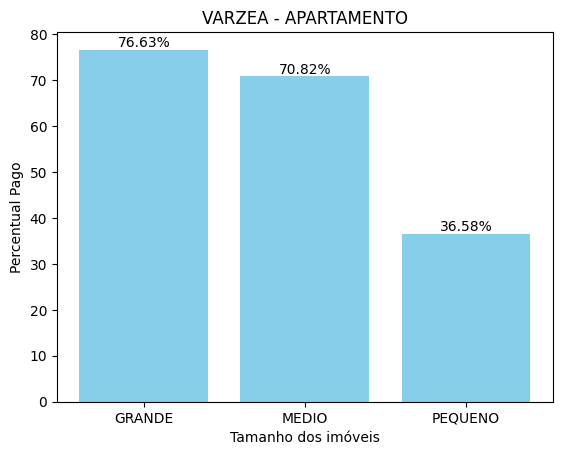

In [ ]:
def formatar_moeda(valor):
    return f'{valor:,.2f}%'

fig, ax = plt.subplots()
tamanho_apartamento = tamanho_apartamento.sort_values(by='percentual_pago_%', ascending=False)

bars = ax.bar(tamanho_apartamento['tamanho_imovel'], tamanho_apartamento['percentual_pago_%'], color='skyblue')

ax.set_xlabel('Tamanho dos imóveis')
ax.set_ylabel('Percentual Pago')
ax.set_title('VARZEA - APARTAMENTO')

ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval, formatar_moeda(yval), ha='center', va='bottom')

plt.show()

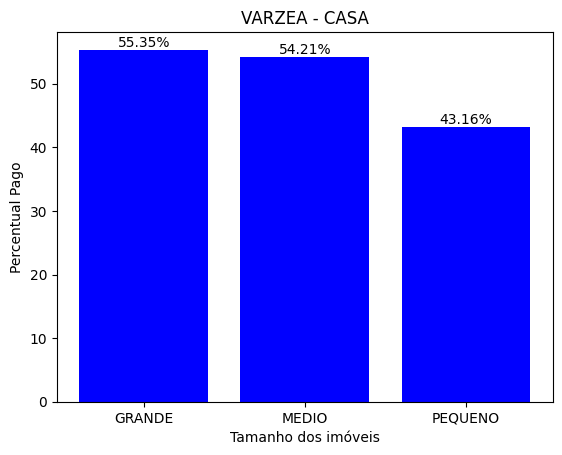

In [ ]:
def formatar_moeda(valor):
    return f'{valor:,.2f}%'

fig, ax = plt.subplots()
tamanho_casa = tamanho_casa.sort_values(by='percentual_pago_%', ascending=False)

bars = ax.bar(tamanho_casa['tamanho_imovel'], tamanho_casa['percentual_pago_%'], color='blue')

ax.set_xlabel('Tamanho dos imóveis')
ax.set_ylabel('Percentual Pago')
ax.set_title('VARZEA - CASA')

ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval, formatar_moeda(yval), ha='center', va='bottom')

plt.show()

In [ ]:
formatar_moeda(tamanho_casa['vlr_aberto'].sum)

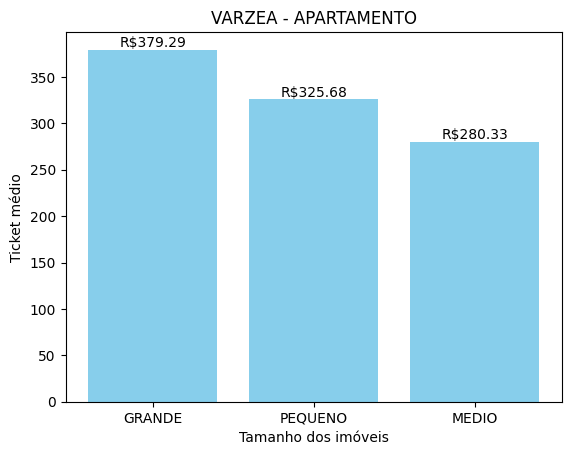

In [ ]:
def formatar_moeda(valor):
    return f'R${valor:,.2f}'

fig, ax = plt.subplots()
tamanho_apartamento = tamanho_apartamento.sort_values(by='ticket_medio', ascending=False)

bars = ax.bar(tamanho_apartamento['tamanho_imovel'], tamanho_apartamento['ticket_medio'], color='skyblue')

ax.set_xlabel('Tamanho dos imóveis')
ax.set_ylabel('Ticket médio')
ax.set_title('VARZEA - APARTAMENTO')

ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval, formatar_moeda(yval), ha='center', va='bottom')

plt.show()

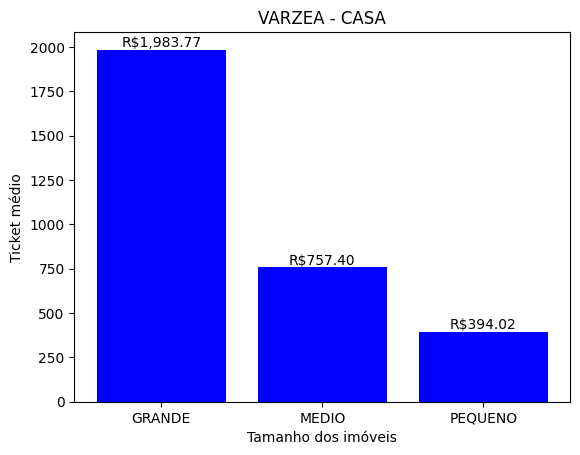

In [ ]:
def formatar_moeda(valor):
    return f'R${valor:,.2f}'

fig, ax = plt.subplots()
tamanho_casa = tamanho_casa.sort_values(by='ticket_medio', ascending=False)

bars = ax.bar(tamanho_casa['tamanho_imovel'], tamanho_casa['ticket_medio'], color='blue')

ax.set_xlabel('Tamanho dos imóveis')
ax.set_ylabel('Ticket médio')
ax.set_title('VARZEA - CASA')

ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval, formatar_moeda(yval), ha='center', va='bottom')

plt.show()

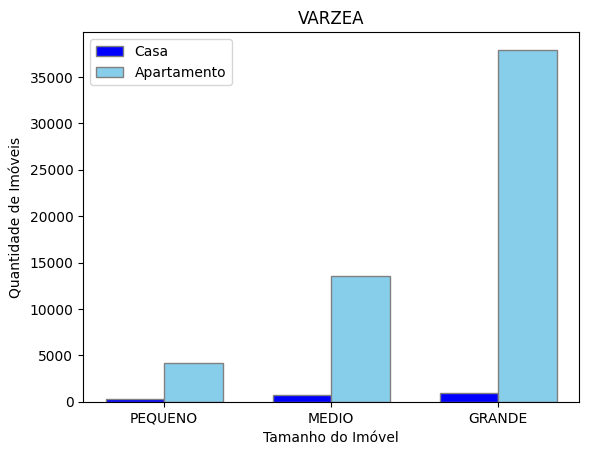

In [ ]:
categorias_ordem = ['PEQUENO', 'MEDIO', 'GRANDE']

tamanho_casa['tamanho_imovel'] = pd.Categorical(tamanho_casa['tamanho_imovel'], categories=categorias_ordem, ordered=True)
tamanho_apartamento['tamanho_imovel'] = pd.Categorical(tamanho_apartamento['tamanho_imovel'], categories=categorias_ordem, ordered=True)

tamanho_casa = tamanho_casa.sort_values('tamanho_imovel')
tamanho_apartamento = tamanho_apartamento.sort_values('tamanho_imovel')

barWidth = 0.35
r1 = np.arange(len(tamanho_casa['tamanho_imovel']))
r2 = [x + barWidth for x in r1]

plt.bar(r1, tamanho_casa['id_imovel'], color='blue', width=barWidth, edgecolor='grey', label='Casa')
plt.bar(r2, tamanho_apartamento['id_imovel'], color='skyblue', width=barWidth, edgecolor='grey', label='Apartamento')

plt.xlabel('Tamanho do Imóvel')
plt.ylabel('Quantidade de Imóveis')
plt.title('VARZEA')
plt.xticks([r + barWidth/2 for r in range(len(tamanho_casa['tamanho_imovel']))], tamanho_casa['tamanho_imovel'])
plt.legend()

plt.show()

In [ ]:
contribuinte

,id_contribuinte,reco_debito,reco_divida_ativa,freq_parcelamento,hist_pagamento_qtd,num_imoveis,pgt_cota_unica,hist_aberto_qtd,hist_dams_totais
0,00001a3e5b2177499daa7b7dbb545c1c,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
1,00003a695da4777aec557718ffae83ea,NaN,NaN,NaN,NaN,1,NaN,NaN,8.0
2,000046c85d18a6f7968646cfc1e328f2,NaN,NaN,NaN,NaN,1,1.0,NaN,8.0
3,0000b23be5378f1b8e79cf1867e8cc19,NaN,NaN,1.0,1.0,4,4.0,NaN,32.0
4,00014b72ca2a255bd4613fe022d53698,1.0,NaN,NaN,5.0,2,1.0,1.0,17.0
...,...,...,...,...,...,...,...,...,...
250260,ffff0e3e56845cdf1603ecd7ff6be21f,1.0,1.0,2.0,1.0,1,NaN,2.0,7.0
250261,ffff3836dbf935321bc34267b5521a39,NaN,NaN,NaN,2.0,1,NaN,NaN,8.0
250262,ffff63826b501d84d8b209292c0ce31d,1.0,NaN,NaN,NaN,2,NaN,1.0,8.0
250263,ffffc6563e67d8b38e79cf1867e8cc19,NaN,NaN,NaN,3.0,3,2.0,NaN,14.0


In [ ]:
from scipy.stats import spearmanr
import pandas as pd

# Supondo que 'contribuinte' seja um DataFrame do pandas
base = contribuinte[['reco_debito', 'reco_divida_ativa', 'freq_parcelamento', 'hist_pagamento_qtd', 'num_imoveis', 'pgt_cota_unica', 'hist_aberto_qtd', 'hist_dams_totais']]

# Calculando a matriz de correlação de Spearman
correlation_matrix, _ = spearmanr(base)
correlation_df = pd.DataFrame(correlation_matrix, columns=base.columns, index=base.columns)

print("Matriz de Correlação de Spearman:")
correlation_df


Matriz de Correlação de Spearman:


,reco_debito,reco_divida_ativa,freq_parcelamento,hist_pagamento_qtd,num_imoveis,pgt_cota_unica,hist_aberto_qtd,hist_dams_totais
reco_debito,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
reco_divida_ativa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq_parcelamento,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hist_pagamento_qtd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_imoveis,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
pgt_cota_unica,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hist_aberto_qtd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hist_dams_totais,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
asd = contribuinte[contribuinte['id_contribuinte'] == '71fc88ab6bbb201c344d77602867ec09']
asd

,id_contribuinte,reco_debito,reco_divida_ativa,freq_parcelamento,hist_pagamento_qtd,num_imoveis,pgt_cota_unica,hist_aberto_qtd,hist_dams_totais
111158,71fc88ab6bbb201c344d77602867ec09,NaN,NaN,NaN,NaN,1,1.0,NaN,8.0


In [ ]:
jefin = teste.query("cota_unica == 0")
jefin

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,data_ultimo_pagamento,vlr_pago,vlr_aberto,vlr_total_dam,regiao,rpa,cota_unica
7,00006a4fa855b308,4d4156c000b5dfc611babe4a46e18b6d,d87e514082d2101ed4613fe022d53698,2018.0,1,48.85,1,P,APARTAMENTO,CONSTRUÍDA,IPUTINGA,2008-12-11 22:40:00,2018-02-05,211.72,0.0,211.72,OESTE,4,0
8,00006a4fa855b308,5e47335403663289e08920064611a7cf,d87e514082d2101ed4613fe022d53698,2017.0,1,48.85,1,P,APARTAMENTO,CONSTRUÍDA,IPUTINGA,2008-12-11 22:40:00,2018-09-10,252.53,0.0,292.30,OESTE,4,0
9,00006a4fa855b308,9a9e5001c2cd0c5f875350beaddc7871,d87e514082d2101ed4613fe022d53698,2022.0,1,48.85,1,P,APARTAMENTO,CONSTRUÍDA,IPUTINGA,2008-12-11 22:40:00,2022-05-09,254.60,0.0,254.60,OESTE,4,0
12,00006a4fa855b308,f210353564b8cc8290ecf5aaf6be6eb7,d87e514082d2101ed4613fe022d53698,2023.0,1,48.85,1,P,APARTAMENTO,CONSTRUÍDA,IPUTINGA,2008-12-11 22:40:00,2023-05-08,269.24,0.0,269.24,OESTE,4,0
14,0000a2cbd951c1ca,435620f76ae803e219002eec9f619408,c2357fdb65f5cbed8e79cf1867e8cc19,2021.0,1,174.01,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 21:52:00,2023-08-09,2636.40,0.0,2646.25,SUL,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013467,fffee3cacb174a68,aaaca04ff960a1a5875350beaddc7871,76ab1d625a4a69d0d8b209292c0ce31d,2022.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2022-11-09,626.75,0.0,628.62,OESTE,4,0
2013468,fffee3cacb174a68,c0ff37bd120cc0d619002eec9f619408,76ab1d625a4a69d0d8b209292c0ce31d,2021.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2021-11-08,568.39,0.0,570.09,OESTE,4,0
2013469,fffee3cacb174a68,c8d60514c5f4b18ee08920064611a7cf,76ab1d625a4a69d0d8b209292c0ce31d,2017.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2017-11-10,503.20,0.0,503.20,OESTE,4,0
2013470,fffee3cacb174a68,e46ab0c52787357611babe4a46e18b6d,76ab1d625a4a69d0d8b209292c0ce31d,2018.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2018-11-09,515.10,0.0,515.10,OESTE,4,0


In [ ]:
ff = teste.query("id_contribuinte == '71fc88ab6bbb201c344d77602867ec09'")
ff

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,data_ultimo_pagamento,vlr_pago,vlr_aberto,vlr_total_dam,regiao,rpa,cota_unica
0,000032f6d93a0abd,2d0abb2531f5995c19002eec9f619408,71fc88ab6bbb201c344d77602867ec09,2021.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2021-01-26,2944.10,0.0,2944.10,NORDESTE,3A,1
1,000032f6d93a0abd,393f868ac32df28f4c1f696350fff79e,71fc88ab6bbb201c344d77602867ec09,2019.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2019-01-08,2627.70,0.0,2627.70,NORDESTE,3A,1
2,000032f6d93a0abd,7b9ddc3437bacdef875350beaddc7871,71fc88ab6bbb201c344d77602867ec09,2022.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2022-01-21,3335.10,0.0,3335.10,NORDESTE,3A,1
3,000032f6d93a0abd,b114a952d31c024190ecf5aaf6be6eb7,71fc88ab6bbb201c344d77602867ec09,2023.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2023-01-23,3630.40,0.0,3630.40,NORDESTE,3A,1
4,000032f6d93a0abd,d22fdd2de1578b53e08920064611a7cf,71fc88ab6bbb201c344d77602867ec09,2017.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2017-01-26,2459.37,0.0,2459.37,NORDESTE,3A,1
5,000032f6d93a0abd,e6aebd3d9bee80d811babe4a46e18b6d,71fc88ab6bbb201c344d77602867ec09,2018.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2018-01-22,2519.60,0.0,2519.60,NORDESTE,3A,1
6,000032f6d93a0abd,fedb8d299d9842480ba9f03948490762,71fc88ab6bbb201c344d77602867ec09,2020.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2020-01-21,2764.50,0.0,2764.50,NORDESTE,3A,1


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# Criando um conjunto de dados fictício
data = {
    'Alimento': ['Pizza', 'Hambúrguer', 'Sushi', 'Pizza', 'Hambúrguer', 'Sushi', 'Pizza', 'Hambúrguer', 'Sushi'],
    'Bebida': ['Refrigerante', 'Suco', 'Café', 'Refrigerante', 'Suco', 'Café', 'Refrigerante', 'Suco', 'Café']
}

df = pd.DataFrame(data)

# Criando uma tabela de contingência
contingency_table = pd.crosstab(df['Alimento'], df['Bebida'])

# Calculando a correlação de Cramer's V
chi2, _, _, _ = chi2_contingency(contingency_table)
n = np.sum(contingency_table)
v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

print(f"A correlação de Cramer's V é: {v}")


A correlação de Cramer's V é: Bebida
Café            1.732051
Refrigerante    1.732051
Suco            1.732051
dtype: float64


In [ ]:
tbl_debitos_dam_4 = r'C:\Users\Consultor\Documents\bases_pesquisa\verificacao\tbl_dam_debito_4.csv'
debitos_divida = pd.read_csv(tbl_debitos_dam_4)
debitos_divida

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,data_ultimo_pagamento,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_total_dam
0,000032f6d93a0abd,2d0abb2531f5995c19002eec9f619408,71fc88ab6bbb201c344d77602867ec09,2021.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2021-01-26,1.0,38.0,2944.10,0.0,2944.10
1,000032f6d93a0abd,393f868ac32df28f4c1f696350fff79e,71fc88ab6bbb201c344d77602867ec09,2019.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2019-01-08,1.0,38.0,2627.70,0.0,2627.70
2,000032f6d93a0abd,7b9ddc3437bacdef875350beaddc7871,71fc88ab6bbb201c344d77602867ec09,2022.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2022-01-21,1.0,38.0,3335.10,0.0,3335.10
3,000032f6d93a0abd,b114a952d31c024190ecf5aaf6be6eb7,71fc88ab6bbb201c344d77602867ec09,2023.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2023-01-23,1.0,38.0,3630.40,0.0,3630.40
4,000032f6d93a0abd,d22fdd2de1578b53e08920064611a7cf,71fc88ab6bbb201c344d77602867ec09,2017.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2017-01-26,1.0,38.0,2459.37,0.0,2459.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016992,fffee3cacb174a68,aaaca04ff960a1a5875350beaddc7871,76ab1d625a4a69d0d8b209292c0ce31d,2022.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2022-11-09,0.0,41.0,626.75,0.0,628.62
2016993,fffee3cacb174a68,c0ff37bd120cc0d619002eec9f619408,76ab1d625a4a69d0d8b209292c0ce31d,2021.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2021-11-08,0.0,41.0,568.39,0.0,570.09
2016994,fffee3cacb174a68,c8d60514c5f4b18ee08920064611a7cf,76ab1d625a4a69d0d8b209292c0ce31d,2017.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2017-11-10,0.0,41.0,503.20,0.0,503.20
2016995,fffee3cacb174a68,e46ab0c52787357611babe4a46e18b6d,76ab1d625a4a69d0d8b209292c0ce31d,2018.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2018-11-09,0.0,41.0,515.10,0.0,515.10


In [ ]:
arq_bairros = r'C:\Users\Consultor\Documents\bases_pesquisa\bairros.xlsx'
tbl_bairros = pd.read_excel(arq_bairros)
tbl_bairros

,bairro,regiao,rpa
0,AFLITOS,NORDESTE,3A
1,AFOGADOS,SUDESTE,5
2,AGUA FRIA,NORTE,2
3,ALTO JOSE BONIFACIO,NORDESTE,3B
4,ALTO JOSE DO PINHO,NORDESTE,3B
...,...,...,...
89,TORROES,OESTE,4
90,TOTO,SUDESTE,5
91,VARZEA,OESTE,4
92,VASCO DA GAMA,NORDESTE,3B


In [ ]:
debitos_divida = pd.merge(debitos_divida, tbl_bairros, on='bairro', how='left')
debitos_divida

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,data_ultimo_pagamento,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_total_dam,regiao,rpa
0,000032f6d93a0abd,2d0abb2531f5995c19002eec9f619408,71fc88ab6bbb201c344d77602867ec09,2021.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2021-01-26,1.0,38.0,2944.10,0.0,2944.10,NORDESTE,3A
1,000032f6d93a0abd,393f868ac32df28f4c1f696350fff79e,71fc88ab6bbb201c344d77602867ec09,2019.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2019-01-08,1.0,38.0,2627.70,0.0,2627.70,NORDESTE,3A
2,000032f6d93a0abd,7b9ddc3437bacdef875350beaddc7871,71fc88ab6bbb201c344d77602867ec09,2022.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2022-01-21,1.0,38.0,3335.10,0.0,3335.10,NORDESTE,3A
3,000032f6d93a0abd,b114a952d31c024190ecf5aaf6be6eb7,71fc88ab6bbb201c344d77602867ec09,2023.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2023-01-23,1.0,38.0,3630.40,0.0,3630.40,NORDESTE,3A
4,000032f6d93a0abd,d22fdd2de1578b53e08920064611a7cf,71fc88ab6bbb201c344d77602867ec09,2017.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2017-01-26,1.0,38.0,2459.37,0.0,2459.37,NORDESTE,3A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016992,fffee3cacb174a68,aaaca04ff960a1a5875350beaddc7871,76ab1d625a4a69d0d8b209292c0ce31d,2022.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2022-11-09,0.0,41.0,626.75,0.0,628.62,OESTE,4
2016993,fffee3cacb174a68,c0ff37bd120cc0d619002eec9f619408,76ab1d625a4a69d0d8b209292c0ce31d,2021.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2021-11-08,0.0,41.0,568.39,0.0,570.09,OESTE,4
2016994,fffee3cacb174a68,c8d60514c5f4b18ee08920064611a7cf,76ab1d625a4a69d0d8b209292c0ce31d,2017.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2017-11-10,0.0,41.0,503.20,0.0,503.20,OESTE,4
2016995,fffee3cacb174a68,e46ab0c52787357611babe4a46e18b6d,76ab1d625a4a69d0d8b209292c0ce31d,2018.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2018-11-09,0.0,41.0,515.10,0.0,515.10,OESTE,4


In [6]:
tbl_contribuinte = r'C:\Users\Consultor\Documents\bases_pesquisa\verificacao\tbl_contribuinte_db_3.csv'
contribuinte = pd.read_csv(tbl_contribuinte)
contribuinte

,id_contribuinte,reco_debito,reco_divida_ativa,freq_parcelamento,hist_pagamento_qtd,num_imoveis,pgt_cota_unica,hist_aberto_qtd,hist_dams_totais
0,0000398c485f8b42344d77602867ec09,2.0,3.0,NaN,NaN,1,1.0,2.0,3
1,00003a695da4777aec557718ffae83ea,NaN,NaN,NaN,NaN,1,2.0,NaN,8
2,000046c85d18a6f7968646cfc1e328f2,NaN,NaN,NaN,NaN,1,6.0,NaN,8
3,0000b23be5378f1b8e79cf1867e8cc19,NaN,NaN,1.0,1.0,4,104.0,NaN,32
4,00014b72ca2a255bd4613fe022d53698,1.0,NaN,NaN,5.0,2,18.0,1.0,17
...,...,...,...,...,...,...,...,...,...
219526,ffff0e3e56845cdf1603ecd7ff6be21f,NaN,1.0,2.0,1.0,1,1.0,1.0,7
219527,ffff3836dbf935321bc34267b5521a39,NaN,NaN,NaN,2.0,1,5.0,NaN,8
219528,ffff63826b501d84d8b209292c0ce31d,NaN,NaN,NaN,NaN,2,0.0,NaN,8
219529,ffffc6563e67d8b38e79cf1867e8cc19,NaN,NaN,NaN,3.0,3,24.0,NaN,14


# VIEW HISTORICO CONTRIBUINTE

In [7]:
tbl_hist_contribuinte = r'C:\Users\Consultor\Documents\bases_pesquisa\verificacao\tbl_historico_contribuinte_db.csv'
hist_contribuinte = pd.read_csv(tbl_hist_contribuinte)
hist_contribuinte

,ano,id_contribuinte,reco_debito,reco_divida_ativa,freq_parcelamento,hist_pagamento_qtd,num_imoveis,pgt_cota_unica,hist_aberto_qtd,hist_dams_totais
0,2013,00001a3e5b2177499daa7b7dbb545c1c,0,0,0,0,0,0,0,0
1,2013,0000398c485f8b42344d77602867ec09,0,0,0,0,1,0,0,0
2,2013,00003a695da4777aec557718ffae83ea,0,0,0,0,1,0,0,0
3,2013,000046c85d18a6f7968646cfc1e328f2,0,0,0,0,1,0,0,0
4,2013,0000b23be5378f1b8e79cf1867e8cc19,0,0,0,0,4,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2763965,2023,ffff0e3e56845cdf1603ecd7ff6be21f,0,0,0,1,1,0,0,1
2763966,2023,ffff3836dbf935321bc34267b5521a39,0,0,0,1,1,0,0,1
2763967,2023,ffff63826b501d84d8b209292c0ce31d,0,0,0,1,1,0,0,1
2763968,2023,ffffc6563e67d8b38e79cf1867e8cc19,0,0,0,2,2,1,0,2


In [8]:
contagem_nulos_por_coluna = hist_contribuinte.isnull().sum()
total_registros_contribuinte = len(hist_contribuinte)

porcentagem_nulos = (contagem_nulos_por_coluna / total_registros_contribuinte) * 100

resultado = pd.DataFrame({
    'Contagem Nulos': contagem_nulos_por_coluna,
    'Total Registros': total_registros_contribuinte,
    'Porcentagem Nulos (%)': porcentagem_nulos
})

resultado

,Contagem Nulos,Total Registros,Porcentagem Nulos (%)
ano,0,2763970,0.0
id_contribuinte,0,2763970,0.0
reco_debito,0,2763970,0.0
reco_divida_ativa,0,2763970,0.0
freq_parcelamento,0,2763970,0.0
hist_pagamento_qtd,0,2763970,0.0
num_imoveis,0,2763970,0.0
pgt_cota_unica,0,2763970,0.0
hist_aberto_qtd,0,2763970,0.0
hist_dams_totais,0,2763970,0.0


In [9]:
hist_contribuinte.nunique()

ano                       11
id_contribuinte       251270
reco_debito                2
reco_divida_ativa          2
freq_parcelamento          2
hist_pagamento_qtd       247
num_imoveis              176
pgt_cota_unica             2
hist_aberto_qtd          148
hist_dams_totais         292
dtype: int64

A variável hist_dams_totais conta por ano quantas Dams foram lançadas em relação a quantidade de imóveis, caso não haja lançamento, o imóvel foi isento de pagamento.

A variável de hist_aberto_qtd conta quantas DAMS estão abertas por ano daquele contribuinte em relação aos seus imóveis

A variável pgt_cota_unica conta quantas vezes o contribuinte pagou em cota única por ano ( tem relação com imóvel)

A variável num_imoveis conta quantos imóveis aquele contribuinte tem naquele ano

Acredito que nessa view eu não precise da recorrencia de debito, recorrencia de divida ativa e frequencia de parcelamento, o interessante é pegar as informações mais granulares que pudermos conseguir sobre qualquer evento pertinente do contribuinte, seja de pagamento ou de outros fatores como cotas em aberto, pagas etc...



In [10]:
contr = hist_contribuinte.query("id_contribuinte == 'ffffc6563e67d8b38e79cf1867e8cc19'")
contr

,ano,id_contribuinte,reco_debito,reco_divida_ativa,freq_parcelamento,hist_pagamento_qtd,num_imoveis,pgt_cota_unica,hist_aberto_qtd,hist_dams_totais
251268,2013,ffffc6563e67d8b38e79cf1867e8cc19,0,0,0,0,2,0,0,0
502538,2014,ffffc6563e67d8b38e79cf1867e8cc19,0,0,0,0,2,0,0,0
753808,2015,ffffc6563e67d8b38e79cf1867e8cc19,0,0,0,0,2,0,0,0
1005078,2016,ffffc6563e67d8b38e79cf1867e8cc19,0,0,0,2,2,0,0,2
1256348,2017,ffffc6563e67d8b38e79cf1867e8cc19,0,0,0,2,2,0,0,2
1507618,2018,ffffc6563e67d8b38e79cf1867e8cc19,0,0,0,0,2,0,0,0
1758888,2019,ffffc6563e67d8b38e79cf1867e8cc19,0,0,0,2,2,0,0,2
2010158,2020,ffffc6563e67d8b38e79cf1867e8cc19,0,0,0,2,2,0,0,2
2261428,2021,ffffc6563e67d8b38e79cf1867e8cc19,0,0,0,2,2,0,0,2
2512698,2022,ffffc6563e67d8b38e79cf1867e8cc19,0,0,0,2,2,0,0,2


In [13]:
hist = hist_contribuinte.query("num_imoveis != 1")
hist

,ano,id_contribuinte,reco_debito,reco_divida_ativa,freq_parcelamento,hist_pagamento_qtd,num_imoveis,pgt_cota_unica,hist_aberto_qtd,hist_dams_totais
0,2013,00001a3e5b2177499daa7b7dbb545c1c,0,0,0,0,0,0,0,0
4,2013,0000b23be5378f1b8e79cf1867e8cc19,0,0,0,0,4,0,0,0
5,2013,00014b72ca2a255bd4613fe022d53698,0,0,0,0,2,0,0,0
6,2013,0001de7df29f8e85cd124eb8021f7dca,0,0,0,0,2,0,0,0
10,2013,000473f4656786d9d4613fe022d53698,0,0,0,0,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2763961,2023,fffe6648731a1c64abddf8b4bf3dd787,0,0,0,1,2,0,0,1
2763962,2023,fffea8c8c9cd46b4344d77602867ec09,0,0,0,0,0,0,0,0
2763963,2023,fffebe9391e14292344d77602867ec09,1,0,0,2,2,0,0,2
2763964,2023,ffff083826a4e3f7d8b209292c0ce31d,1,0,0,1,2,0,1,2


In [14]:
hist = hist_contribuinte.query("num_imoveis == 1")
hist

,ano,id_contribuinte,reco_debito,reco_divida_ativa,freq_parcelamento,hist_pagamento_qtd,num_imoveis,pgt_cota_unica,hist_aberto_qtd,hist_dams_totais
1,2013,0000398c485f8b42344d77602867ec09,0,0,0,0,1,0,0,0
2,2013,00003a695da4777aec557718ffae83ea,0,0,0,0,1,0,0,0
3,2013,000046c85d18a6f7968646cfc1e328f2,0,0,0,0,1,0,0,0
7,2013,00022915d03c589c0b59a1d5bcae3806,0,0,0,0,1,0,0,0
8,2013,00033f0e4ec8a051ec24828071529570,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2763958,2023,fffd0aa05b3e4fc40246e2b93c1bf25c,1,0,0,0,1,0,1,1
2763965,2023,ffff0e3e56845cdf1603ecd7ff6be21f,0,0,0,1,1,0,0,1
2763966,2023,ffff3836dbf935321bc34267b5521a39,0,0,0,1,1,0,0,1
2763967,2023,ffff63826b501d84d8b209292c0ce31d,0,0,0,1,1,0,0,1


In [15]:
791714/1972256 * 100

40.14255755845083

In [ ]:
contr = contribuinte.query("num_imoveis == 1")
contr

,id_contribuinte,reco_debito,reco_divida_ativa,freq_parcelamento,hist_pagamento_qtd,num_imoveis,pgt_cota_unica,hist_aberto_qtd,hist_dams_totais
0,0000398c485f8b42344d77602867ec09,2.0,3.0,NaN,NaN,1,1.0,2.0,3
1,00003a695da4777aec557718ffae83ea,NaN,NaN,NaN,NaN,1,2.0,NaN,8
2,000046c85d18a6f7968646cfc1e328f2,NaN,NaN,NaN,NaN,1,6.0,NaN,8
6,00022915d03c589c0b59a1d5bcae3806,NaN,NaN,NaN,2.0,1,1.0,NaN,8
7,00033f0e4ec8a051ec24828071529570,NaN,1.0,NaN,1.0,1,0.0,NaN,7
...,...,...,...,...,...,...,...,...,...
219518,fffbe473a0368b52cd124eb8021f7dca,NaN,6.0,4.0,1.0,1,0.0,5.0,8
219519,fffcbecc21cb7ed78e79cf1867e8cc19,NaN,NaN,NaN,NaN,1,7.0,NaN,8
219526,ffff0e3e56845cdf1603ecd7ff6be21f,NaN,1.0,2.0,1.0,1,1.0,1.0,7
219527,ffff3836dbf935321bc34267b5521a39,NaN,NaN,NaN,2.0,1,5.0,NaN,8


In [11]:
48887/170644 *100

28.648531445582613